In [1]:
!pip3 install openbox

In [2]:
class Data:
    def __init__(self, sensorPositions, space, epsilon):
        self.radius = 1
        self.placeHolders = sensorPositions
        self.epsilon = epsilon
        self.space = space
        # self.SensorPlaceHolderSetup()
        
    def frange(self, start, stop, step):
        steps = []
        while start <= stop:
            steps.append(start)
            start +=step
            
        return steps

    # def SensorPlaceHolderSetup(self):
    #     Xs = self.frange(0, self.space[0], self.epsilon)
    #     Ys = self.frange(0, self.space[1], self.epsilon)
            
    #     for x in Xs:
    #       for y in Ys:
    #         self.placeHolders.append([x, y])

    def GetSensorConfiguration(self):
        from collections import Counter
        sensorLocations, sensorTypes = self.GetSensorLocations()

        summaryDict = Counter(sensorTypes)

        # TODO: DIFFERENT SENSOR TYPE DEFINITIONS SHOULD BE ADDED HERE:
        configurationSummary = []
        for key in summaryDict:
            if (key == 1):
                configurationSummary.append(['motion sensors', summaryDict[key]])

            elif (key == 2):
                configurationSummary.append(['beacon sensors', summaryDict[key]])

        configurationDetails = []
        for index, loc in enumerate(sensorLocations):
            if (sensorTypes[index] == 1):
                configurationDetails.append(tuple([loc, 'kitchen', 'motion sensors']))

            elif (sensorTypes[index] == 2):
                configurationDetails.append(tuple([loc, 'kitchen', 'beacon sensors']))

        return [[configurationSummary, [tuple(configurationDetails)]], self.radius]


    def GetSensorLocations(self):
        sensorLocations = []
        sensorTypes = []
        for index, sensorIndicator in enumerate(self.placeHolders):
            sensorLocations.append(self.placeHolders[index])

            # TODO: DIFFERENT SENSOR TYPE DEFINITIONS SHOULD BE ADDED HERE:
            sensorTypes.append(1)


        return sensorLocations, sensorTypes


class BOVariables:
    def __init__(self, Data_path, epsilon, initSensorNum, maxSensorNum, radius, sampleSize):
        self.epsilon = epsilon
        self.Data_path = Data_path
        self.initSensorNum = initSensorNum
        self.maxSensorNum = maxSensorNum
        self.radius = radius
        self.sensor_distribution, self.types, self.space, self.rooms, self.agentTraces = self.ModelsInitializations()

    def ModelsInitializations(self):
        #----- Space and agent models -----: 
        # simworldname = self.Data_path + '/Configuration Files/simulationWorld2.xml'
        agentTraces = []
        directory = os.fsencode(self.Data_path + 'Agent Trace Files/')
            
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".csv"): 
                agentTraces.append(self.Data_path + 'Agent Trace Files/' + filename)

        # Parsing the space model: 
        space, rooms = pf.ParseWorld('')

        xs = []
        for i in space:
          for j in i:
            xs.append(j)
        A = list(set(xs))
        A.sort()
        space = [A[-1], A[-2]]

        # User parameters 
        types, sensor_distribution = pf.GetUsersParameters()

        roomsList = []
        for room in sensor_distribution:
            roomsList.append(room)
              
        return sensor_distribution, types, space, rooms, agentTraces


def frange(start, stop, step):
    steps = []
    while start <= stop:
        steps.append(start)
        start +=step
        
    return steps

def MakeSensorCombinations(start, end, epsilon, sensorType, room):
    a1, b1 = makeBoundaries(epsilon, start[0], end[0])
    a2, b2 = makeBoundaries(epsilon, start[1], end[1])    
    Xs = frange(a1, b1, epsilon)
    Ys = frange(a2, b2, epsilon)
    
    points = list(itertools.product(list(itertools.product(Xs, Ys)), [room], [sensorType[0]])) 
    C = itertools.combinations(points, distribution[room][types.index(sensorType)])

    return C

def PreProcessor(df):
    # df['motion sensors'] = df['motion sensors'].apply(ast.literal_eval)
    df['motion sensors'] = df['motion sensors'].apply(lambda s: list(map(int, s)))
    # df['beacon sensors'] = df['beacon sensors'].apply(ast.literal_eval)
    try:
      df['beacon sensors'] = df['beacon sensors'].apply(lambda s: list(map(int, s)))
    except:
      pass

    sensors = set([])

    previous_M = None
    previous_B = None
    output_file = []

    for index, row in df.iterrows():
      T = row['time']
      M = row['motion sensors']
      try:
        B = row['beacon sensors']
      except:
        pass

      Activity = row['activity']
      Activity = Activity.replace(' ', '_')
      MotionSensor_Names = []
      sensorNames = []
      MotionSensor_Message = []
      BeaconSensor_Names = []
      BeaconSensor_Message = []
      

      # time = convertTime(T)
      time = "2020-06-16 " + T + ".00"

      # Motion Sensor
      for i in range(len(M)):
        sensorNames.append(Name(i, 'M'))
        if M[i] == 1:
          if (previous_M != None):
            if (previous_M[i] == 0):
              MotionSensor_Names.append(Name(i,'M'))
              MotionSensor_Message.append('ON')

          else:
            MotionSensor_Names.append(Name(i,'M'))
            MotionSensor_Message.append('ON')

        if previous_M != None:
          if M[i] == 0 and previous_M[i] == 1:
            MotionSensor_Names.append(Name(i,'M'))
            MotionSensor_Message.append('OFF')

      previous_M = M
      # Beacon Sensor

      try:
        for i in range(len(B)):
          sensorNames.append(Name(i, 'B'))
          if B[i] == 1:
            BeaconSensor_Names.append(Name(i,'B'))
            BeaconSensor_Message.append('ON')
          if previous_B != None:
            if B[i] == 0 and previous_B[i] == 1: 
              BeaconSensor_Names.append(Name(i,'B'))
              BeaconSensor_Message.append('OFF')
        previous_B = B

      except:
        pass

      for m in range(len(MotionSensor_Names)):
        output_file.append(time +' '+ MotionSensor_Names[m] + ' ' + MotionSensor_Names[m] + ' ' + MotionSensor_Message[m] + ' ' + Activity)
        
      for s in sensorNames:
          sensors.add(s)

    return output_file, list(sensors)

#returns the name of the sensor
def Name(number, typeSensor):
    if number < 10:
      return typeSensor + str(0) + str(number)
    else:
      return typeSensor + str(number)

#converts epoch time to human readable
def convertTime(posix_timestamp):
    tz = pytz.timezone('MST')
    dt = datetime.fromtimestamp(posix_timestamp, tz)
    time = dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    return time

def MakeDataBoundaries(height = 10.5, width = 6.6, MaxSensors = 15):
    from collections import defaultdict, OrderedDict

    d = dict()

    for idx in range(MaxSensors):
            d['x' + str(idx)] = (0.5, width - 0.5)
            d['y' + str(idx)] = (0.5, height - 0.5)

    return d

def black_box_function(sample, simulateMotionSensors = True, simulateEstimotes = False, Plotting = False):       
    files = []

    if (runningOnGoogleColab == True):
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/')
        Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/'
        
    else:
        sys.path.append('../../Codes/Sensor Simulator/')
        Data_path = '../../Codes/Sensor Simulator/'

    all_sensors = set([])

    for agentTrace in BOV.agentTraces:
        df_ = sim_sis.RunSimulator(BOV.space, BOV.rooms, agentTrace, sample.GetSensorConfiguration(), simulateMotionSensors, simulateEstimotes, Plotting, BOV.Data_path)
        dataFile, sensors = PreProcessor(df_)
        all_sensors.update(sensors)
        files.append(dataFile)
        
    
    if (runningOnGoogleColab == True):
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/CASAS/AL-Smarthome')

    else:
        sys.path.append('../../Codes/CASAS/AL-Smarthome')

    import al
    import imp
    imp.reload(al)
    all_sensors = list(all_sensors)

    accuracy = (al.leave_one_out(files, all_sensors)[0]) * 100

    if accuracy < 0:
        accuracy = 0

    return 100 - accuracy

def function_to_be_optimized(config):
    sensorPositions = []
    sensor_xy = []
    for i in range(1, 16):
      # print(config['x' + str(i)])
      # print(config['y' + str(i)])
      
      sensor_xy.append(config['x' + str(i)])
      sensor_xy.append(config['y' + str(i)])
      sensorPositions.append(sensor_xy)
      sensor_xy = []

    data = Data(sensorPositions, BOV.space, CONSTANTS['epsilon'])
    return black_box_function(data)

CONSTANTS = {
    'iterations': 100,
    'initial_samples': 10,
    'restarts_number': 10,
    'raw_samples': 10,
    'candidates_num': 1,
    'sequential': True,
    'epsilon': 1,
    'radius': 1,
    'height': 10.5,
    'width': 6.6,
    'max_sensors': 15  
}

runningOnGoogleColab = False
    
if __name__ ==  '__main__':
    import sys

    if (runningOnGoogleColab == True):
        from google.colab import drive    
        drive.mount('/content/gdrive', force_remount=True)
        Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/'
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/')
        
    else:
        Data_path = '../../Codes/Sensor Simulator/'
        sys.path.append('../../Codes/Sensor Simulator/')

    # from ax import optimize, ChoiceParameter
    from scipy.stats import norm
    from numpy import argmax
    import SIM_SIS_Libraries.SensorsClass
    import SIM_SIS_Libraries.SIM_SIS_Simulator as sim_sis
    import SIM_SIS_Libraries.ParseFunctions as pf
    import itertools
    import numpy as np
    import pandas as pd
    import SIM_SIS_Libraries.PreDeploymentEvaluation as pde
    import copy
    from datetime import datetime
    import pytz
    import ast
    import os
    import random
    import plotly
    import torch

    finalResults = []
    w = CONSTANTS['width'] - 0.5
    h = CONSTANTS['height'] - 0.5

    dataBoundaries = MakeDataBoundaries(
                                        height = CONSTANTS['height'], 
                                        width = CONSTANTS['width'], 
                                        MaxSensors = CONSTANTS['max_sensors']
                                       )

    BOV =  BOVariables(
                       Data_path, 
                       CONSTANTS['epsilon'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['radius'],
                       CONSTANTS['initial_samples']
                      )

    from openbox import sp

    # Define Search Space
    space = sp.Space()

    list_of_variables = []
    for i in range(1, 16):
        x = sp.Int("x" + str(i), 0, 6, default_value=0)
        y = sp.Int("y" + str(i), 0, 10, default_value=0)
        list_of_variables.append(x)
        list_of_variables.append(y)
    
    space.add_variables(list_of_variables)

    from openbox import Optimizer

    # Run
    opt = Optimizer(
        function_to_be_optimized,
        space,
        max_runs=1000,
        surrogate_type='gp',
        acq_optimizer_type='random_scipy',
        time_limit_per_trial=31000,
        task_id='Shadan',
    )
    history = opt.run()

In [3]:
CONSTANTS = {
    'iterations': 100,
    'initial_samples': 10,
    'restarts_number': 10,
    'raw_samples': 10,
    'candidates_num': 1,
    'sequential': True,
    'epsilon': 1,
    'radius': 1,
    'height': 10.5,
    'width': 6.6,
    'max_sensors': 15  
}

runningOnGoogleColab = False
    
if __name__ ==  '__main__':
    import sys

    if (runningOnGoogleColab == True):
        from google.colab import drive    
        drive.mount('/content/gdrive', force_remount=True)
        Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/SensorDeploymentOptimization/'
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/SensorDeploymentOptimization/')
        
    else:
        Data_path = '../../Codes/SensorDeploymentOptimization/'
        sys.path.append('../../Codes/SensorDeploymentOptimization/')

    # from ax import optimize, ChoiceParameter
    from scipy.stats import norm
    from numpy import argmax
    import SIM_SIS_Libraries.SensorsClass
    import SIM_SIS_Libraries.SIM_SIS_Simulator as sim_sis
    import SIM_SIS_Libraries.ParseFunctions as pf
    import itertools
    import numpy as np
    import pandas as pd
    import SIM_SIS_Libraries.PreDeploymentEvaluation as pde
    import copy
    from datetime import datetime
    import pytz
    import ast
    import os
    import random
    import plotly
    import torch

    finalResults = []
    w = CONSTANTS['width'] - 0.5
    h = CONSTANTS['height'] - 0.5

    dataBoundaries = MakeDataBoundaries(
                                        height = CONSTANTS['height'], 
                                        width = CONSTANTS['width'], 
                                        MaxSensors = CONSTANTS['max_sensors']
                                       )

    BOV =  BOVariables(
                       Data_path, 
                       CONSTANTS['epsilon'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['radius'],
                       CONSTANTS['initial_samples']
                      )

    
    


KeyboardInterrupt: 

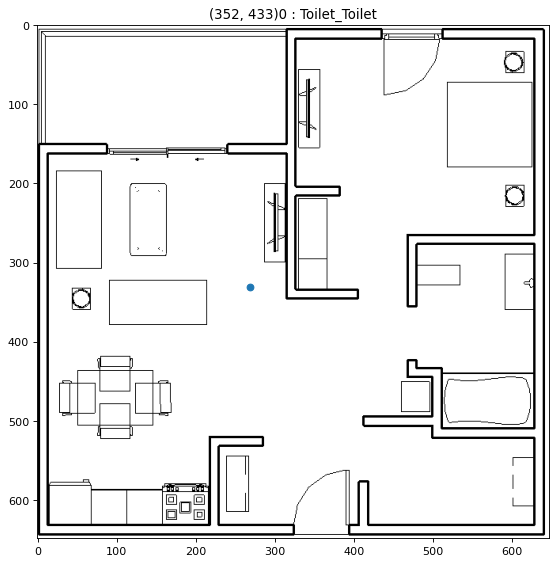

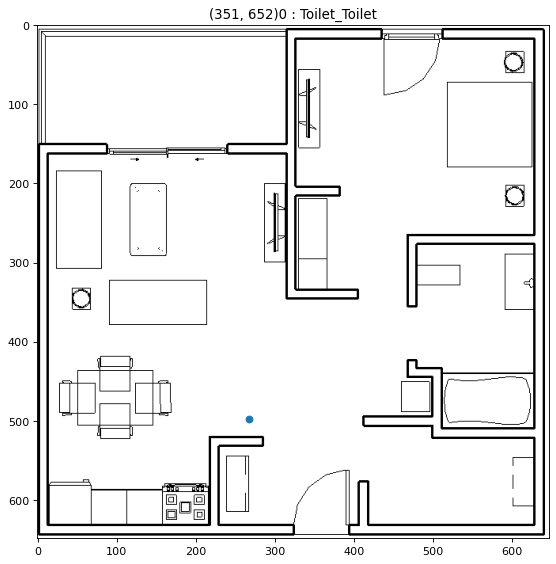

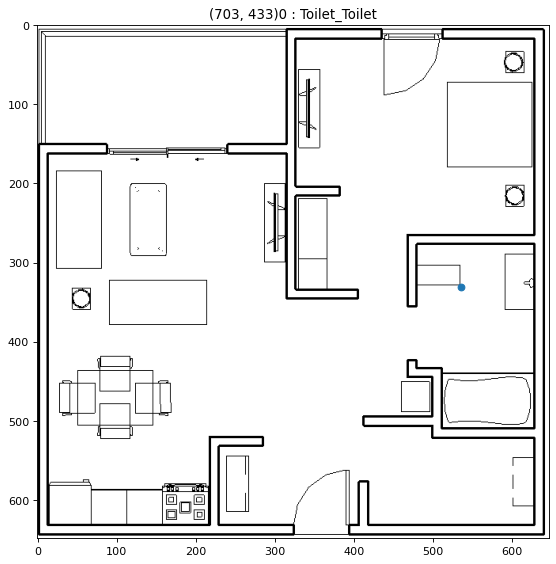

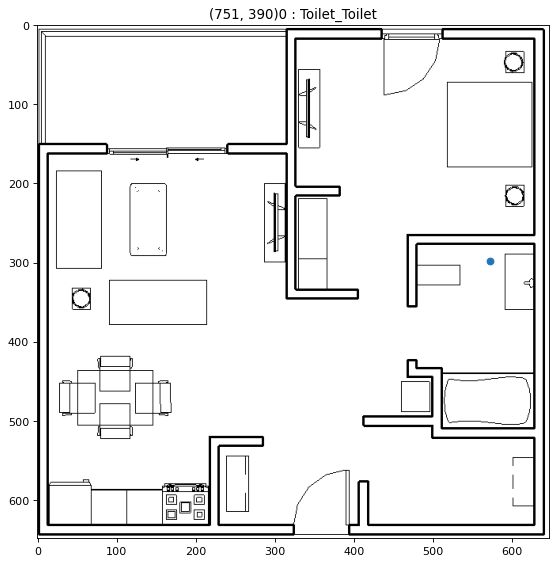

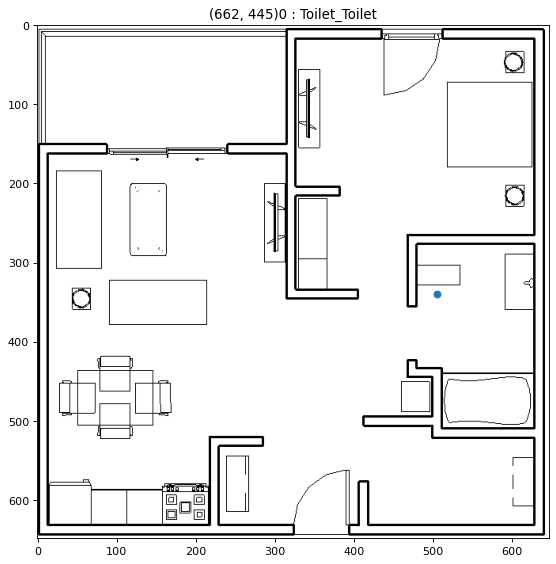

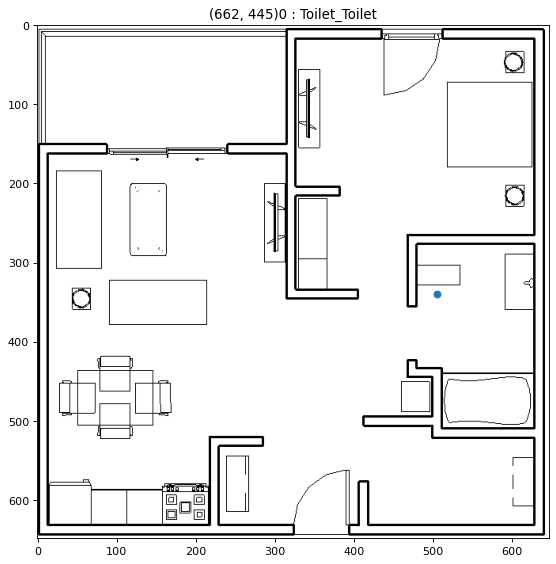

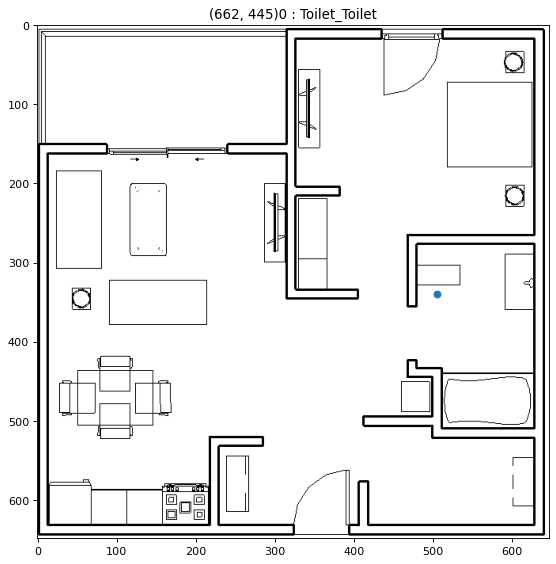

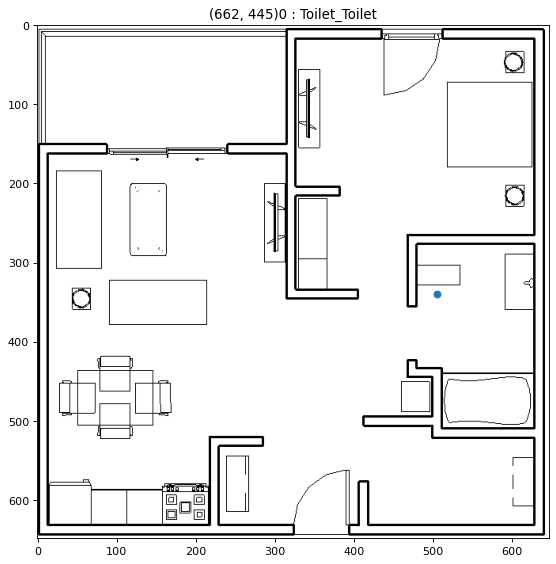

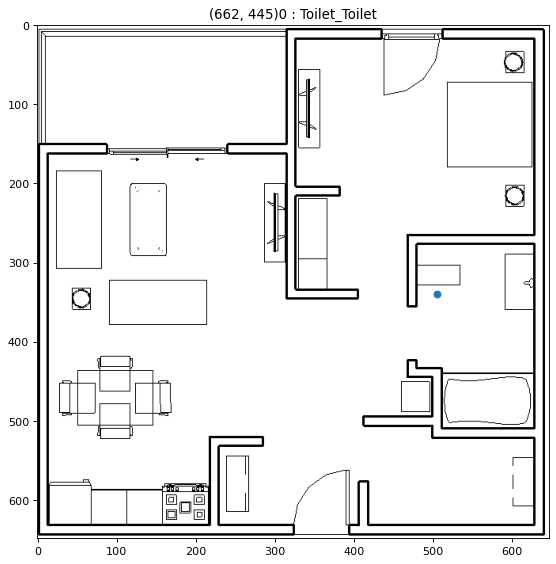

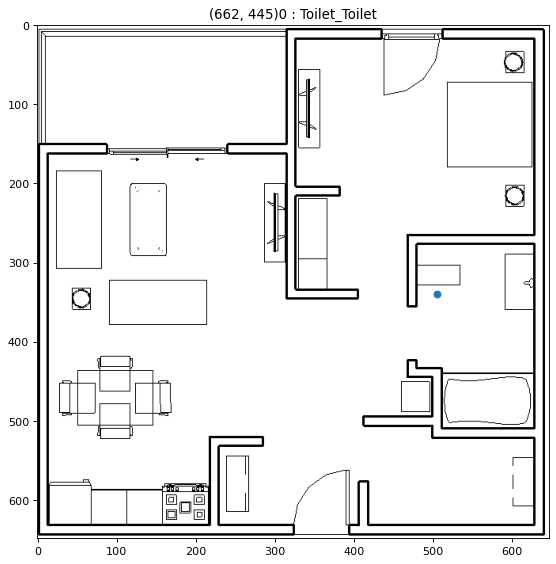

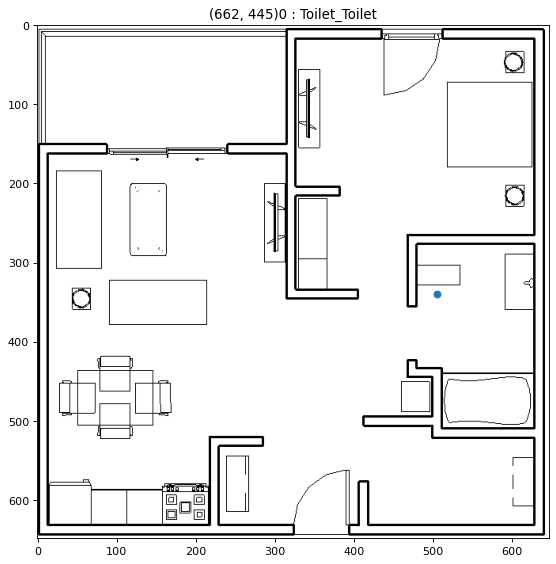

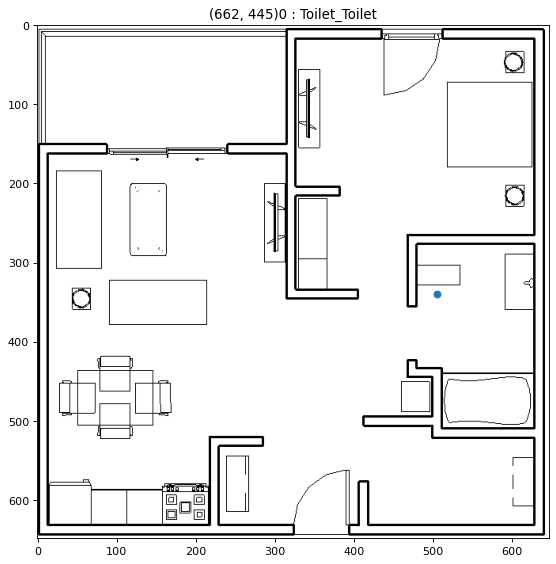

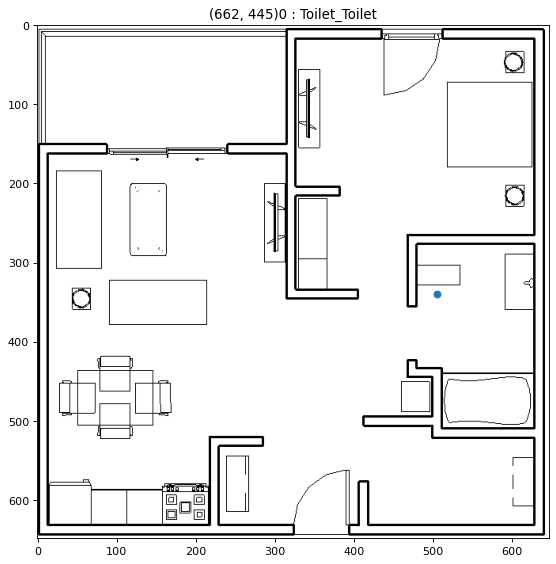

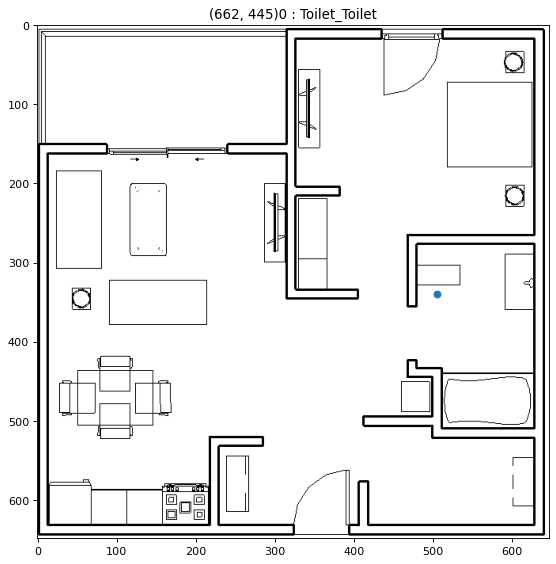

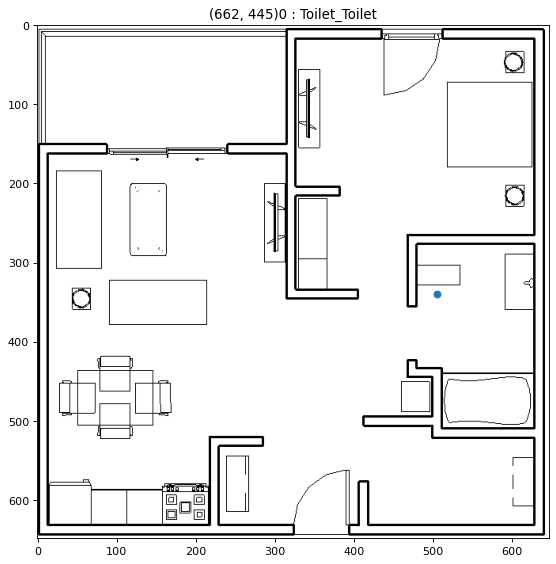

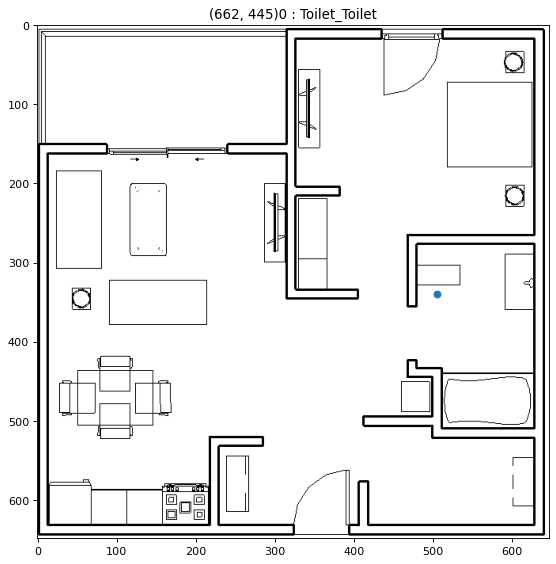

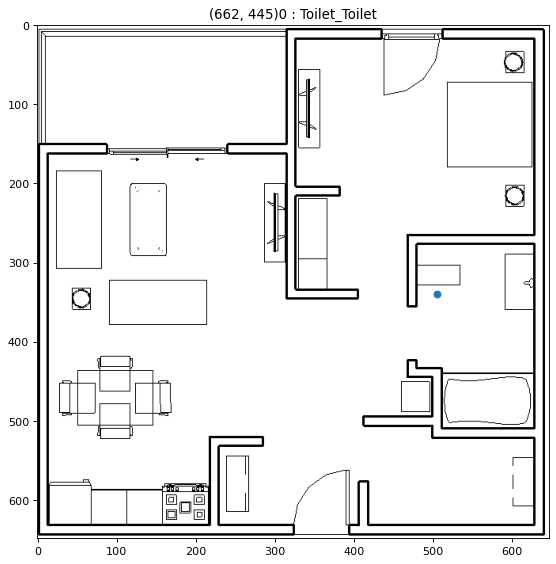

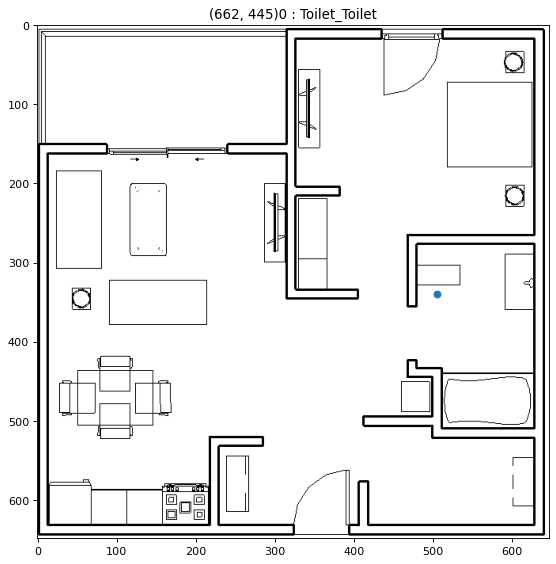

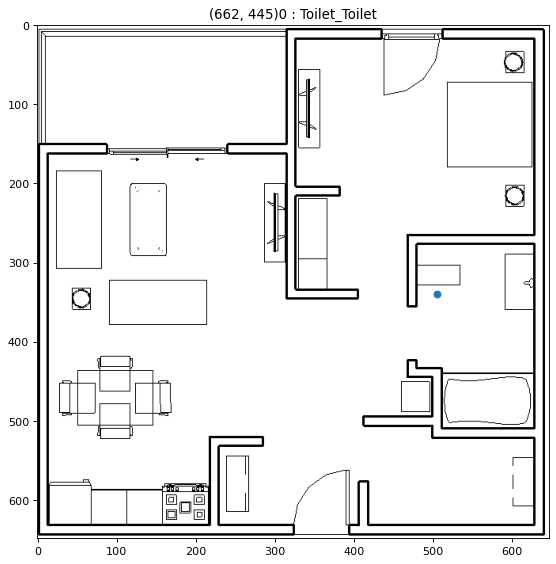

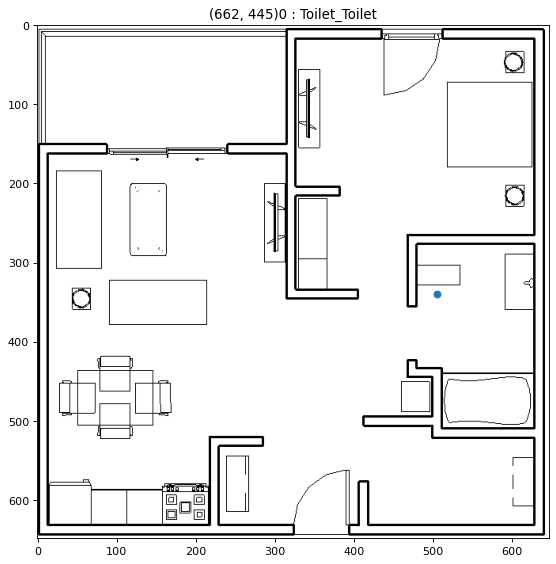

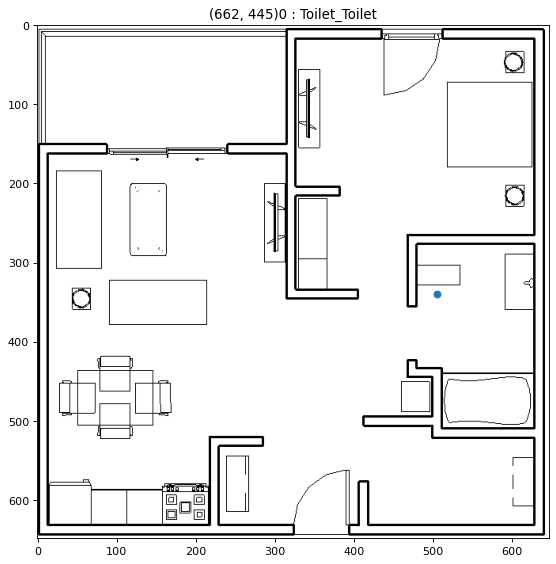

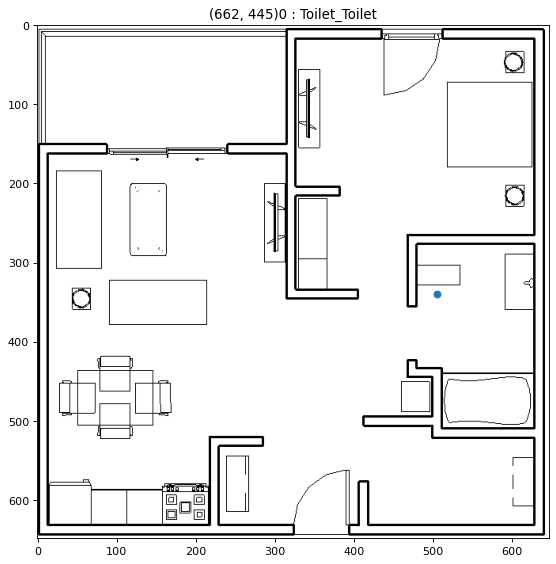

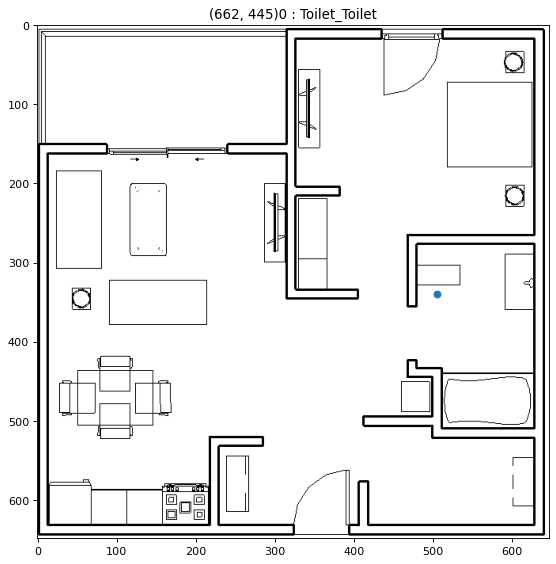

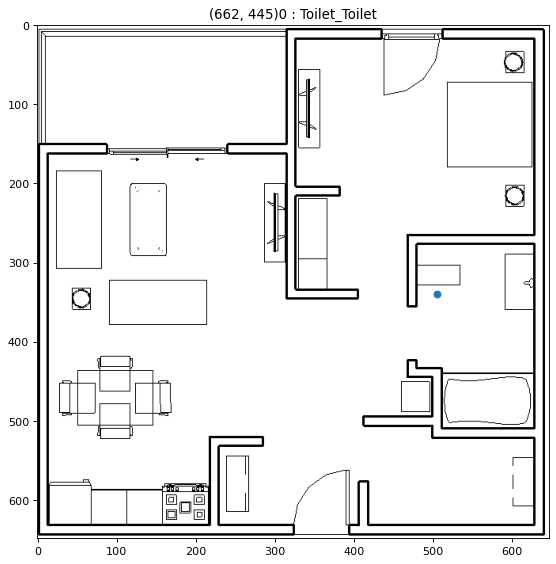

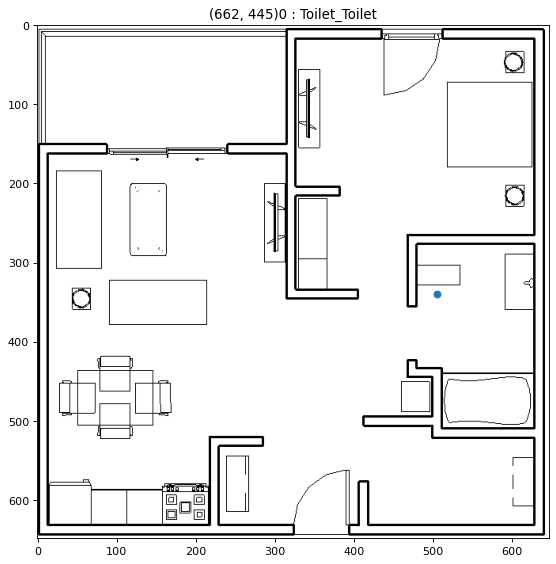

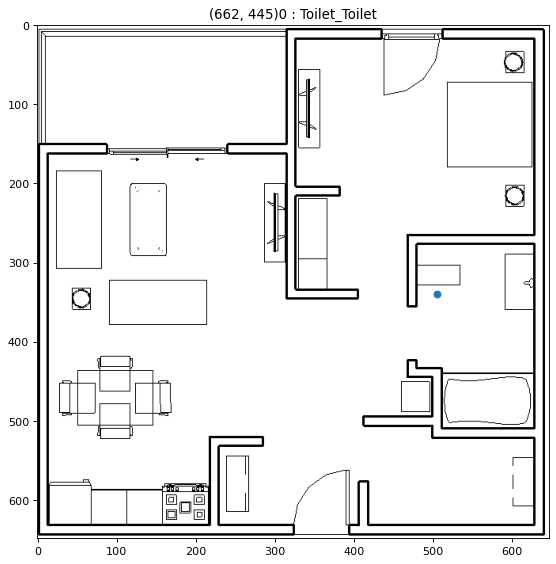

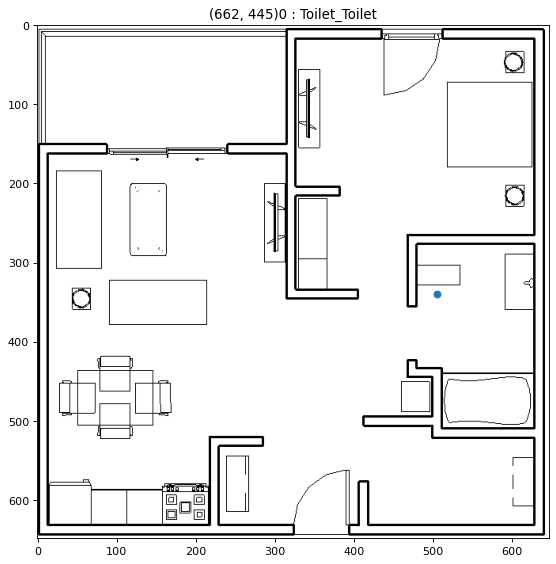

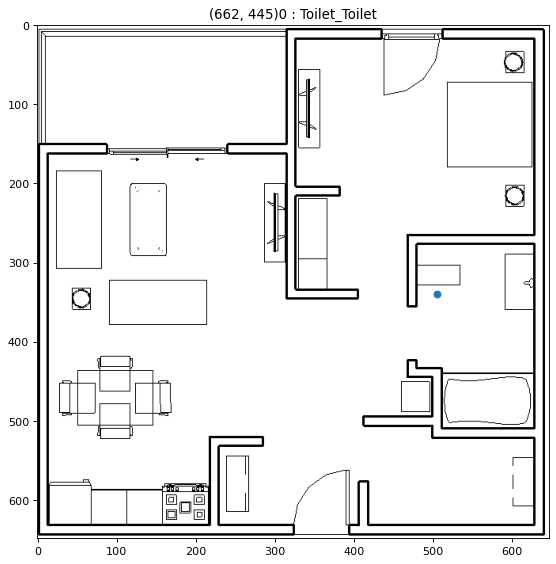

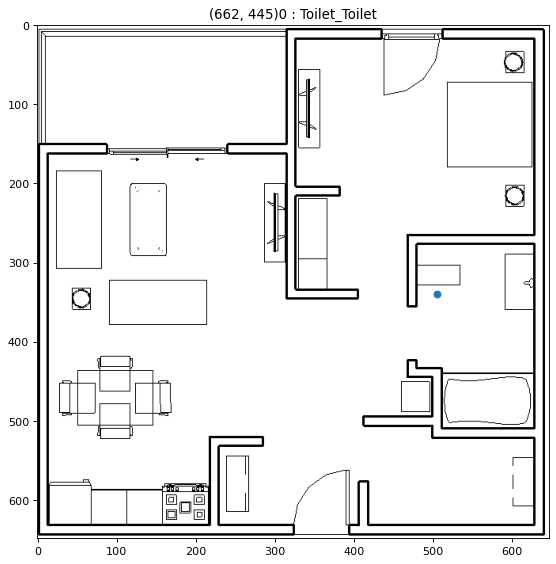

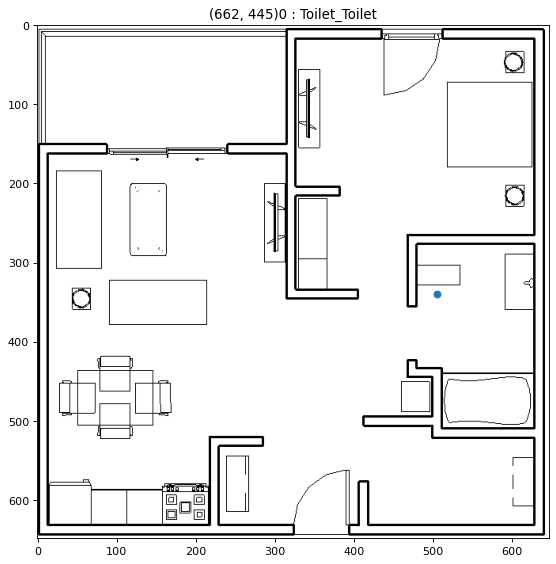

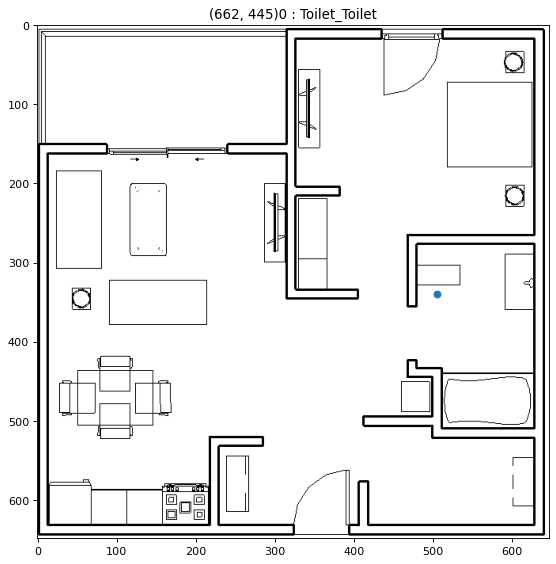

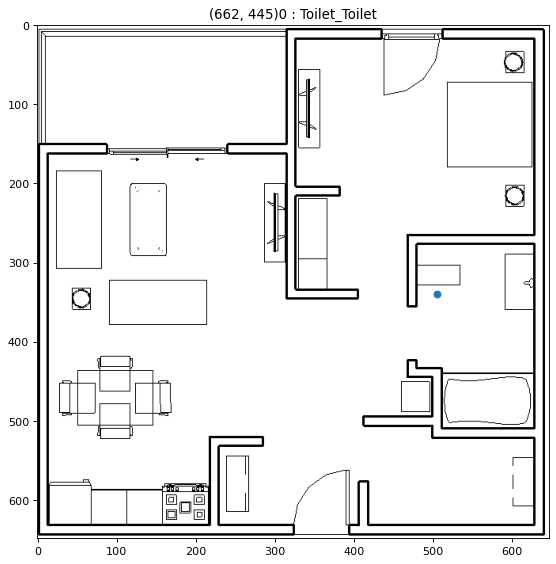

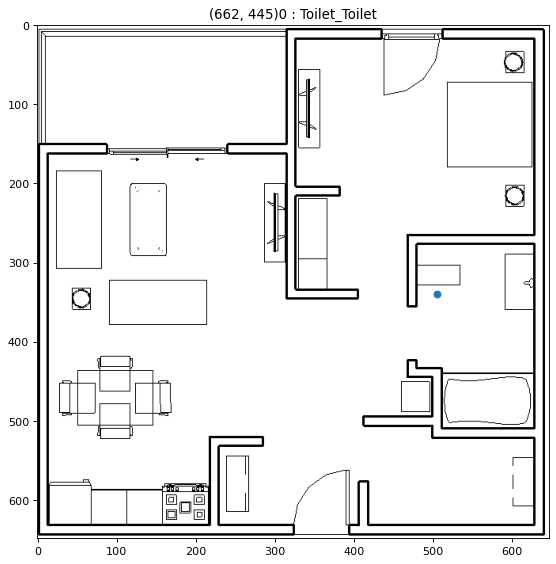

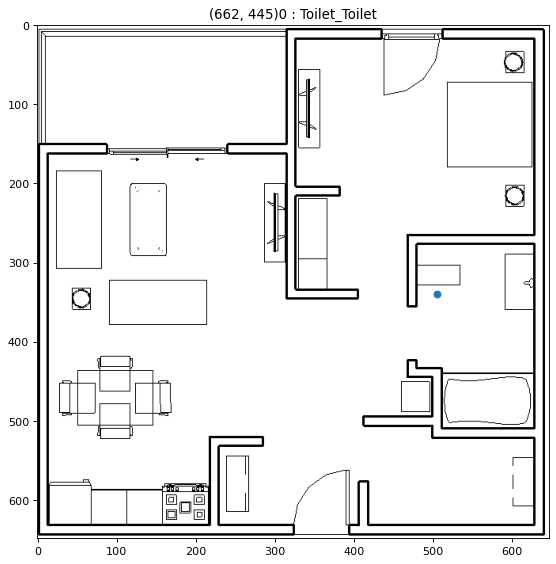

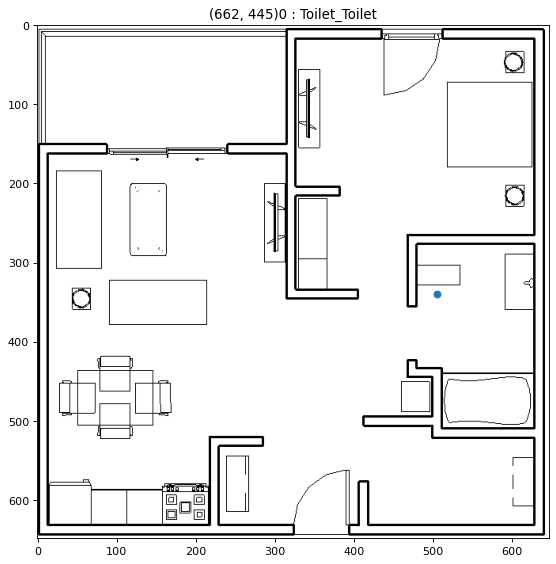

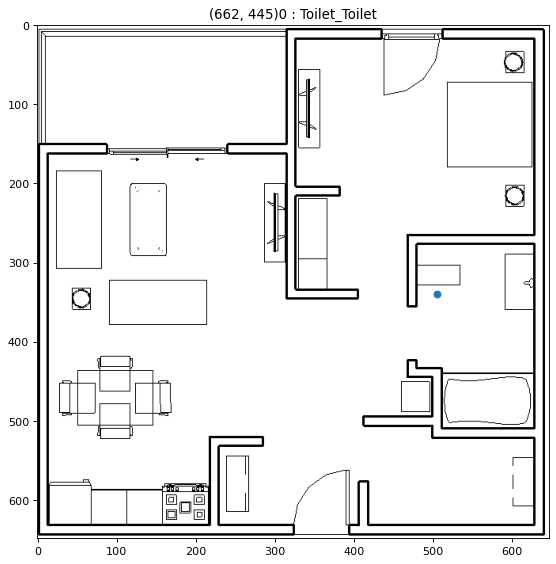

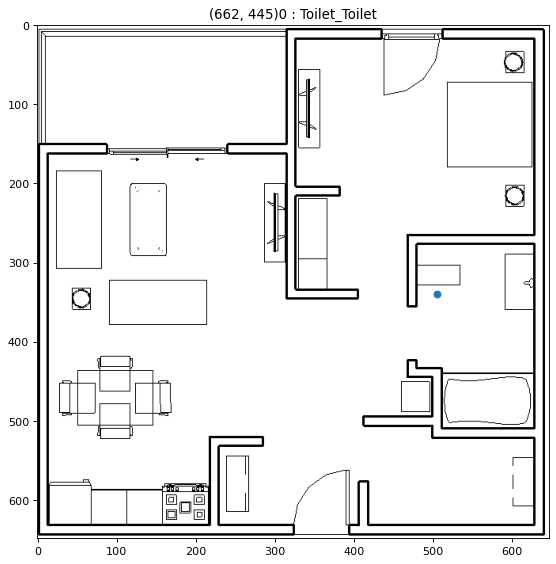

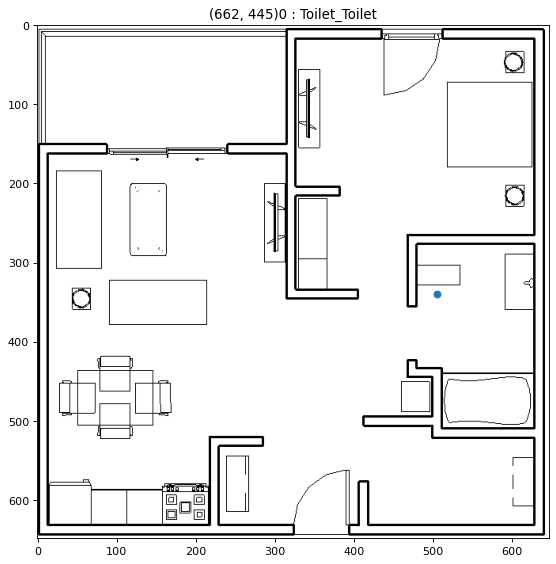

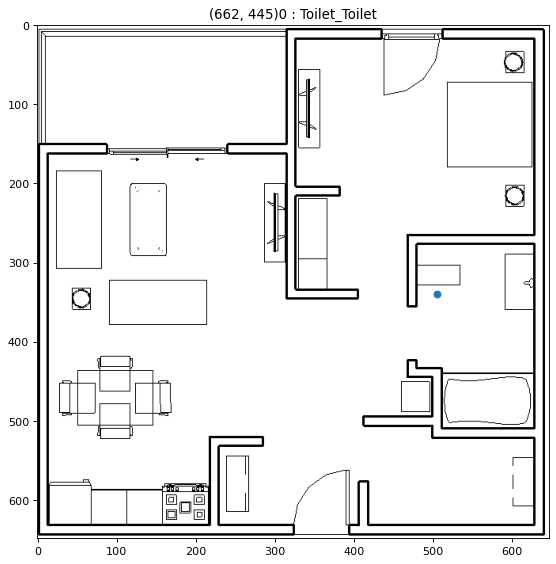

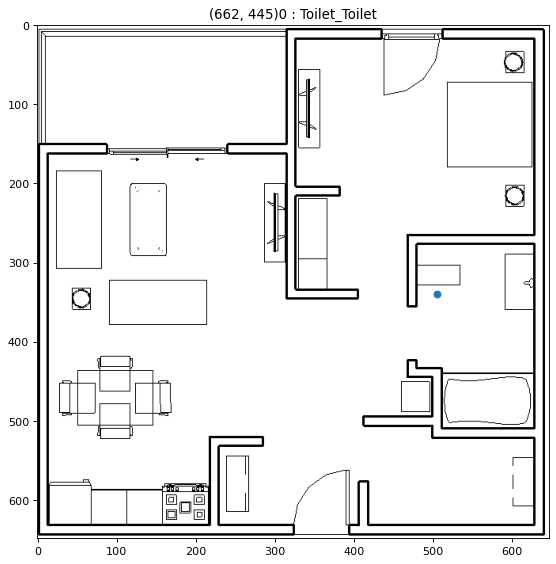

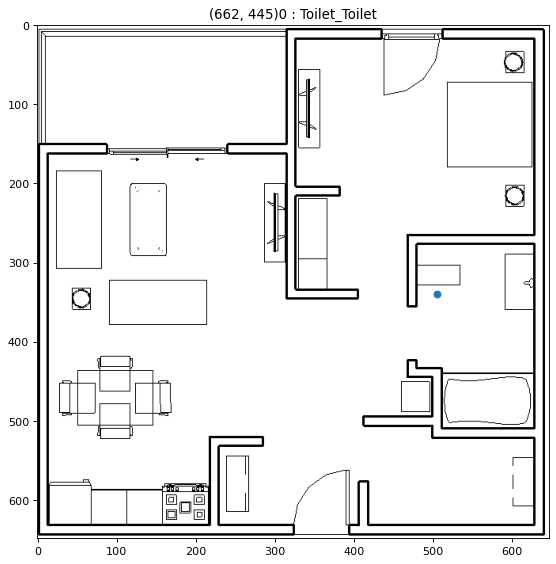

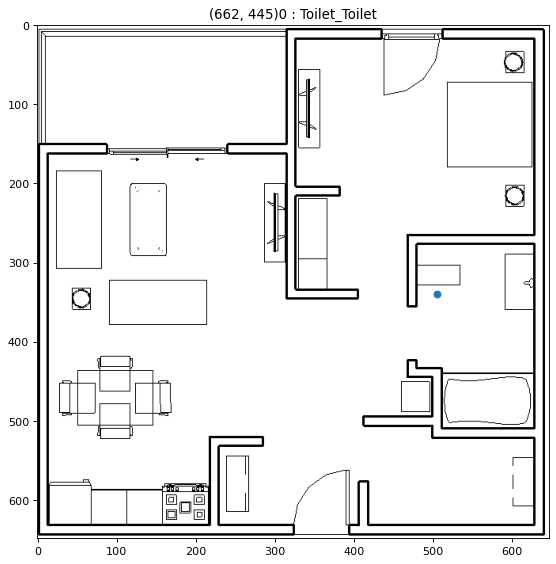

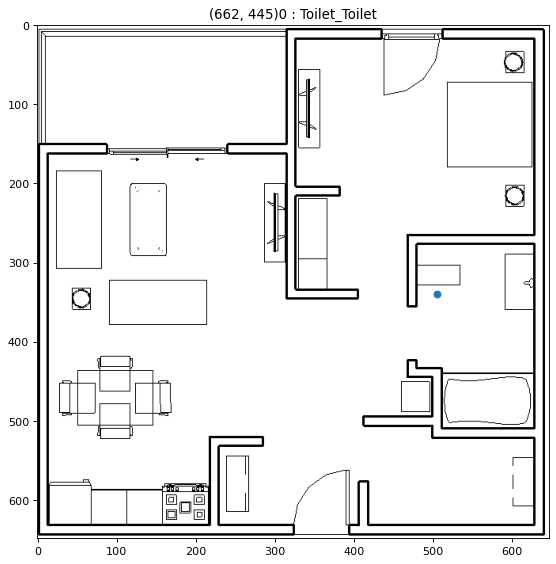

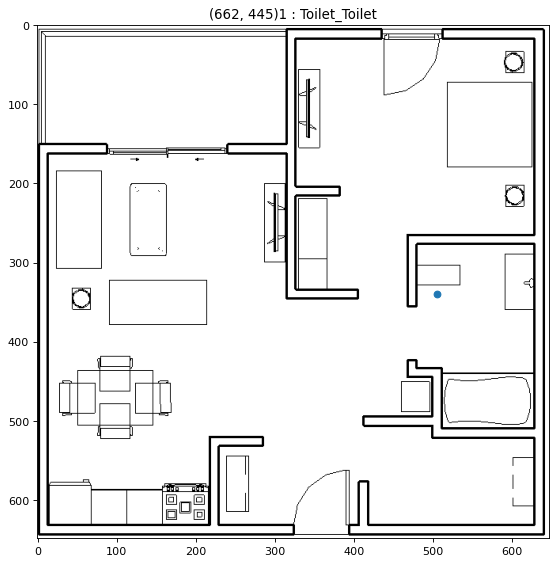

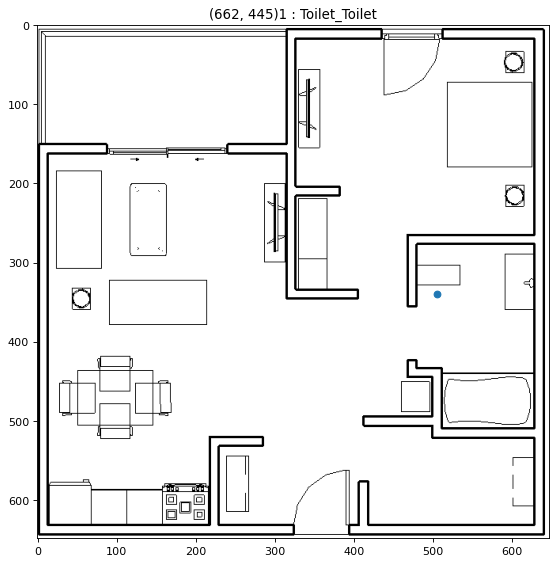

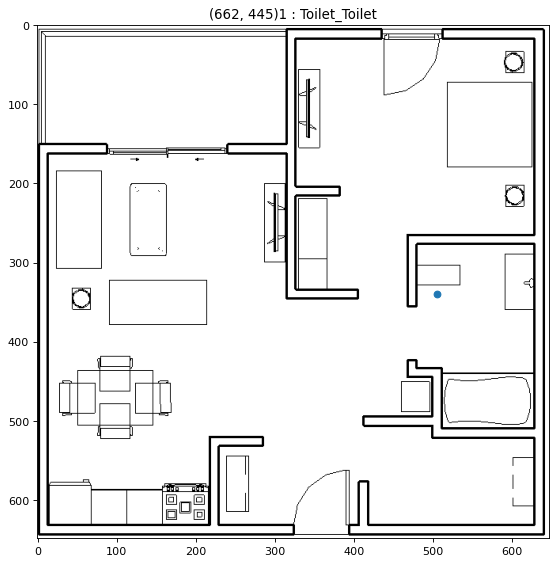

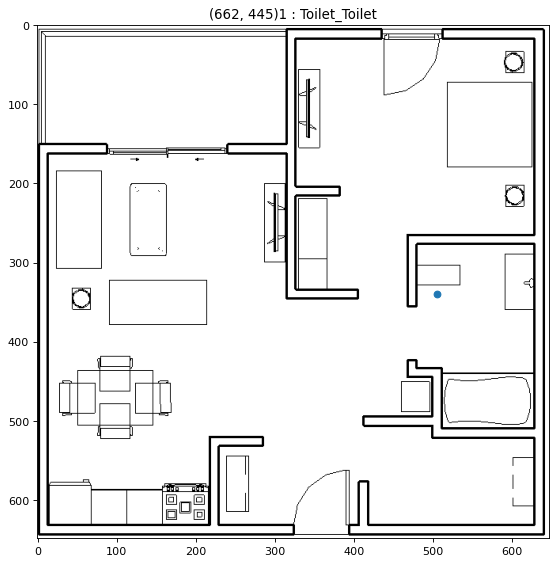

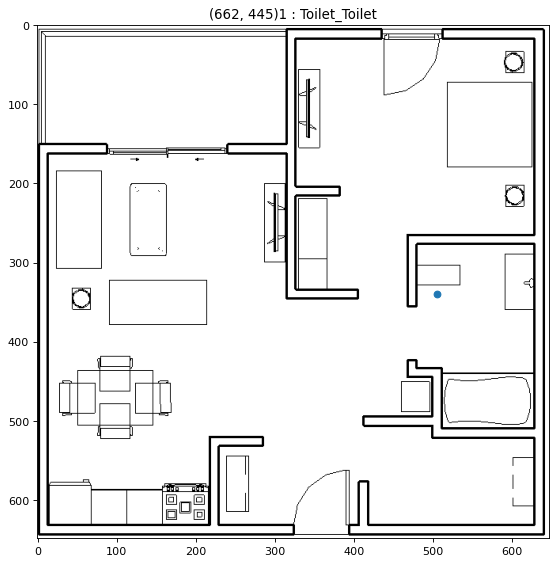

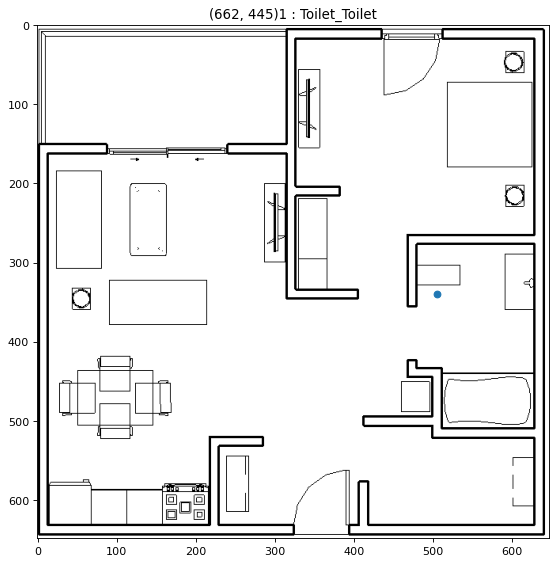

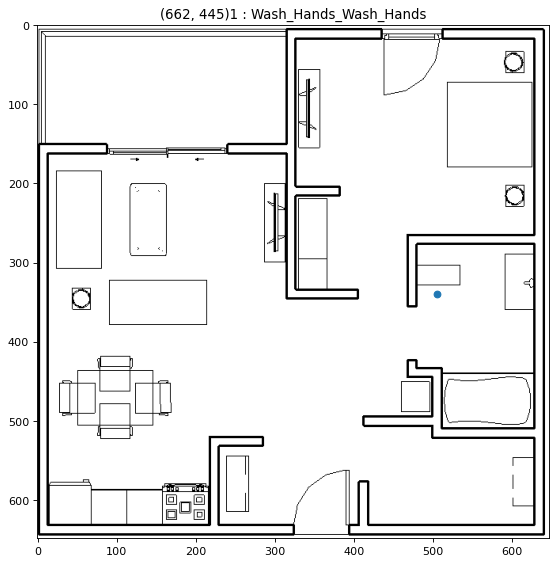

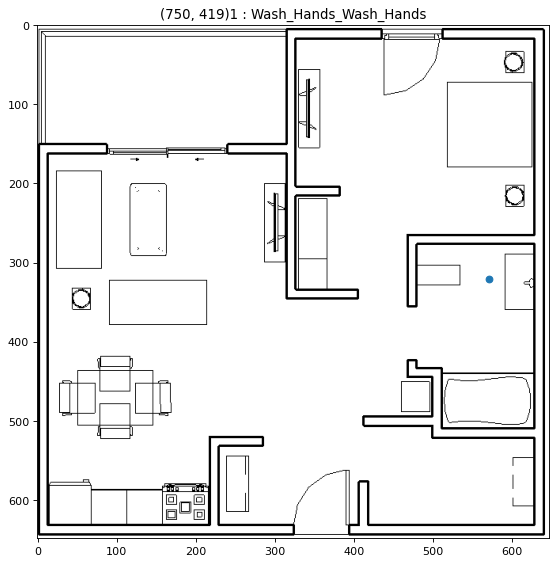

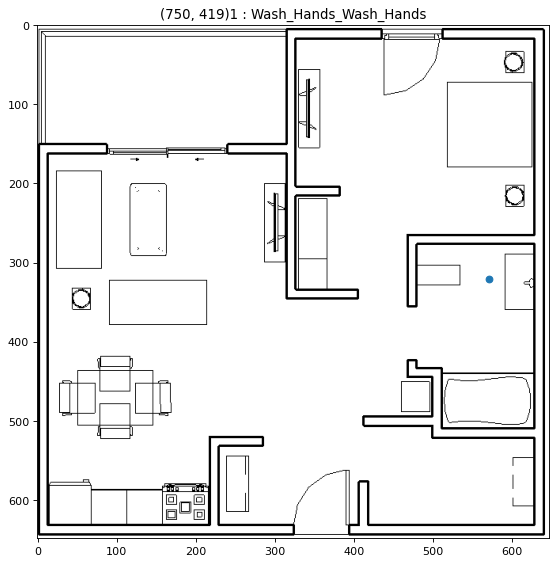

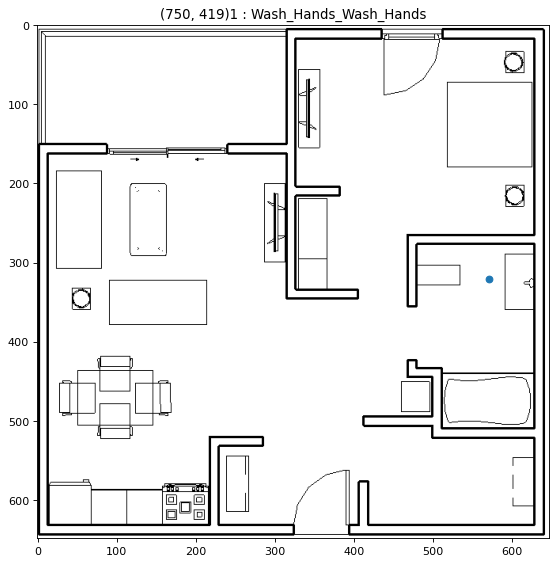

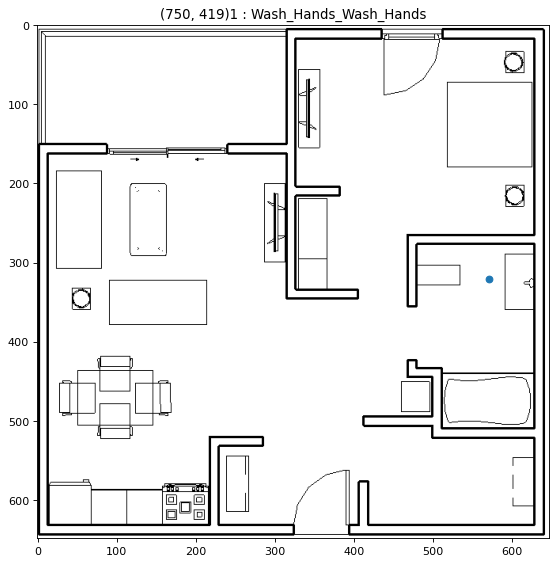

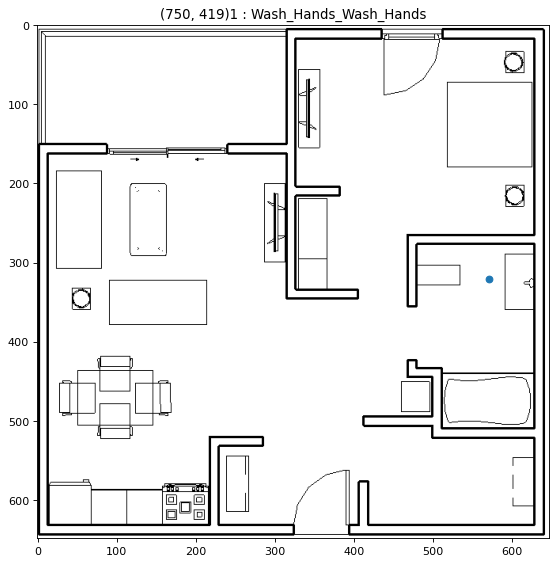

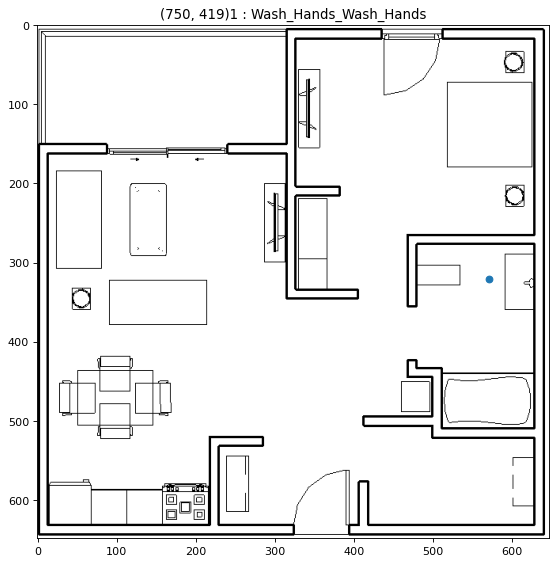

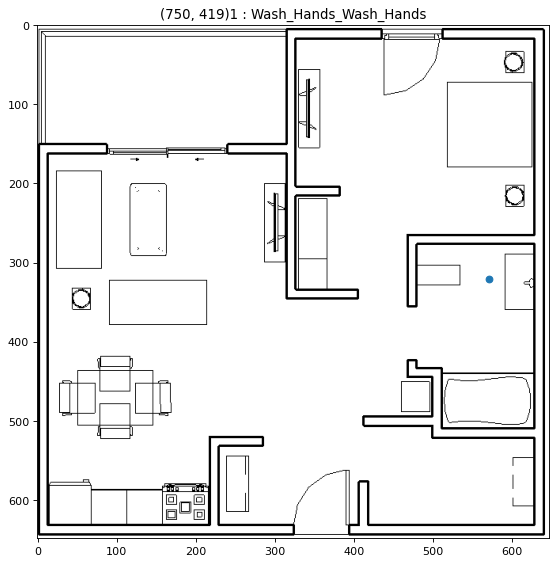

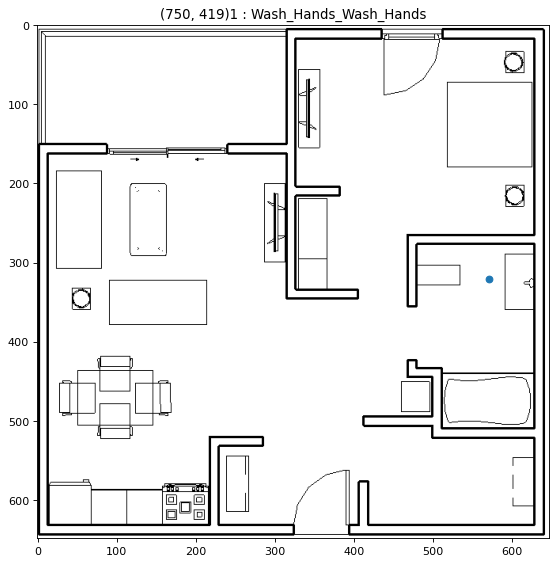

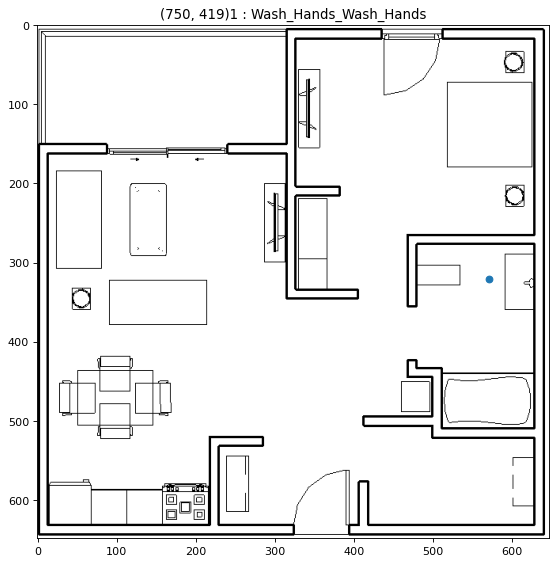

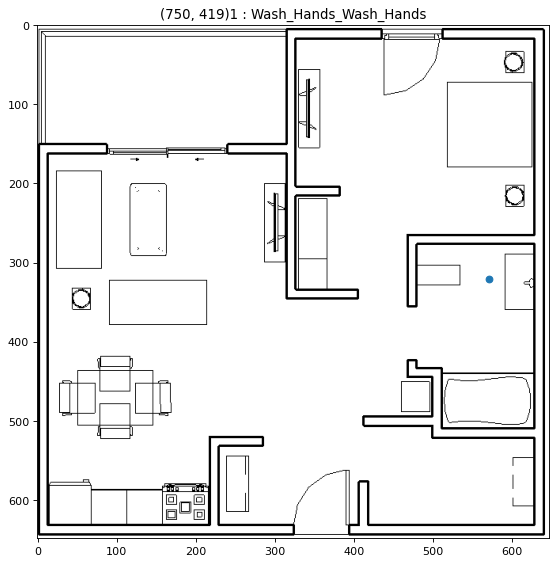

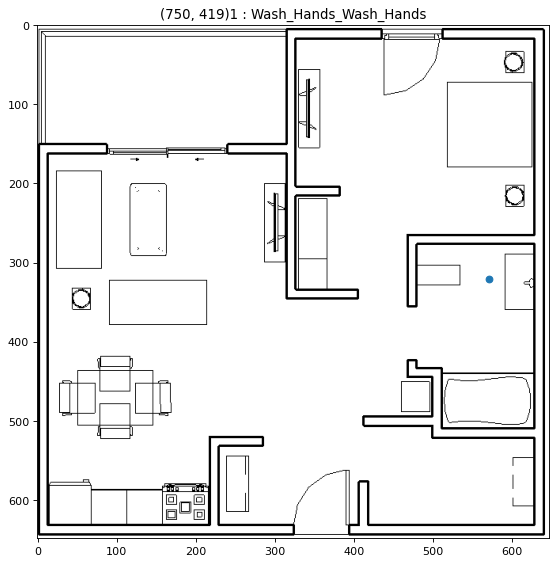

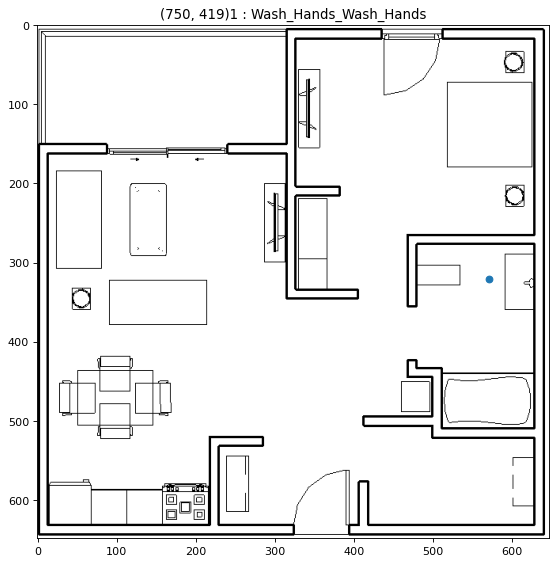

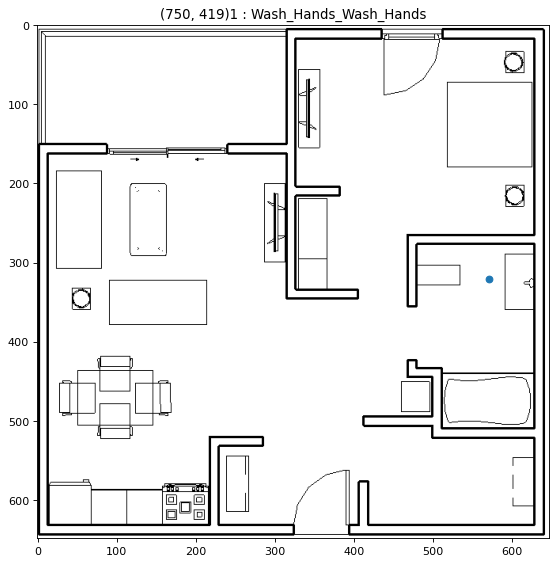

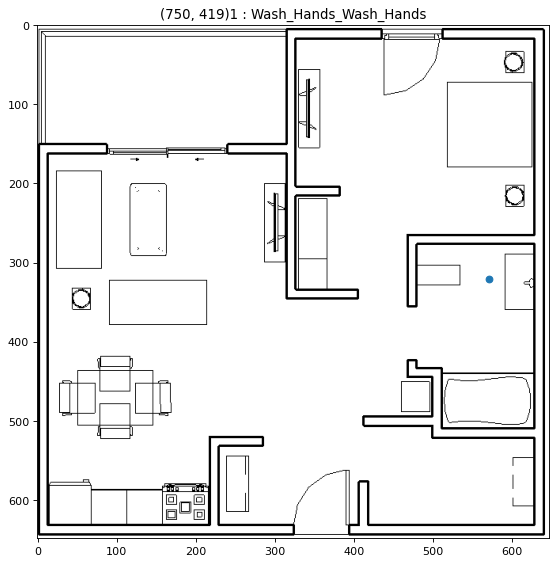

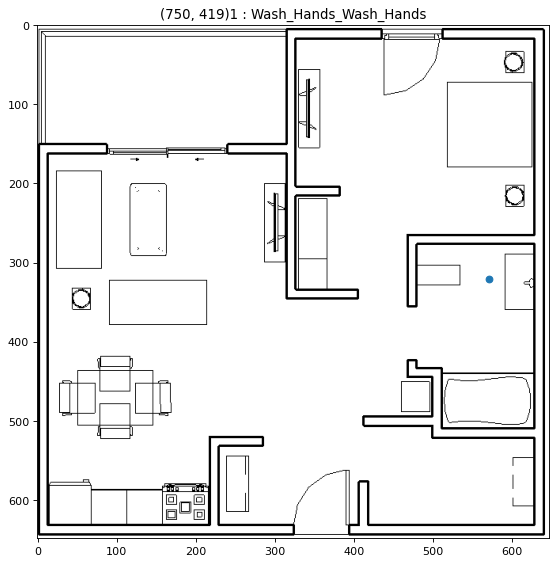

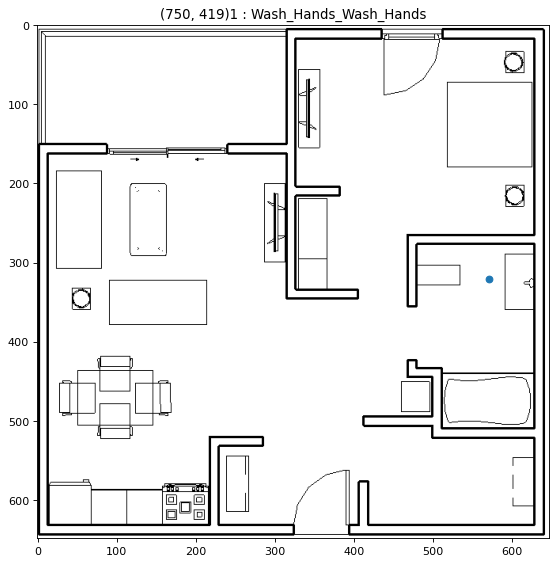

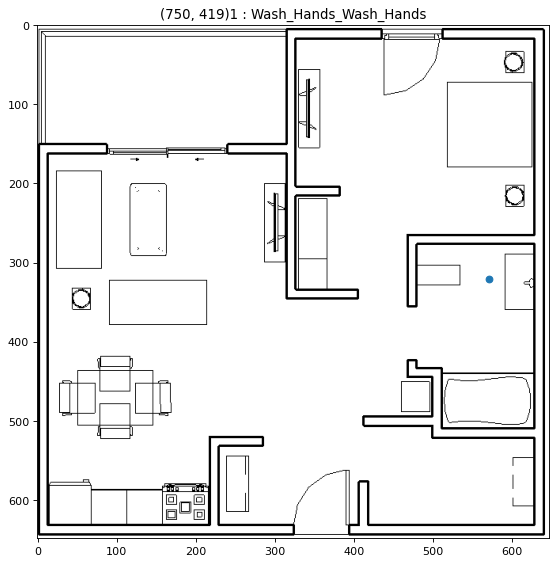

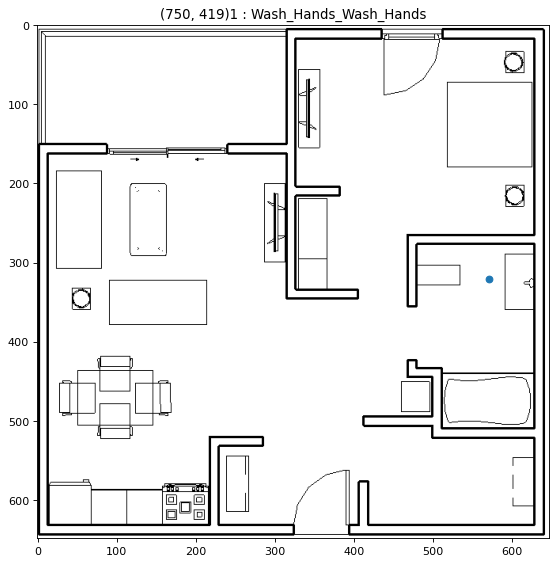

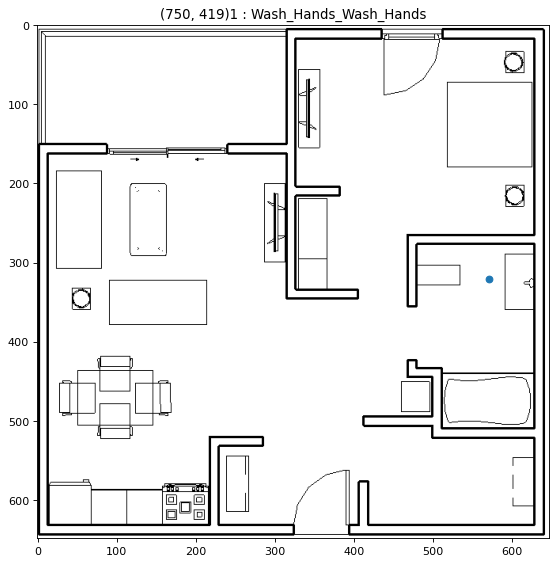

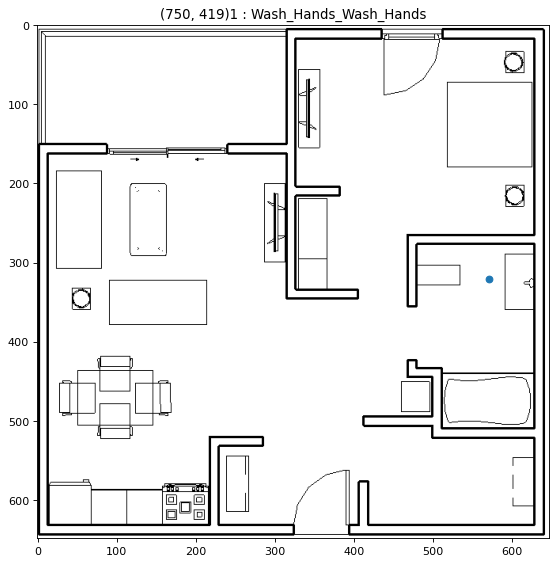

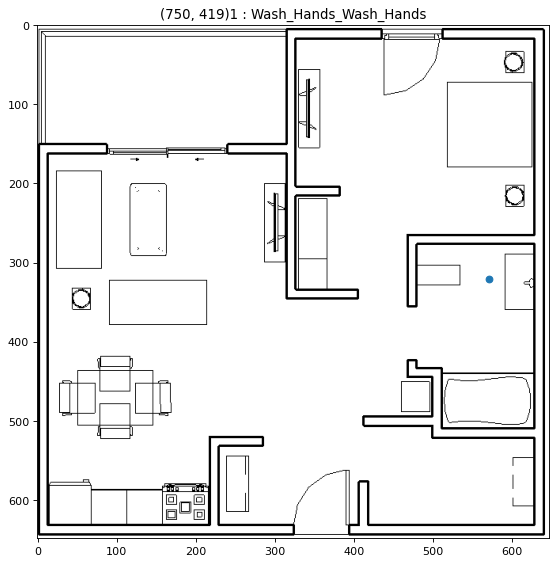

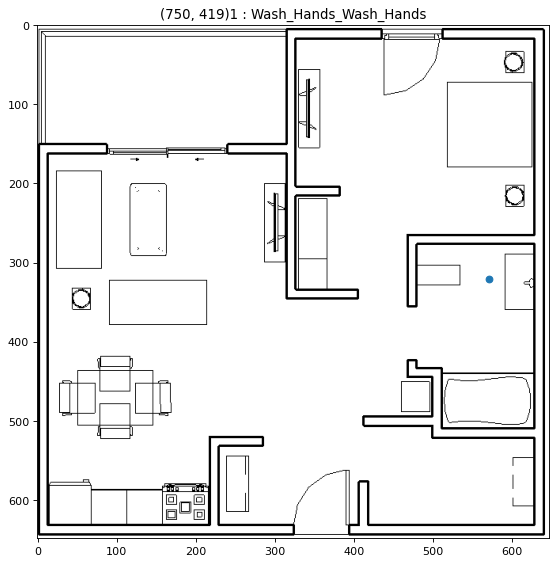

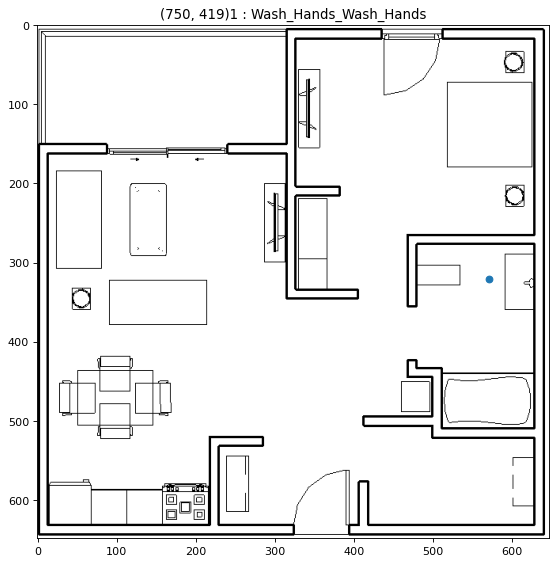

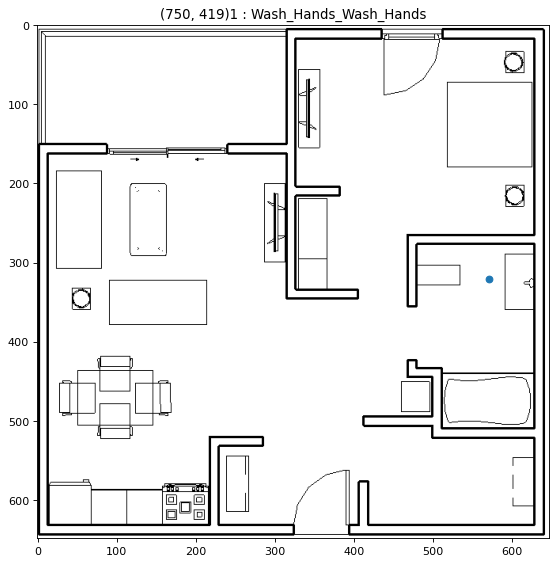

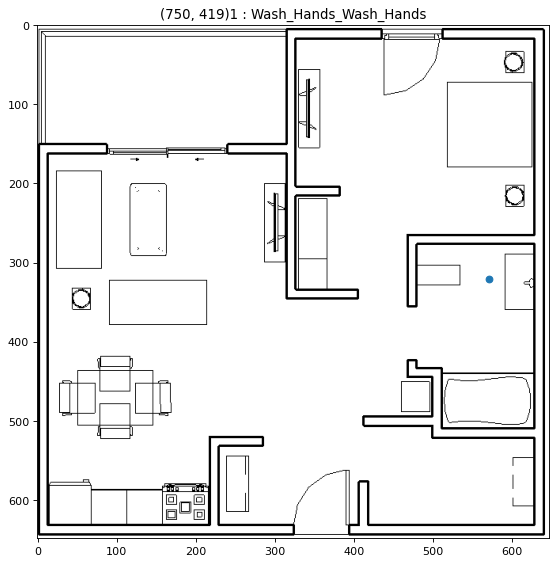

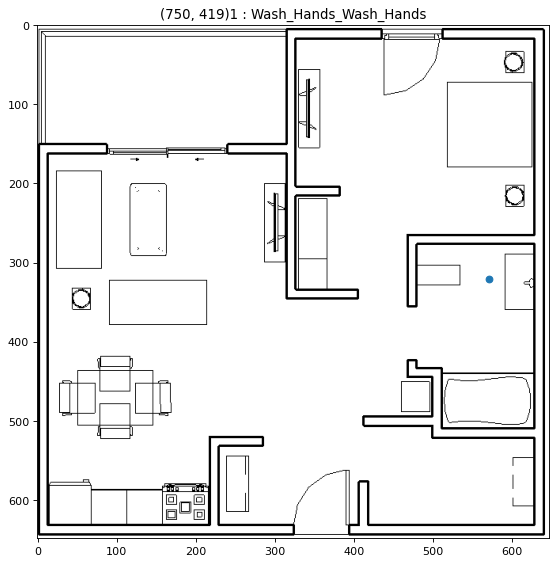

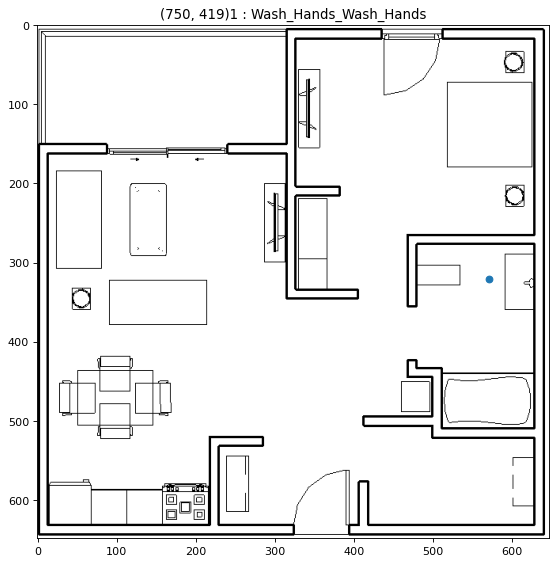

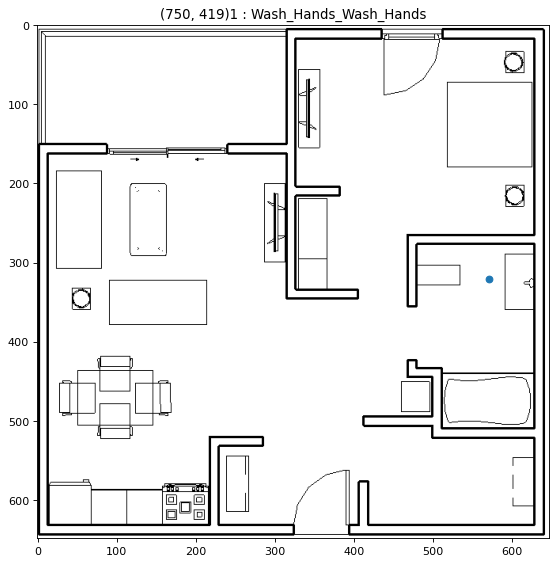

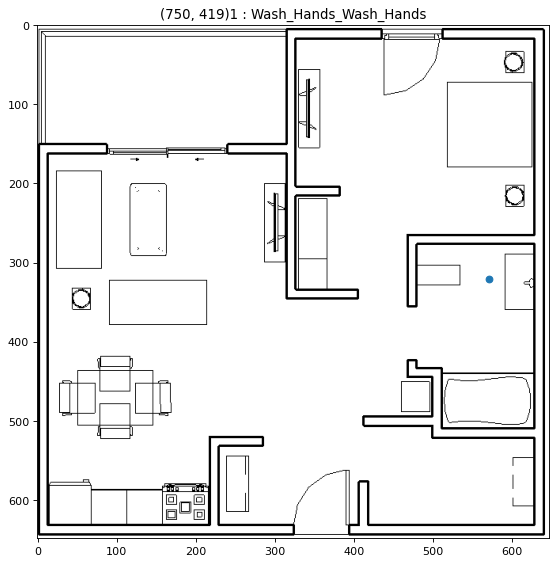

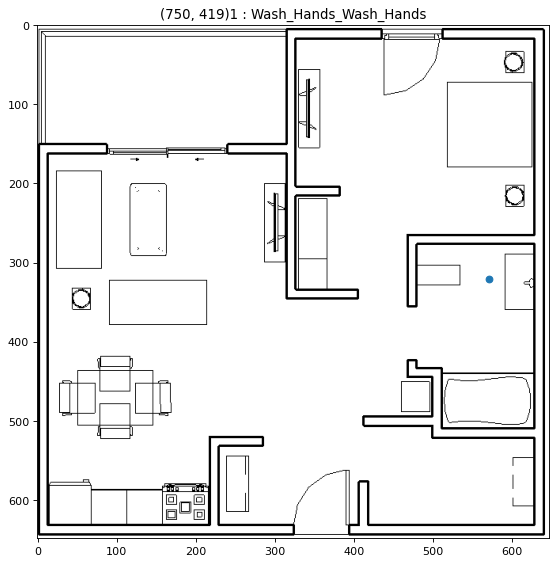

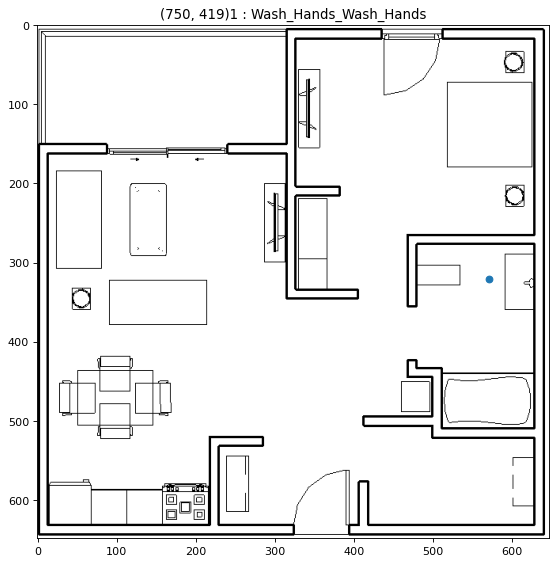

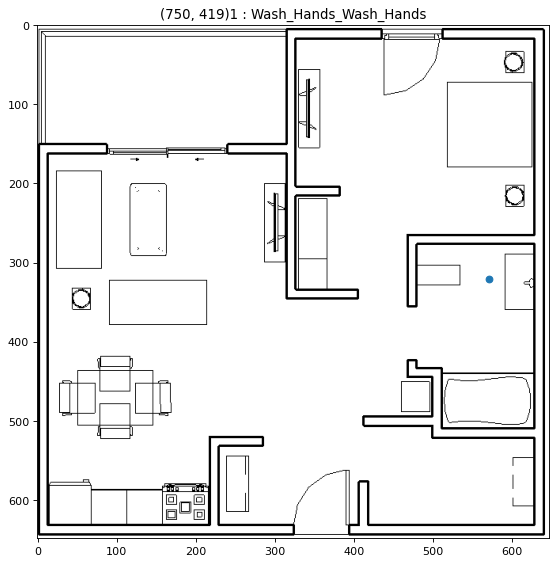

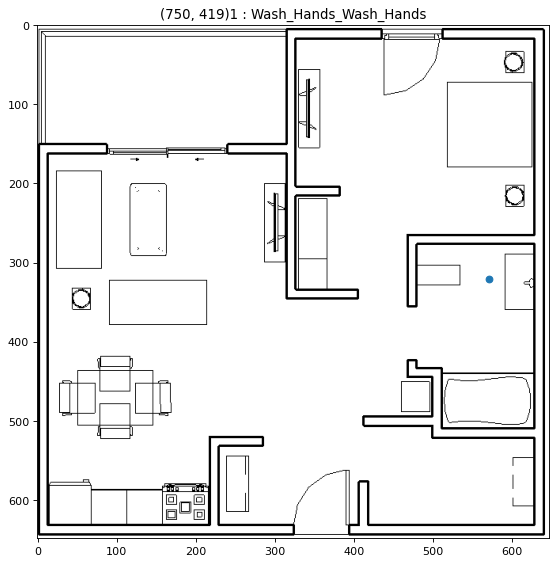

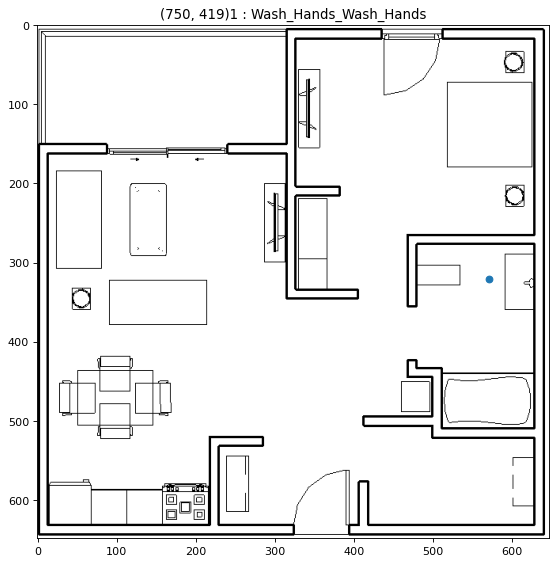

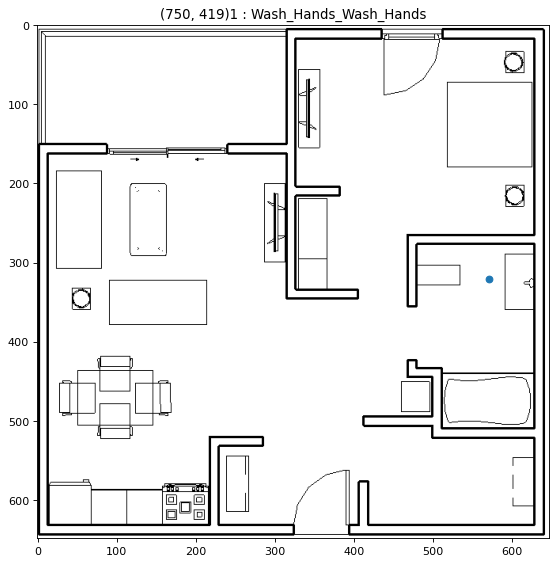

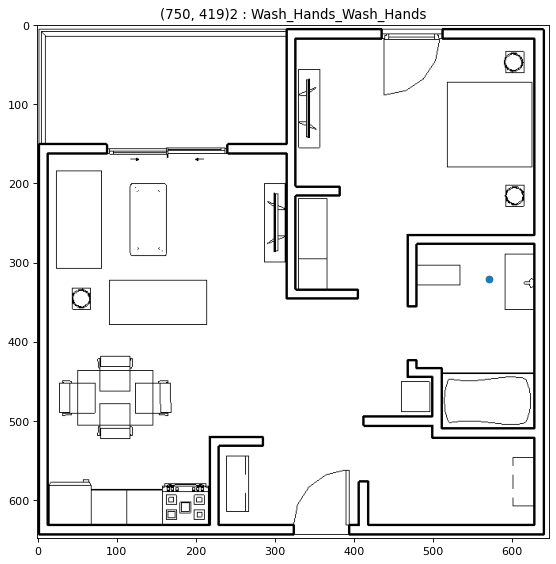

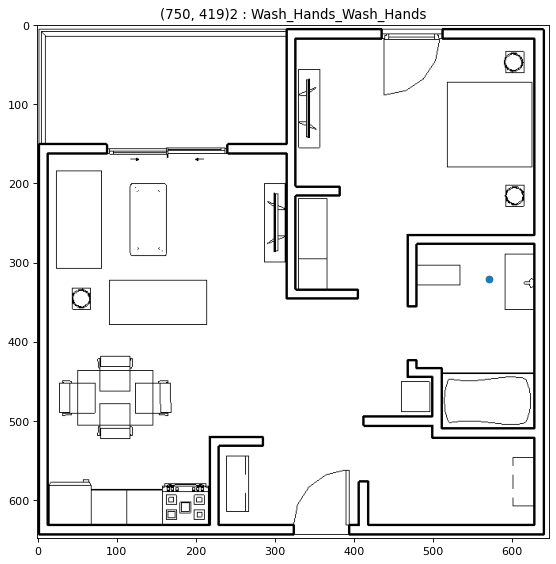

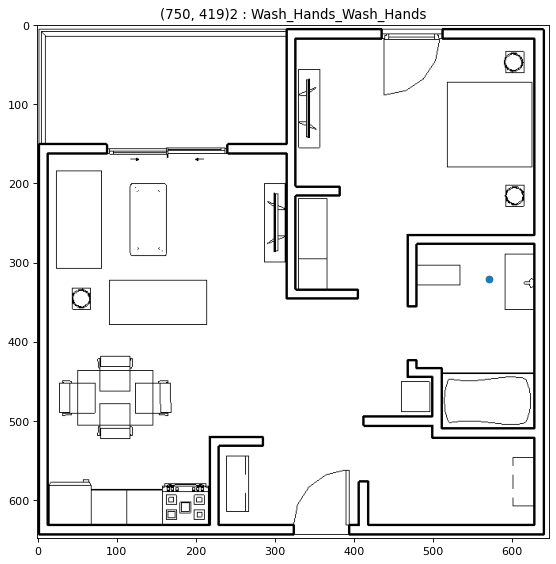

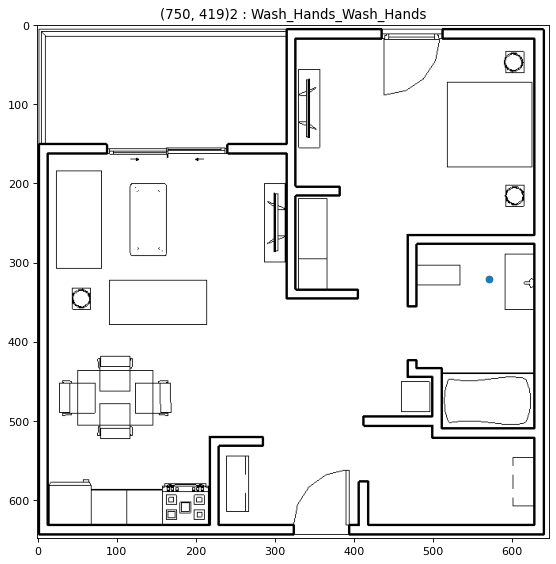

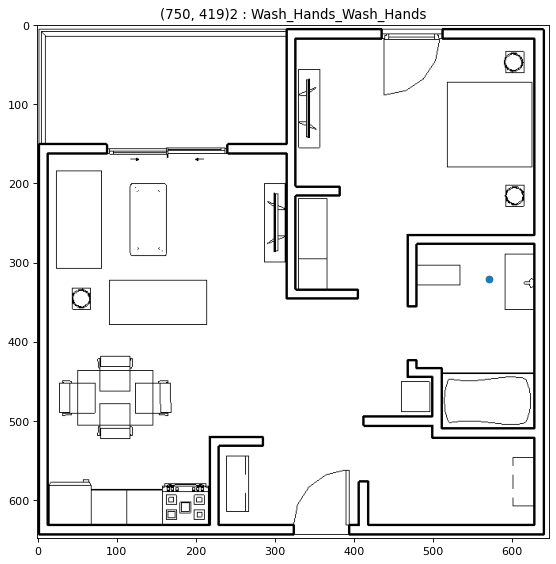

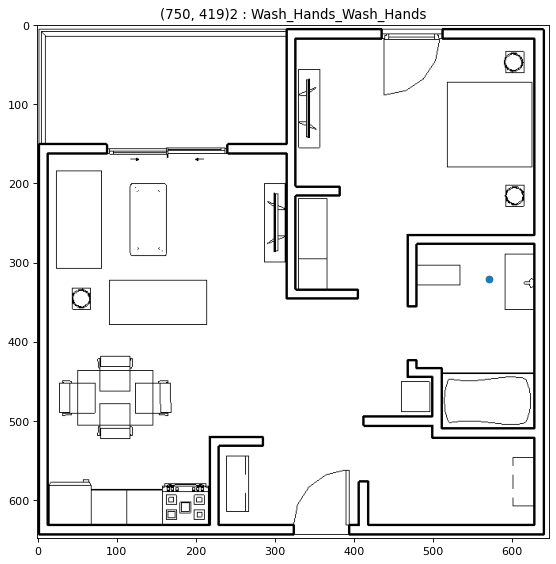

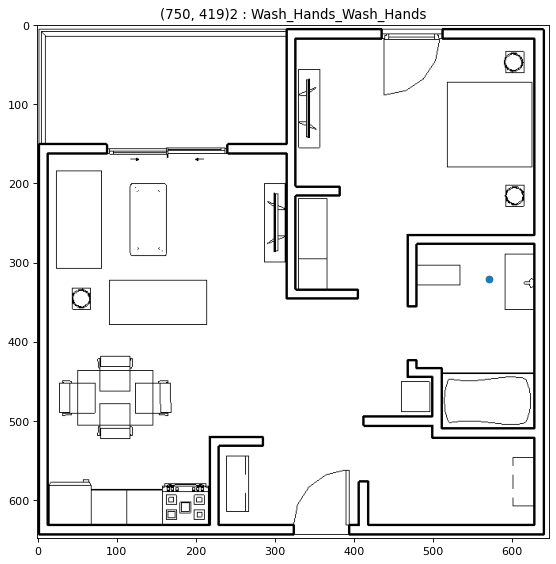

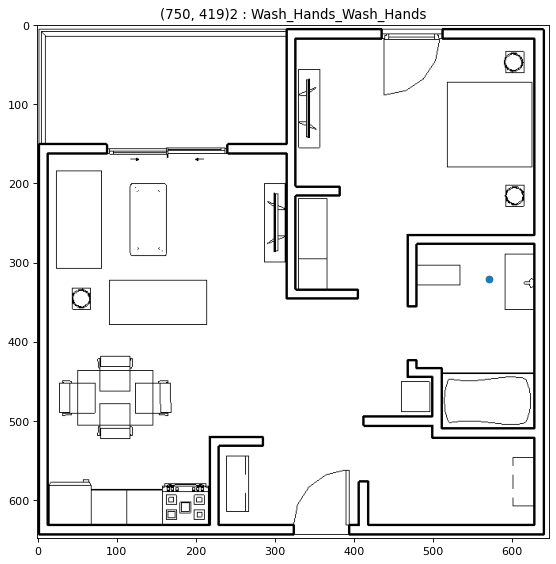

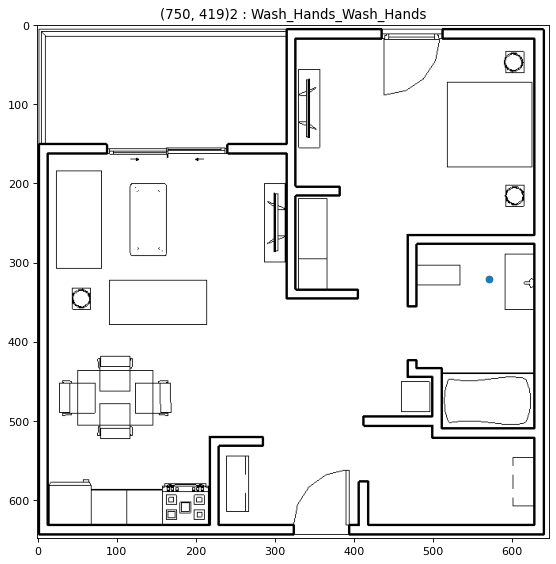

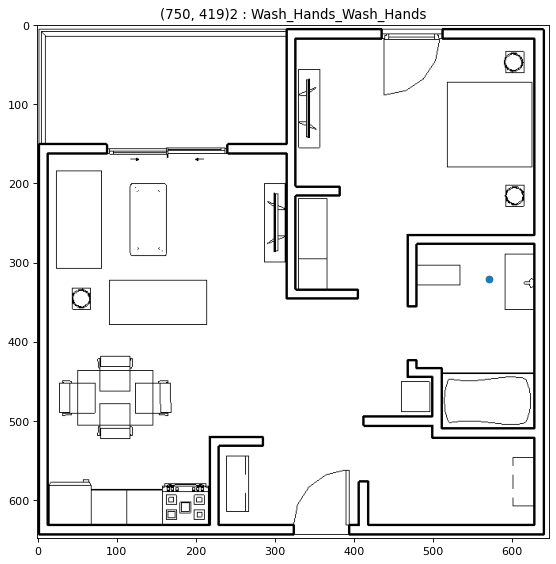

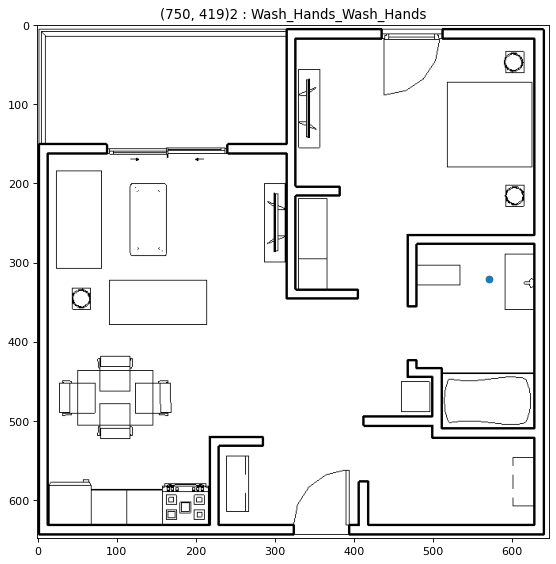

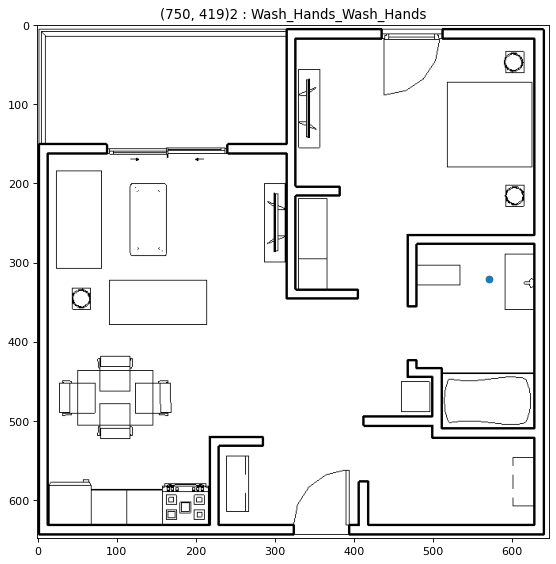

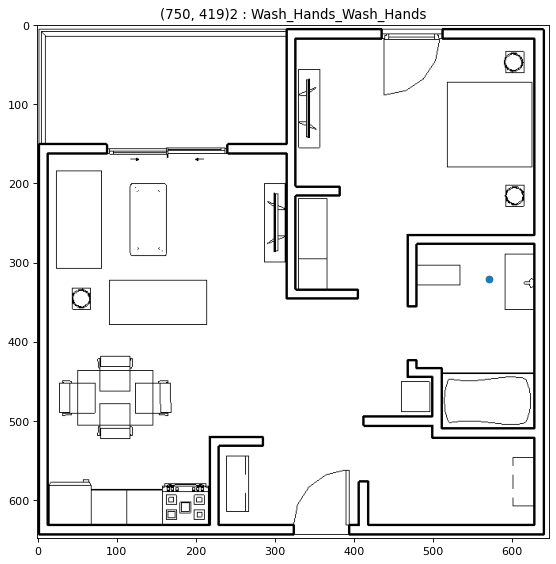

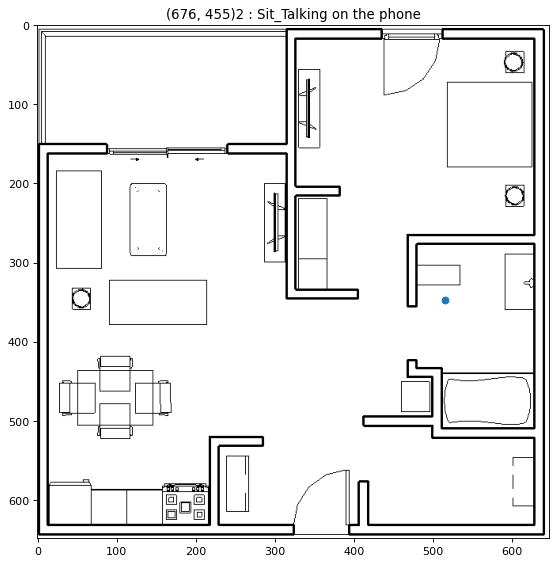

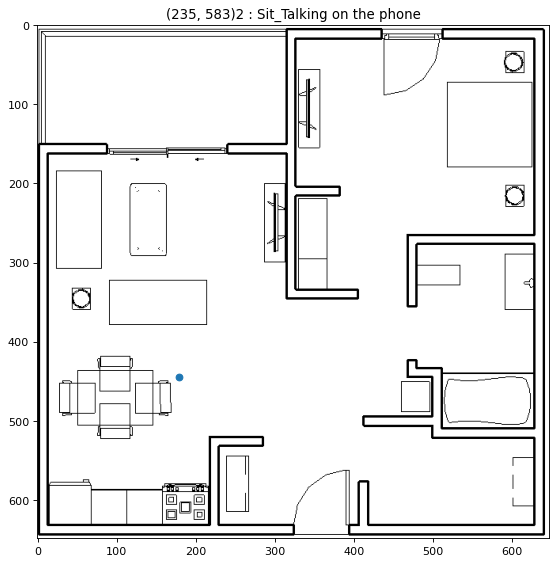

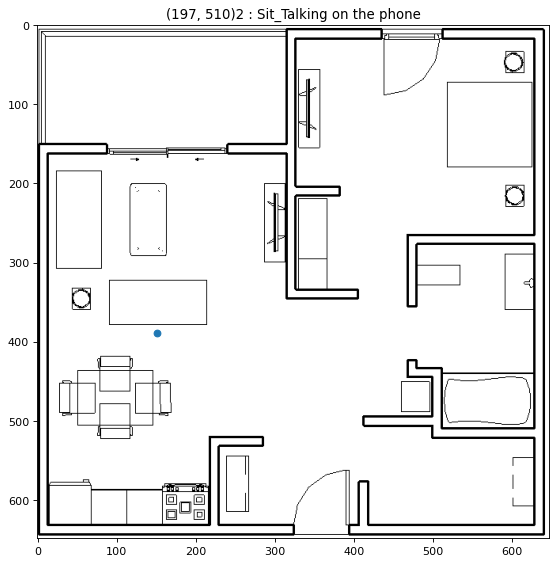

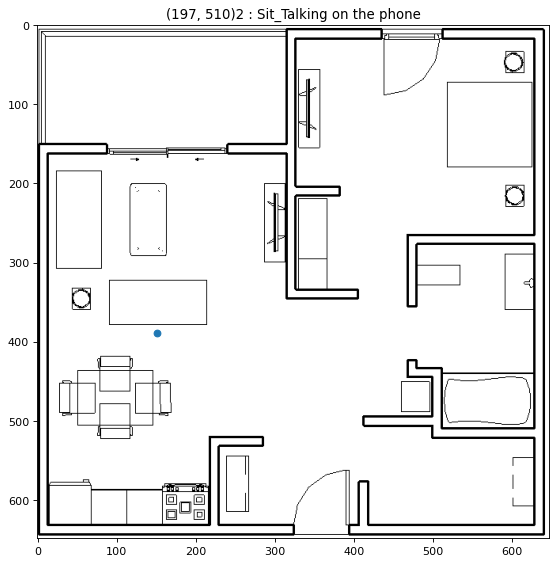

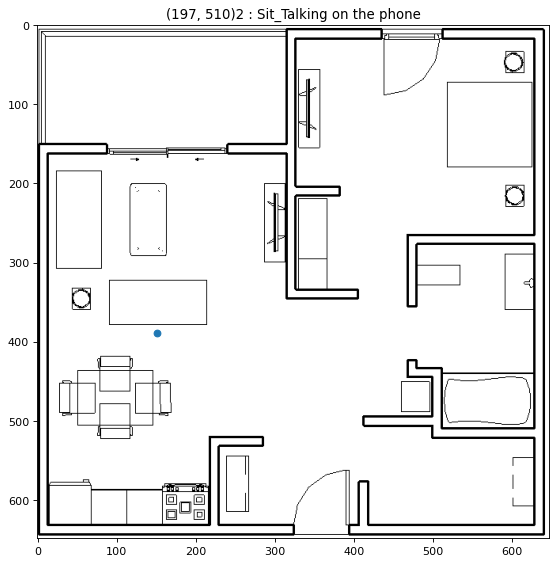

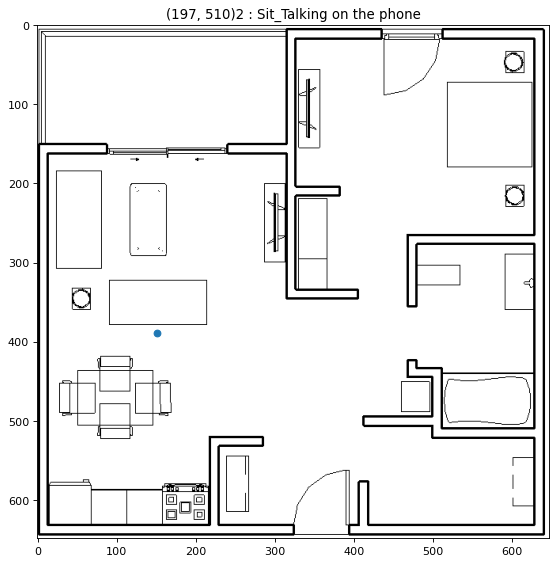

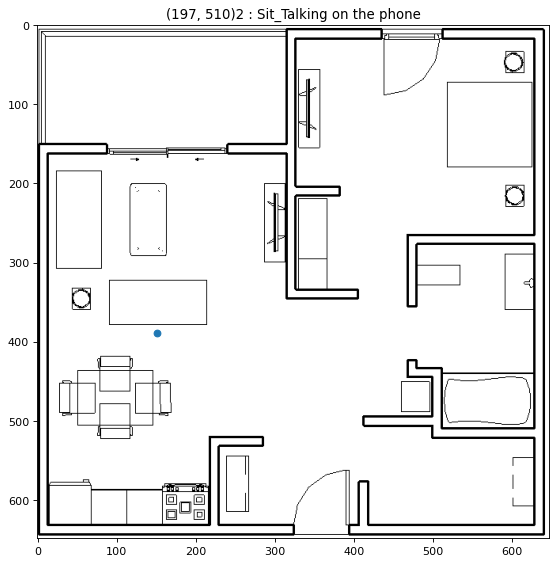

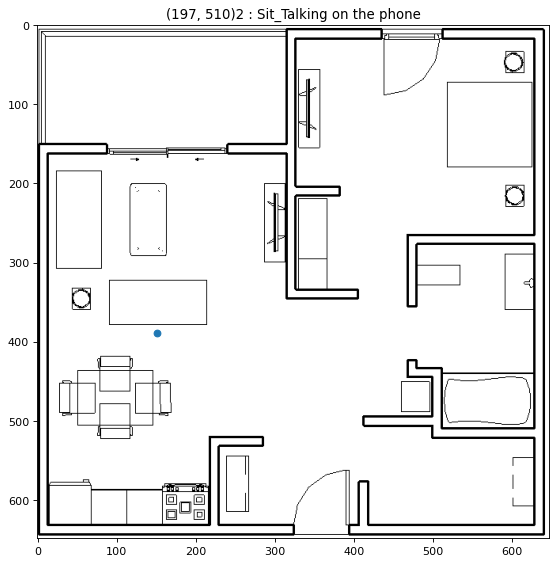

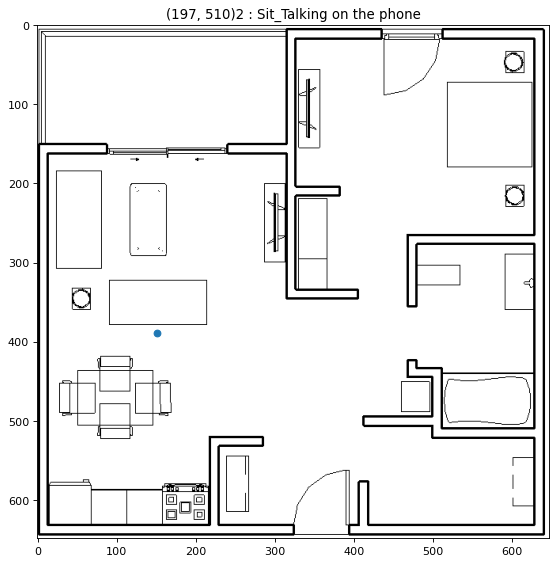

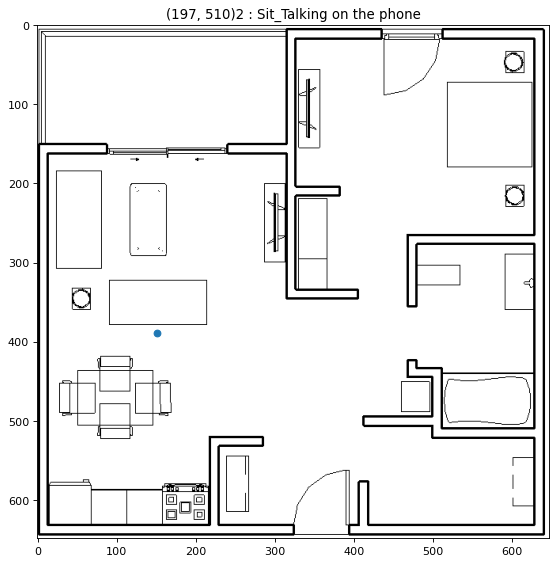

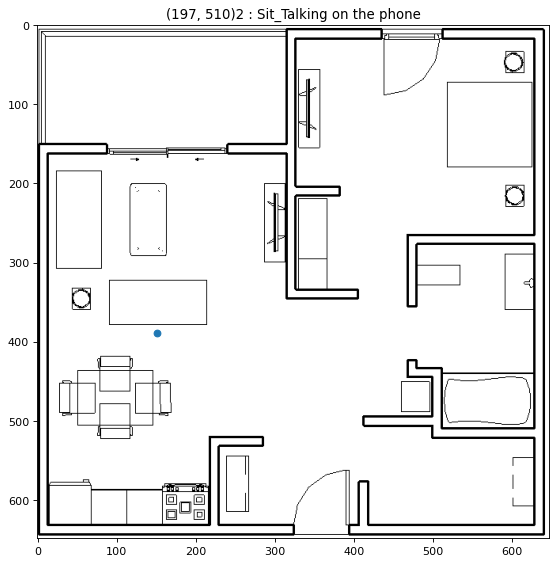

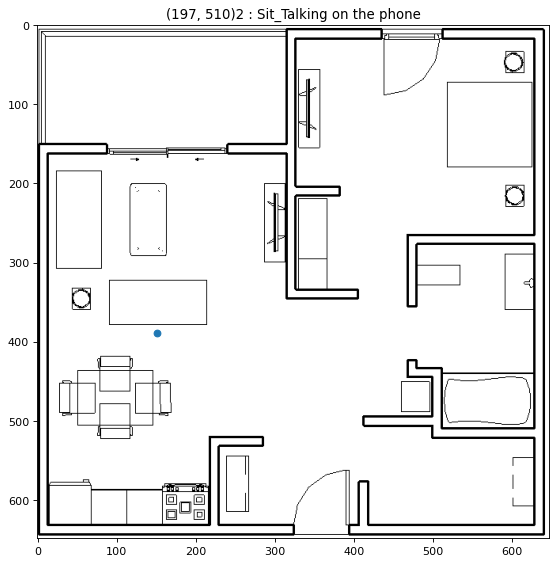

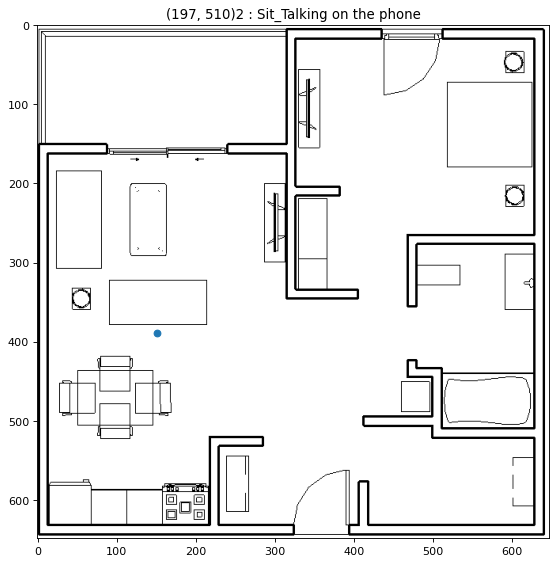

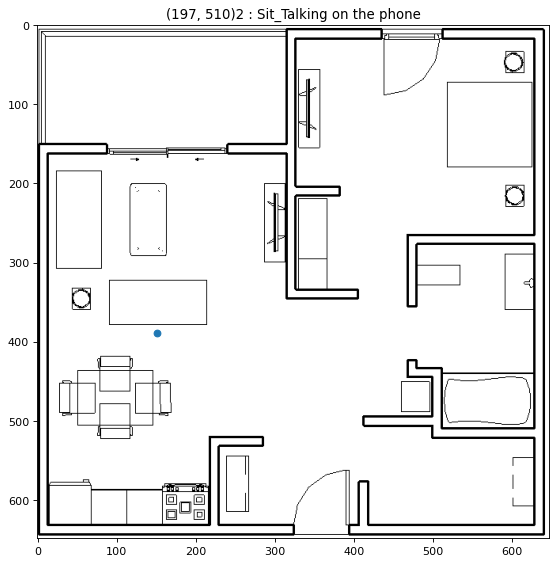

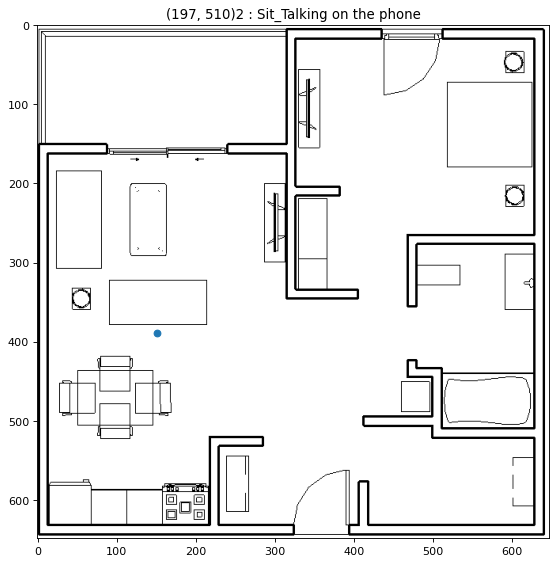

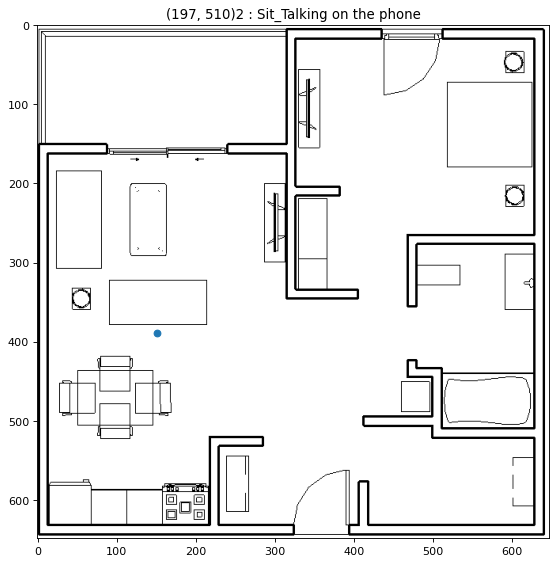

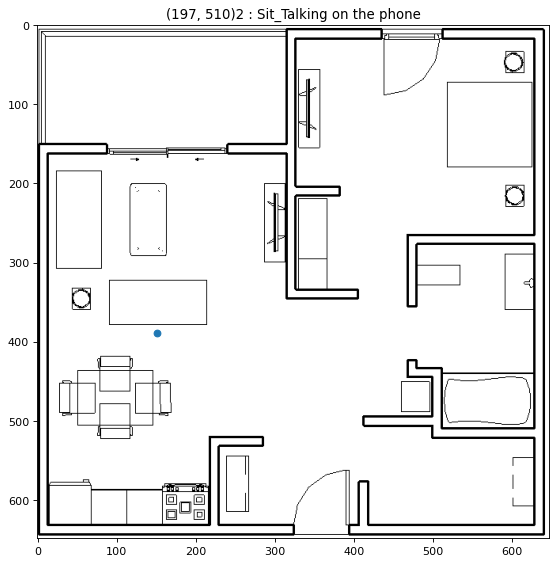

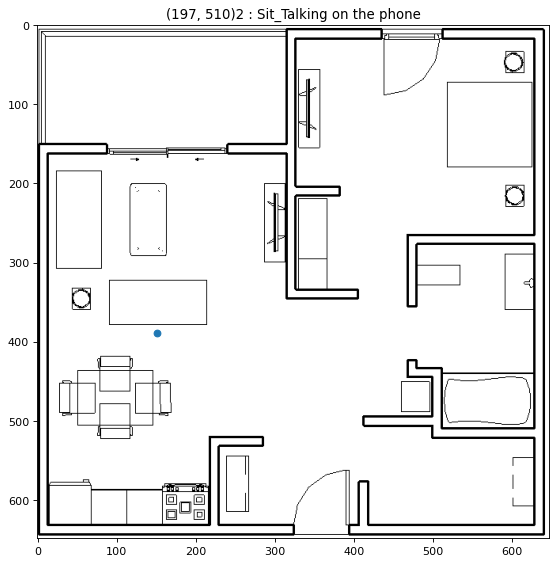

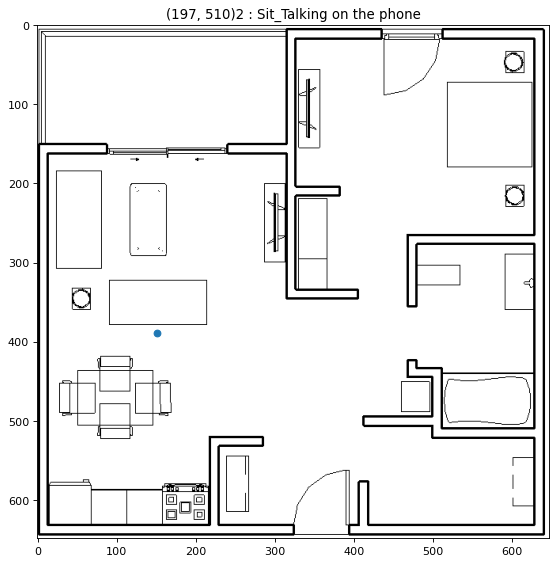

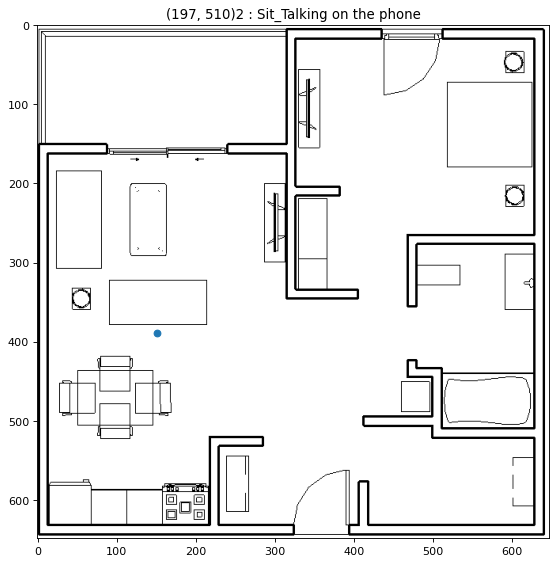

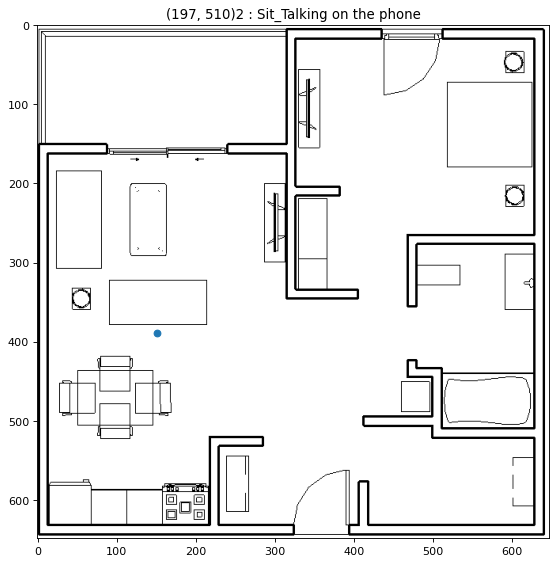

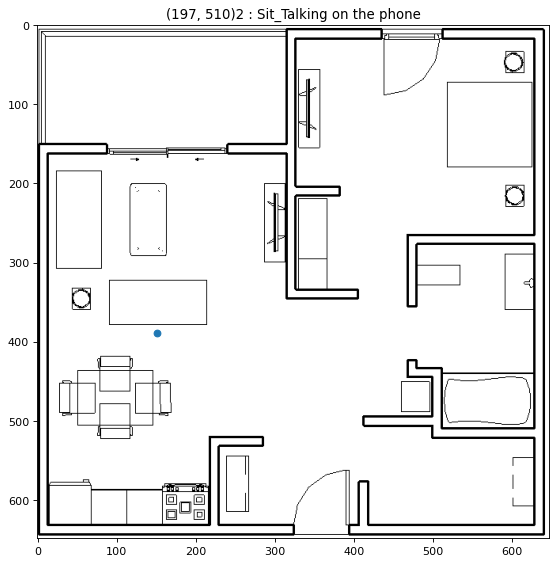

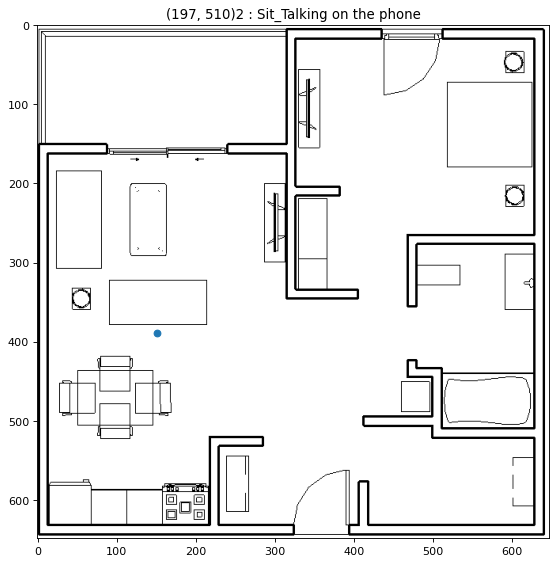

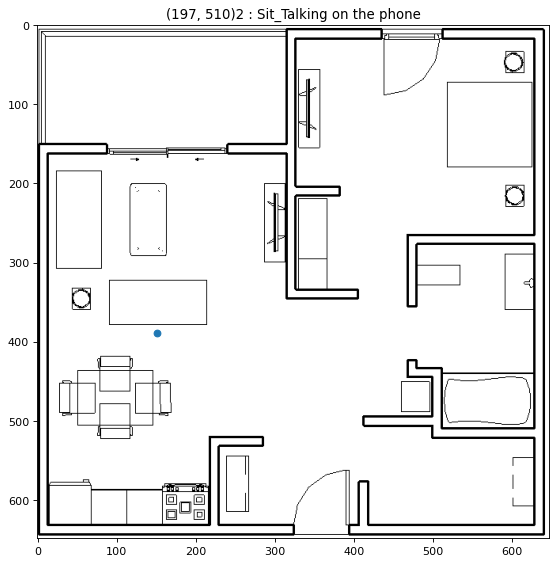

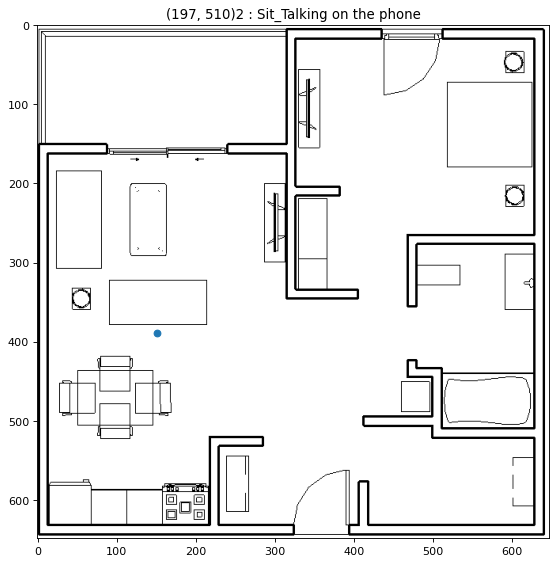

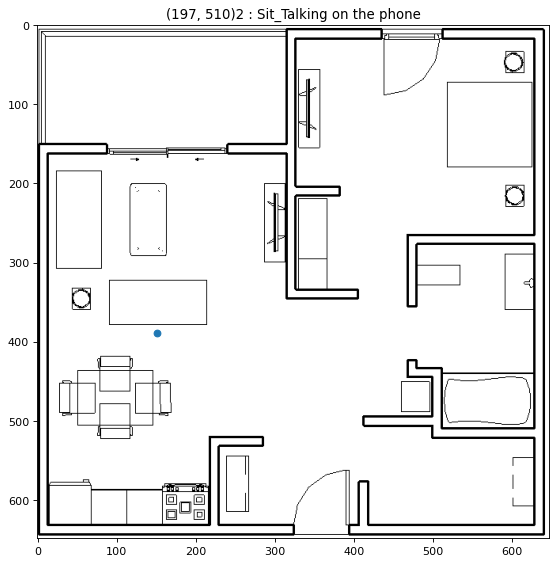

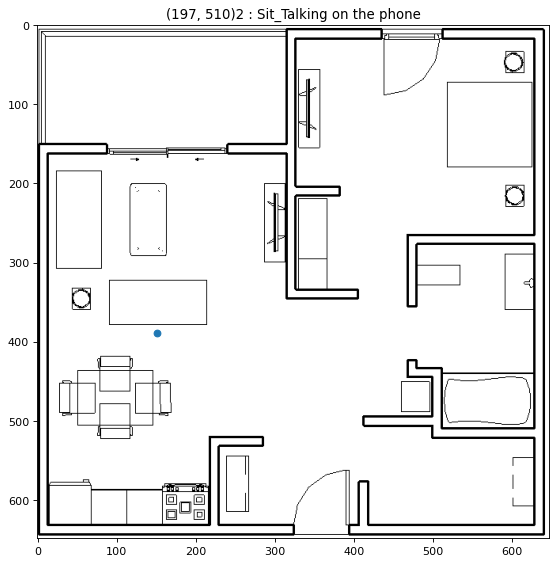

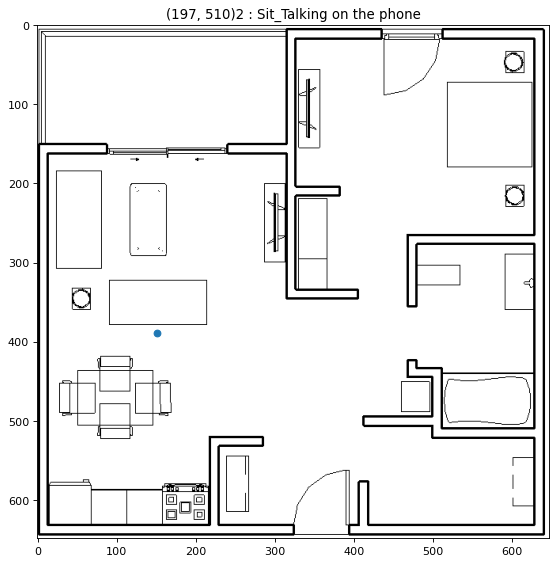

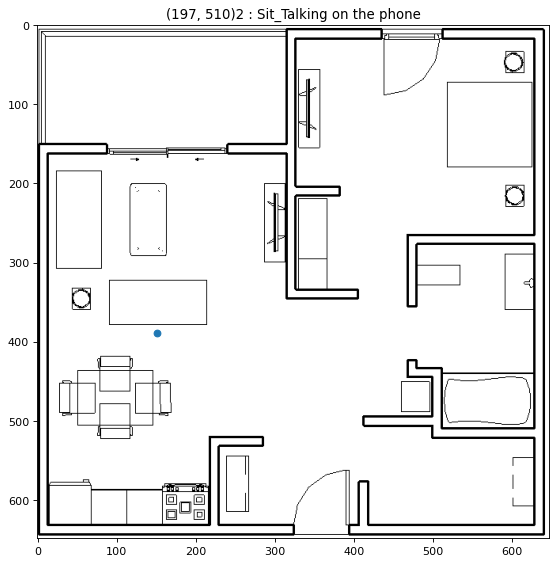

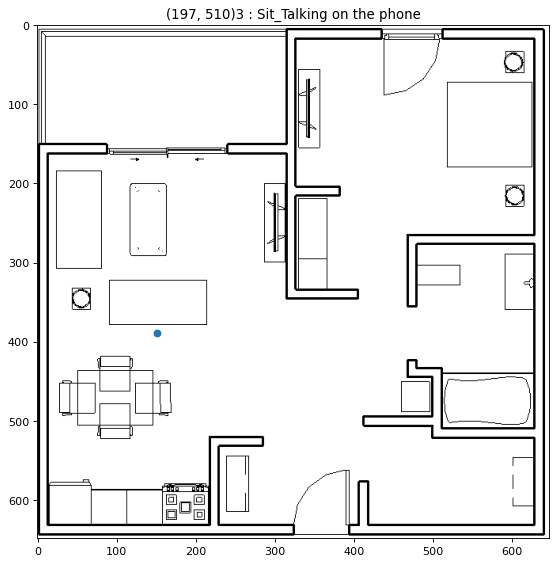

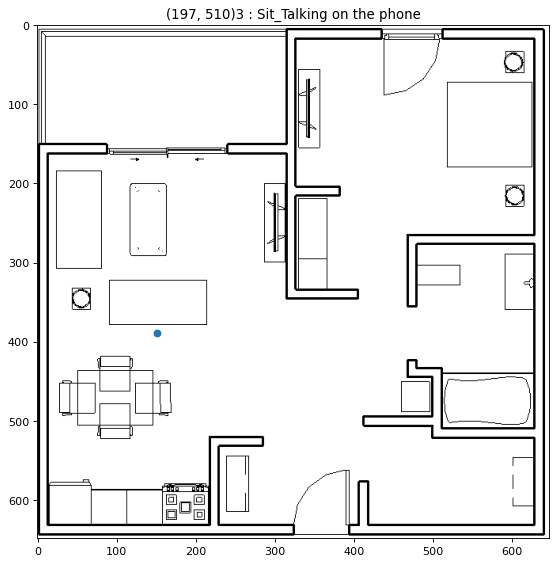

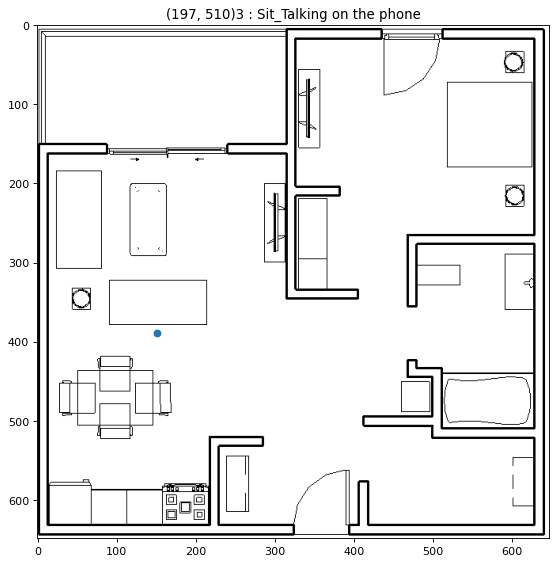

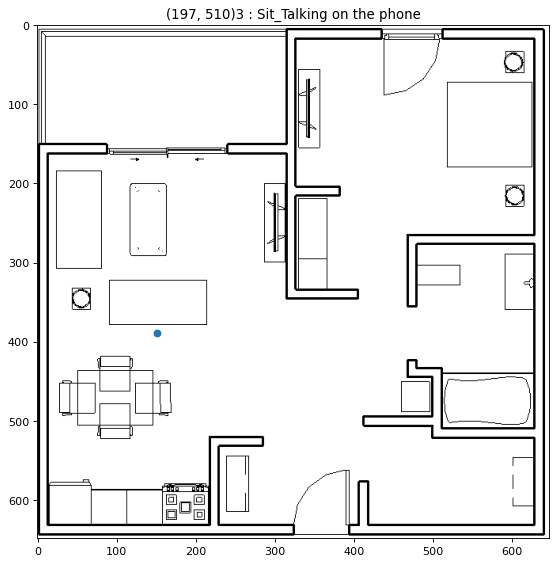

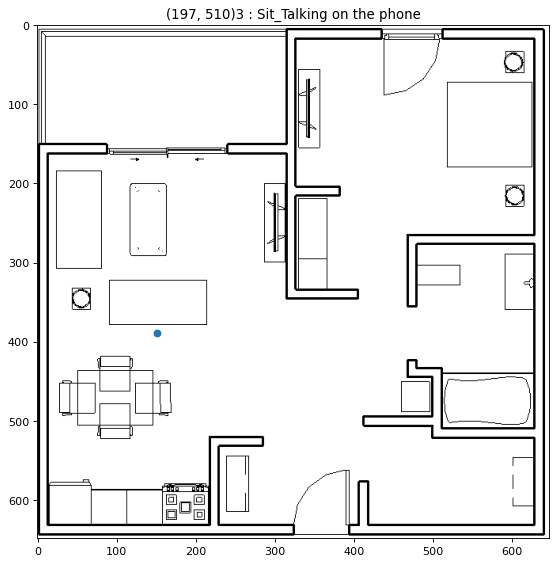

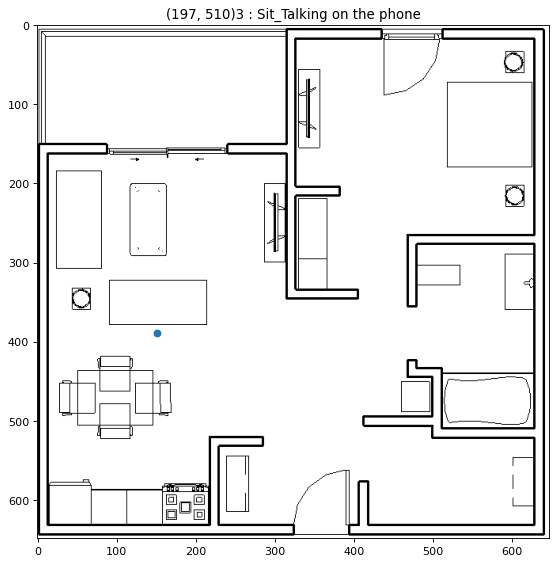

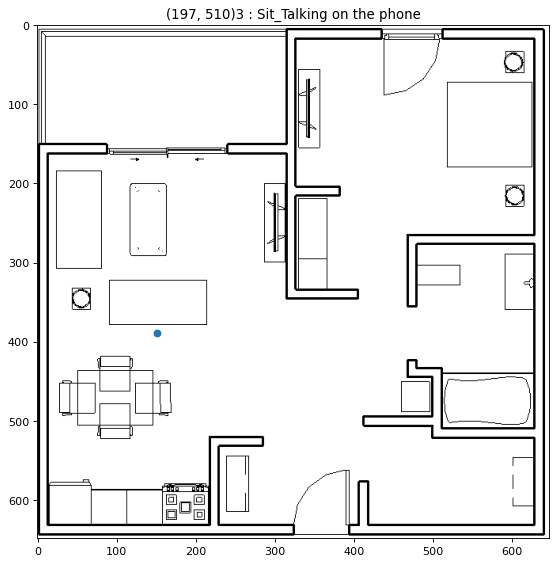

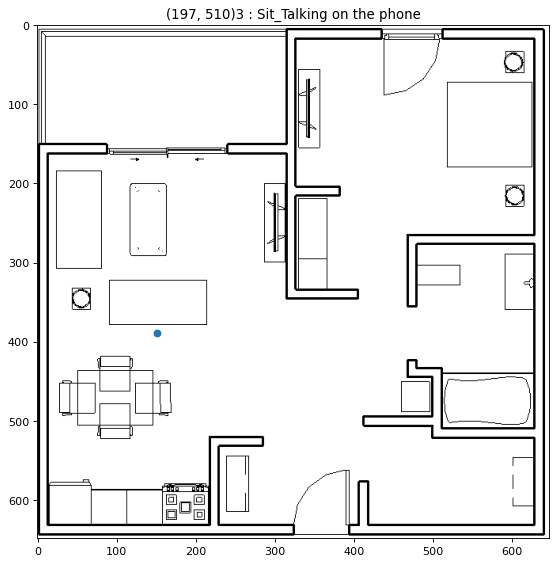

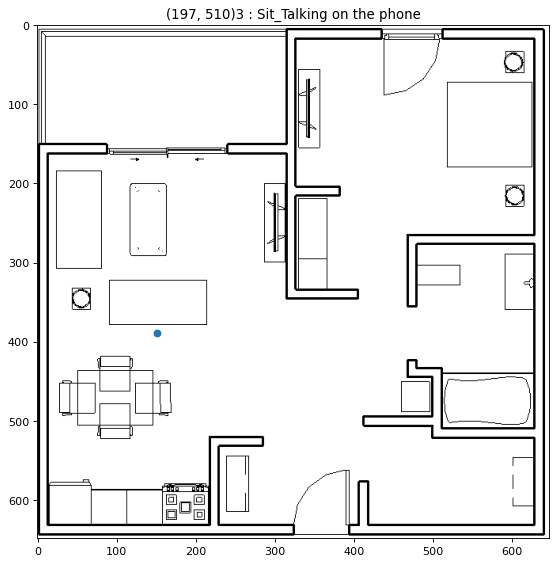

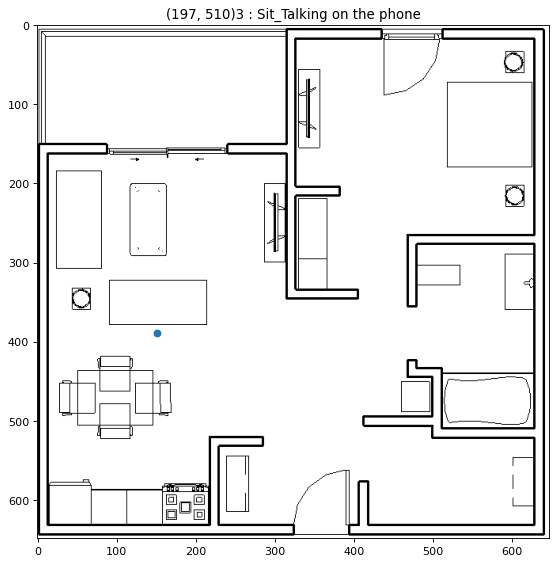

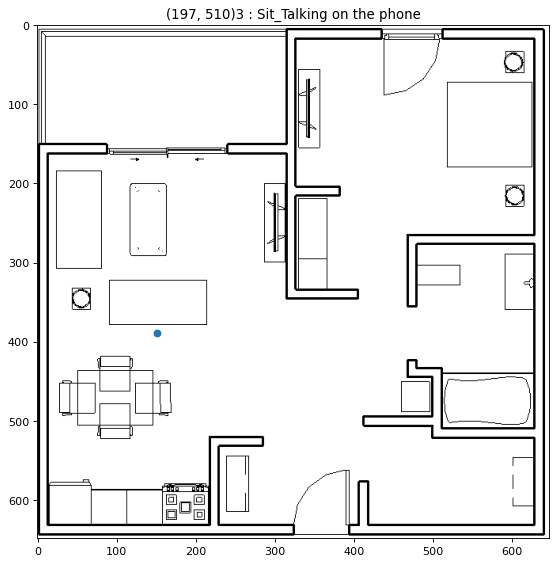

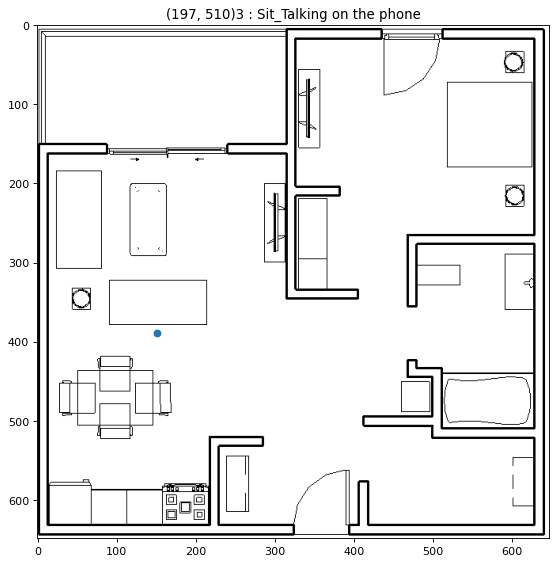

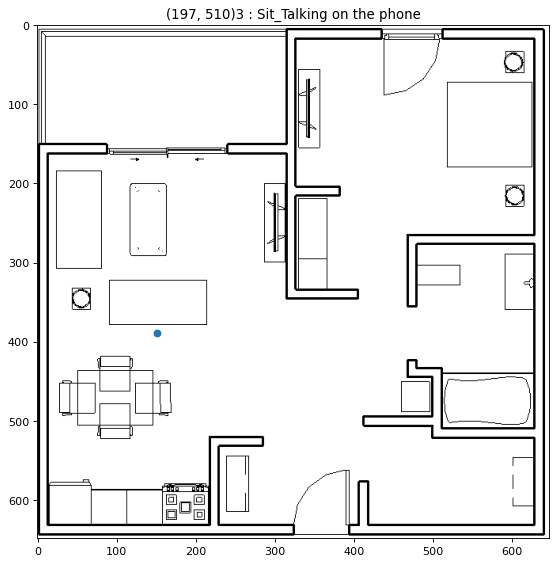

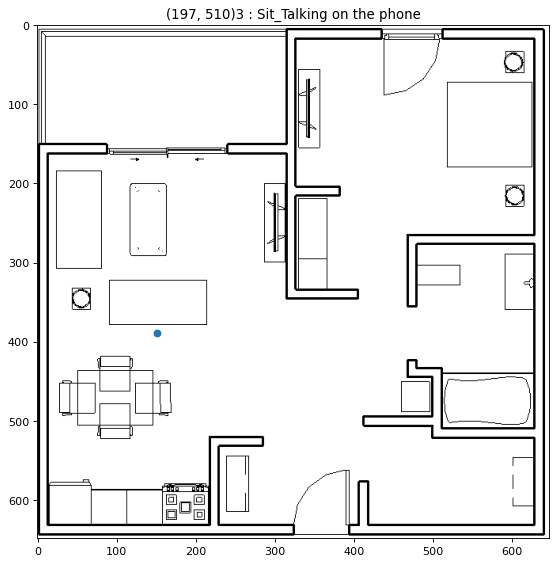

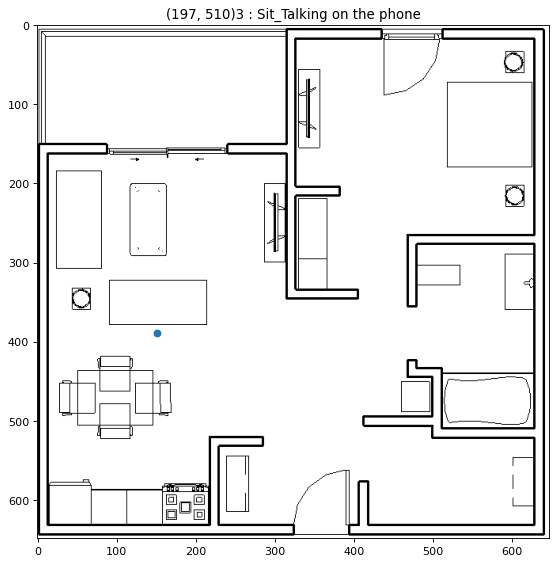

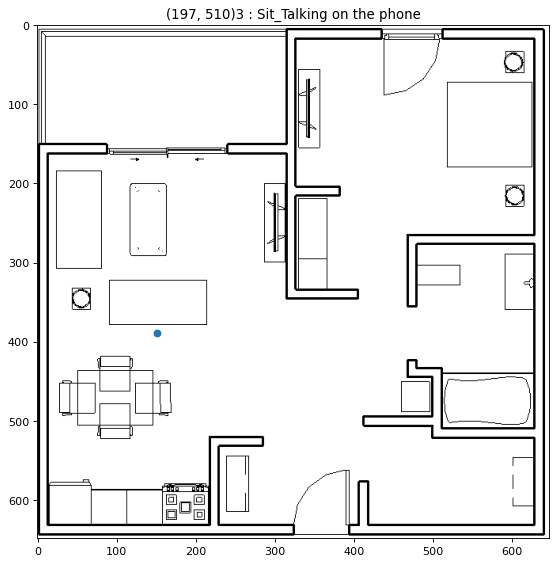

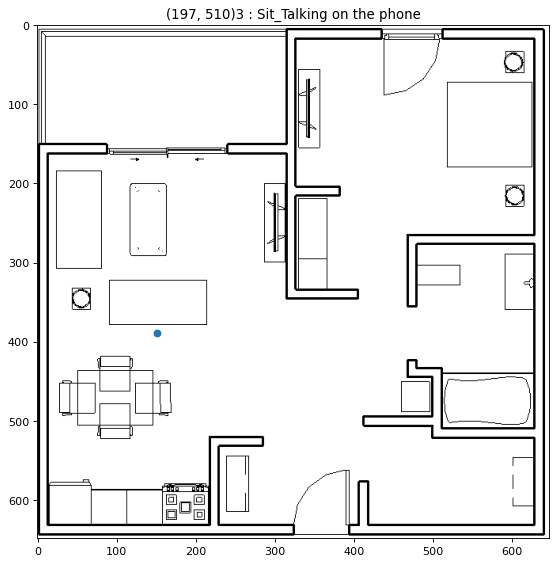

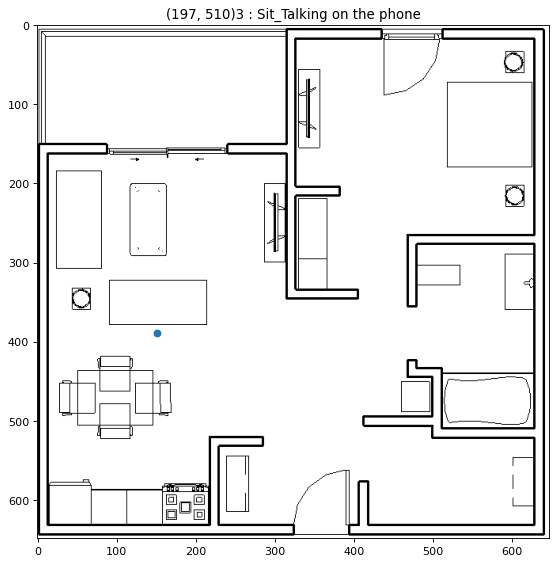

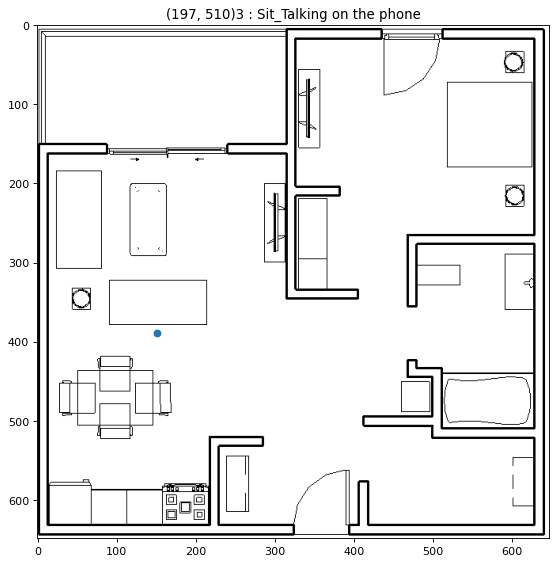

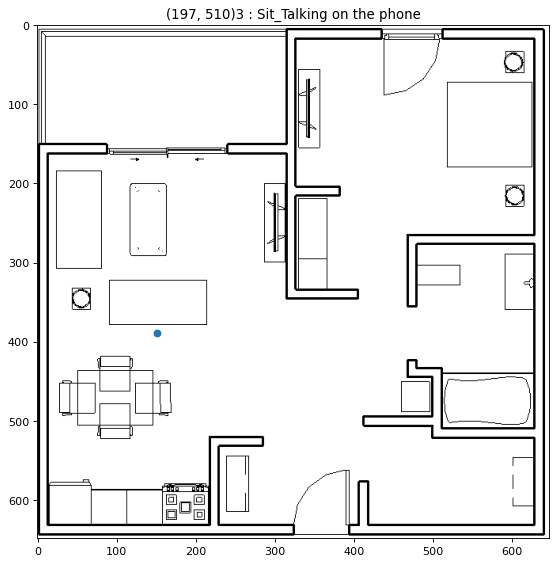

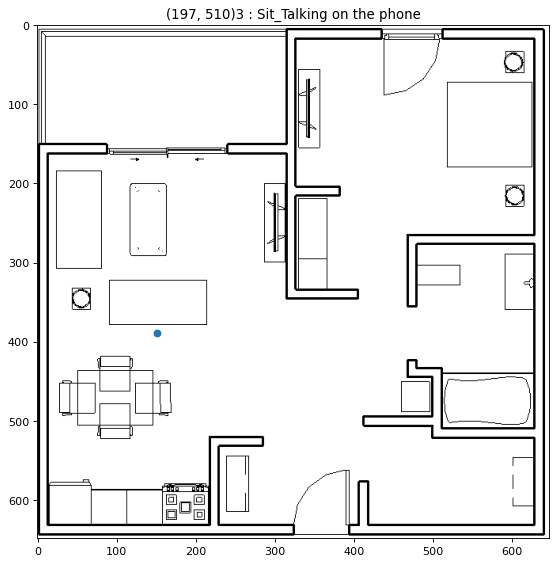

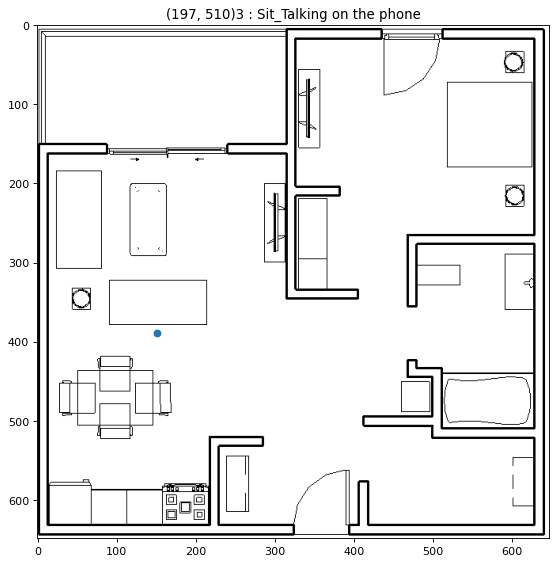

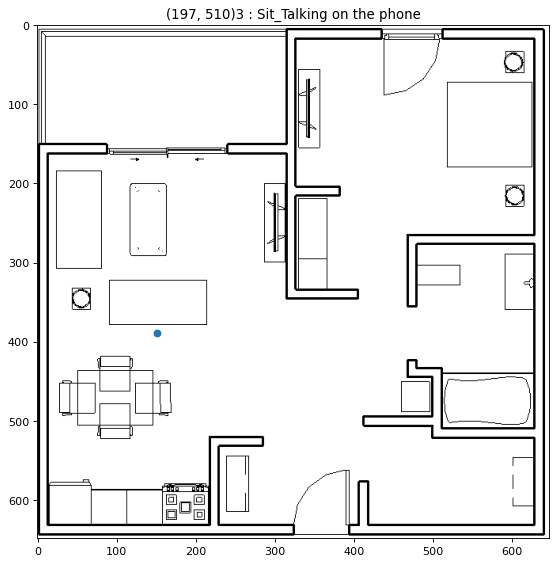

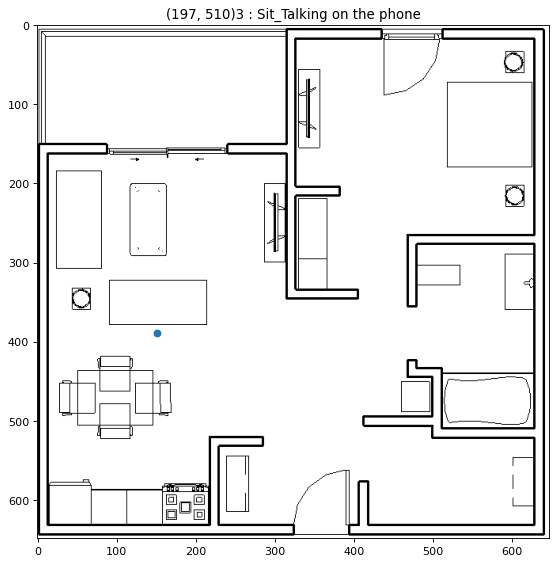

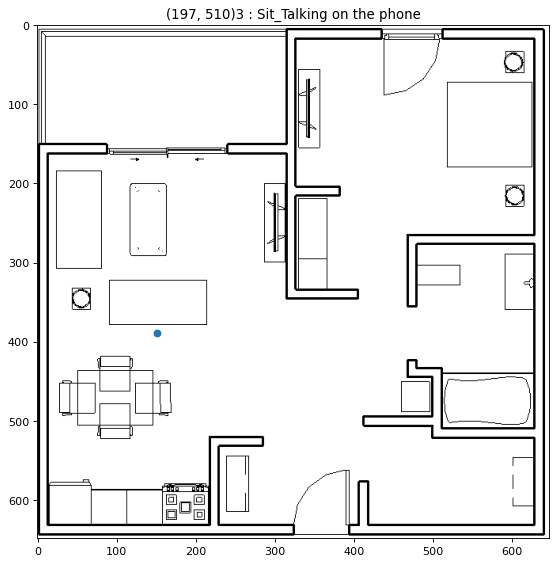

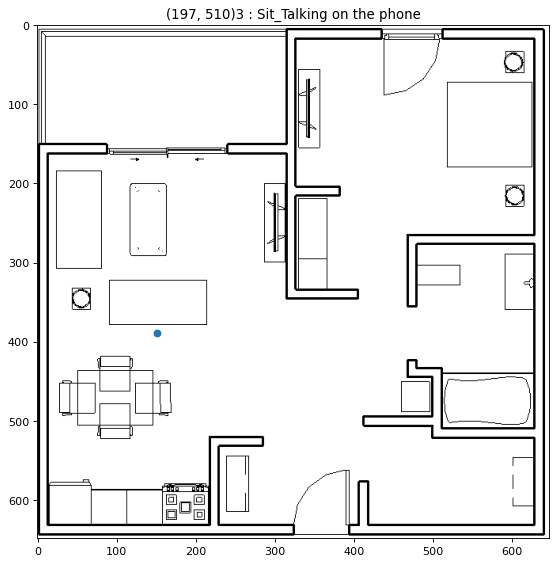

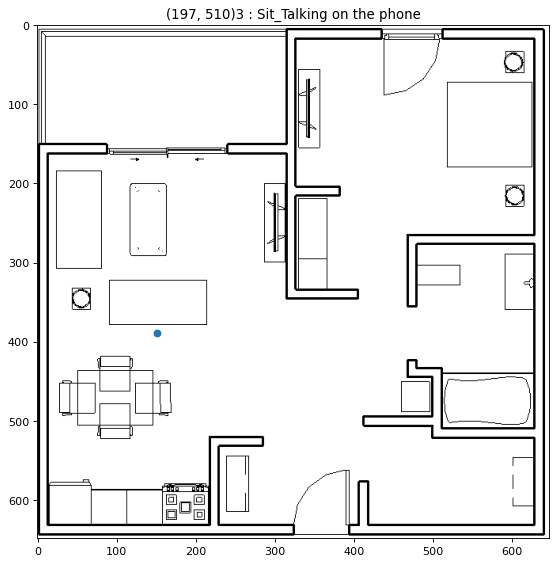

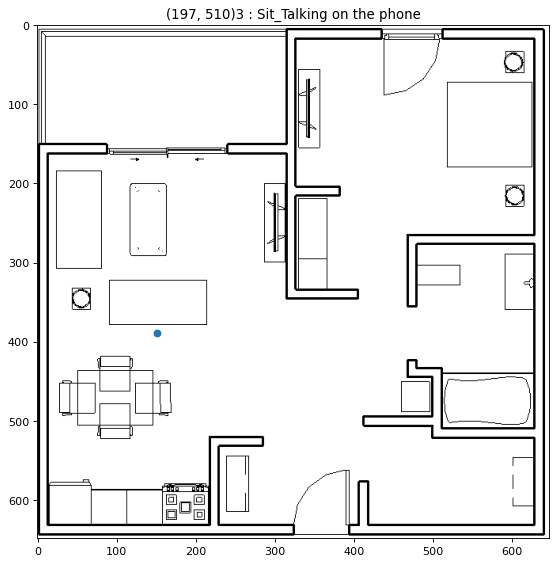

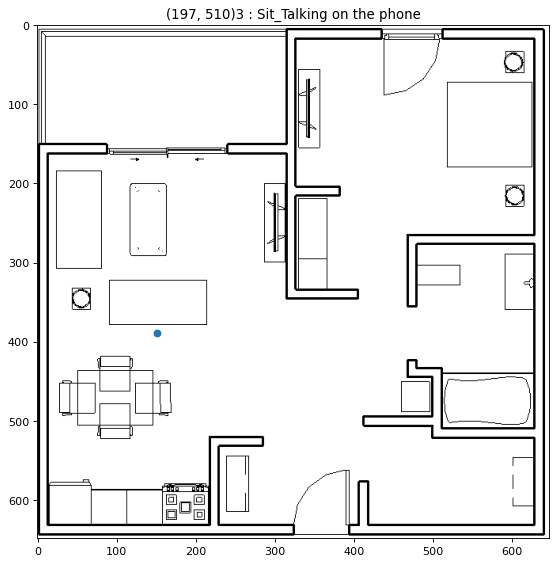

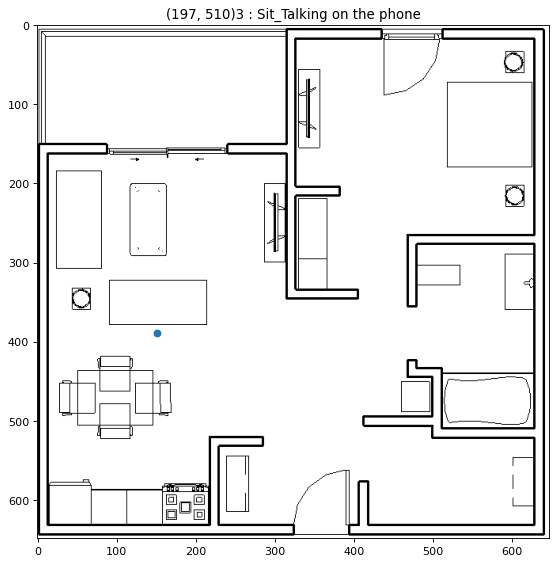

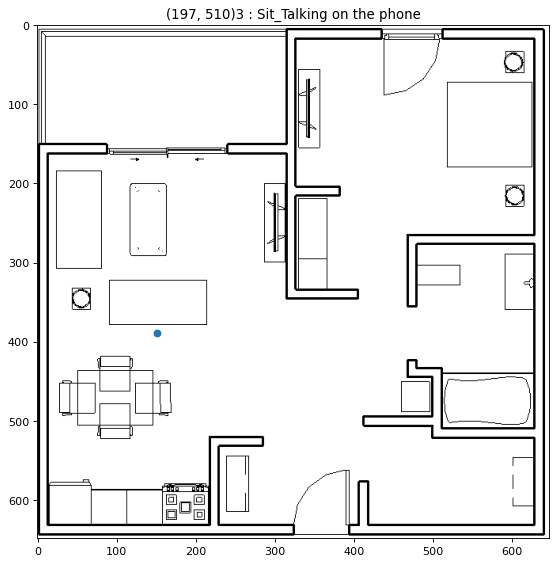

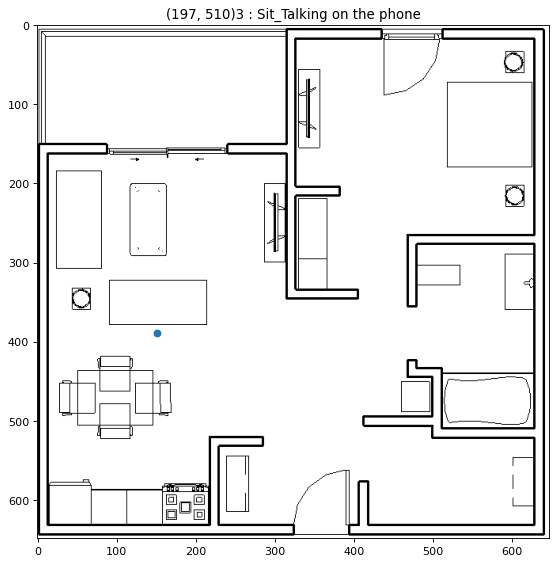

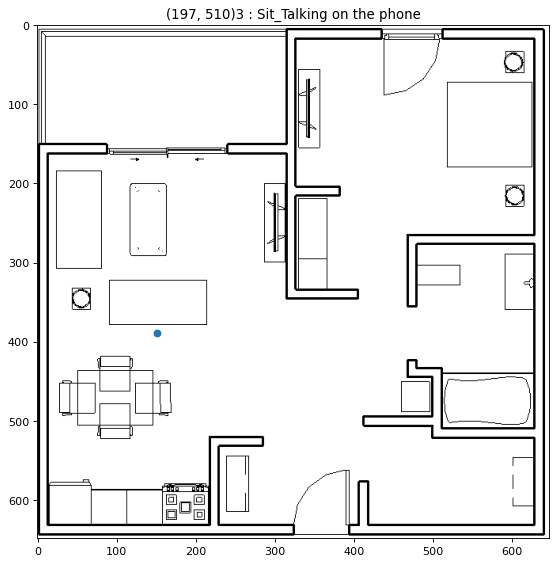

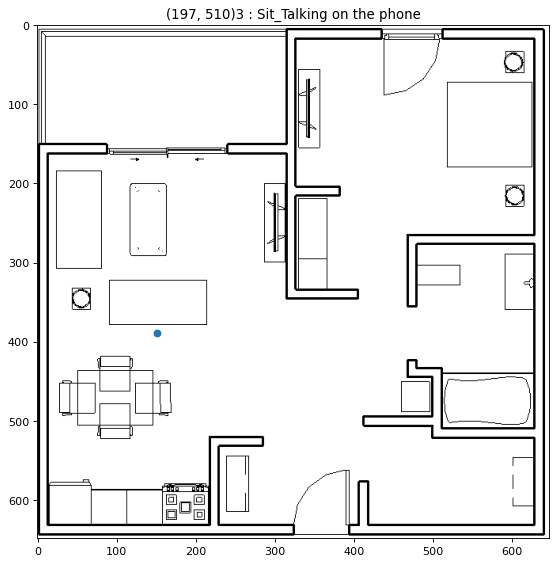

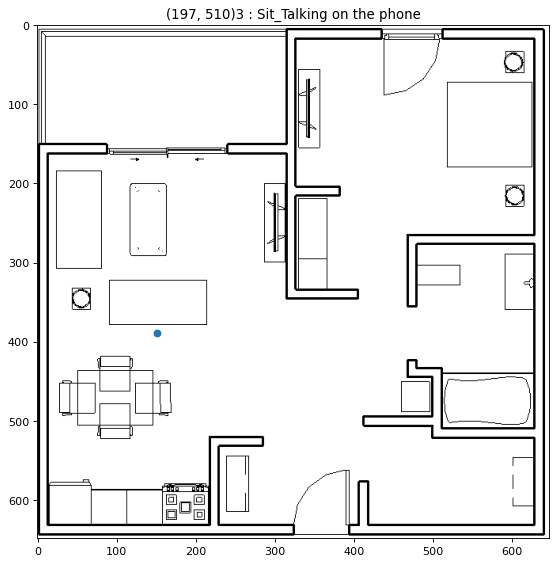

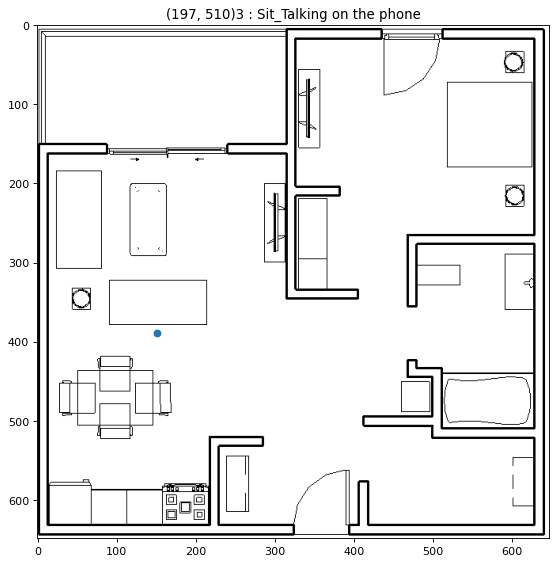

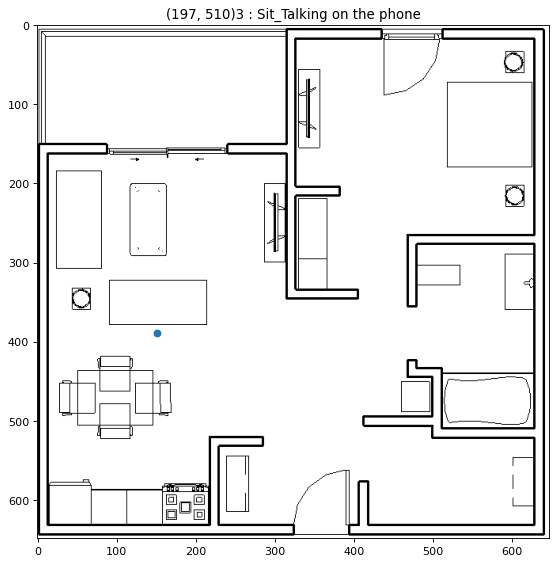

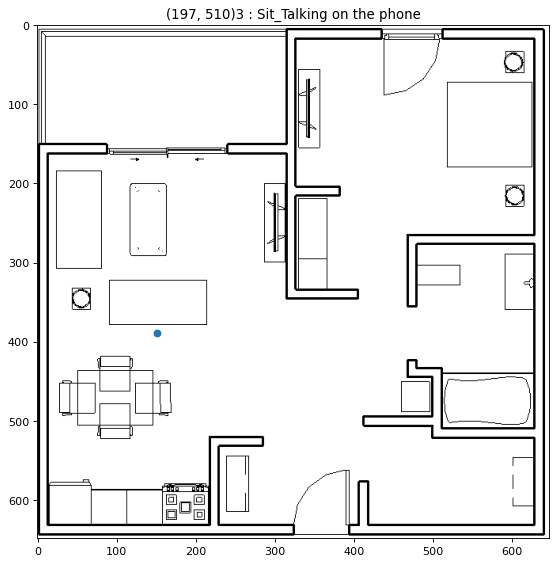

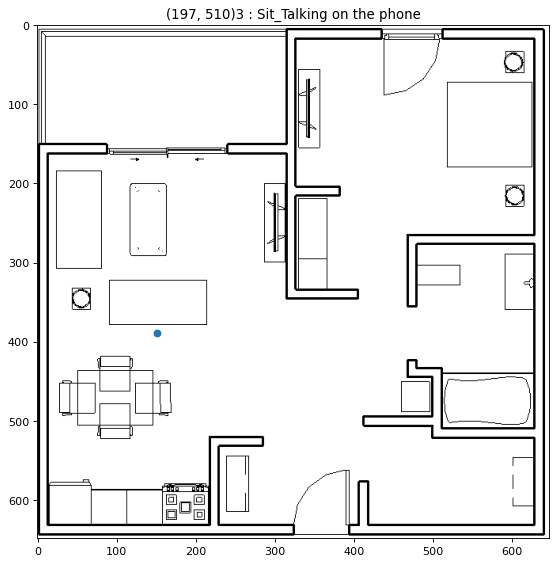

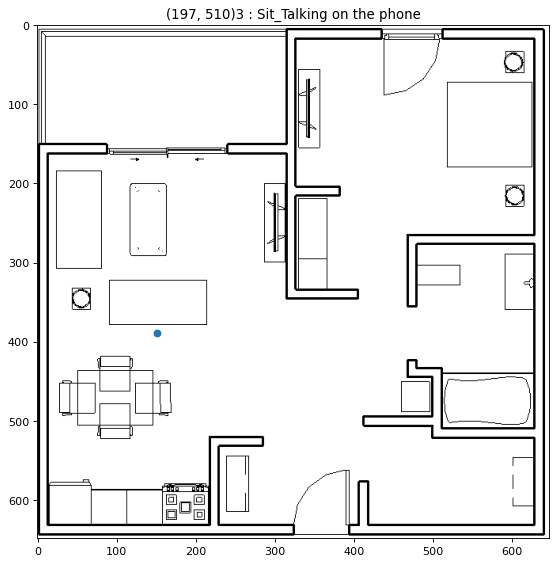

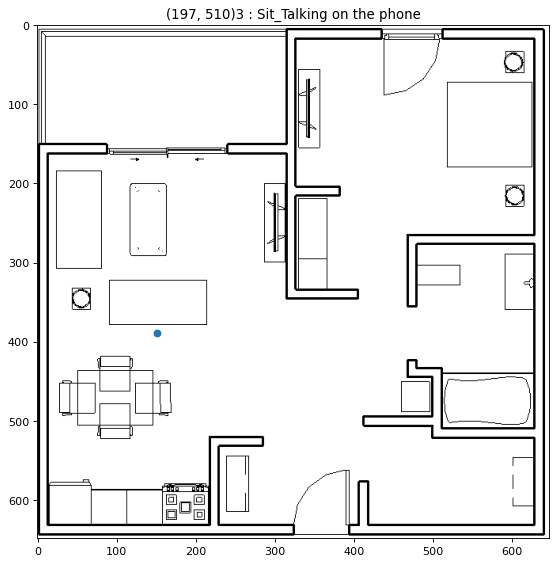

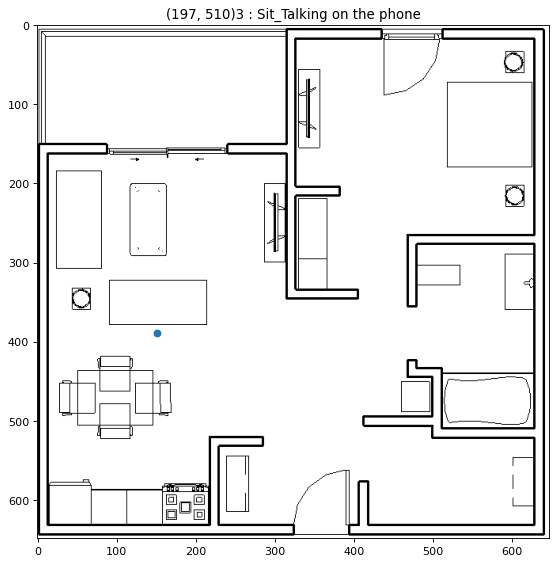

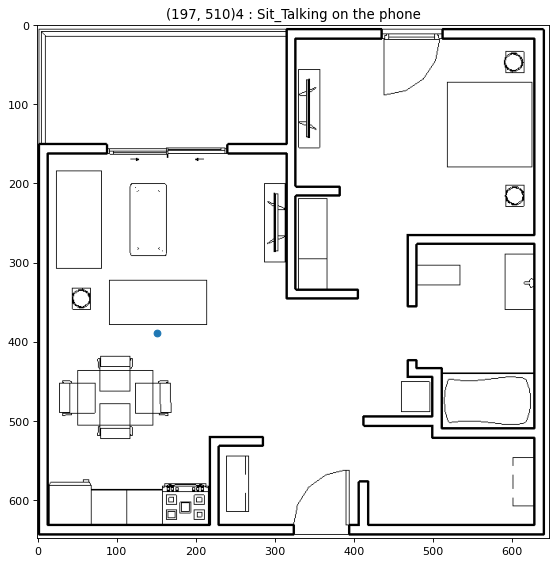

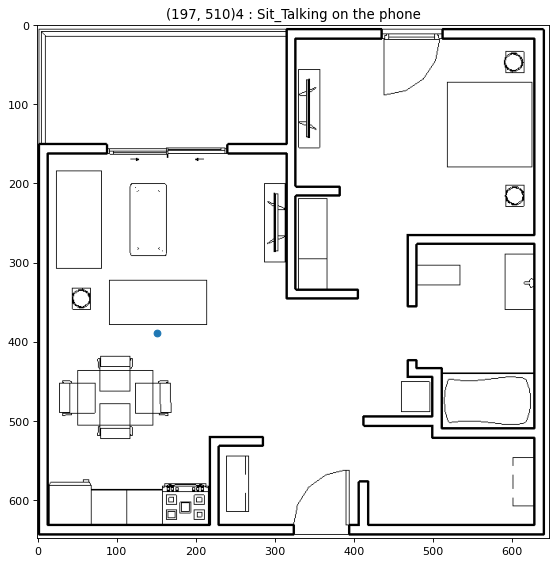

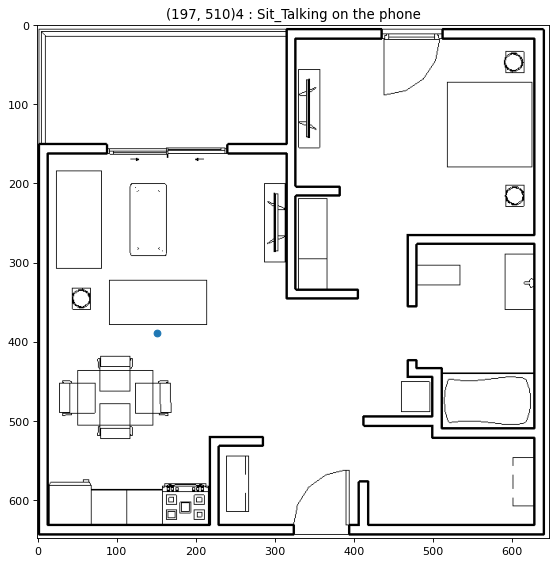

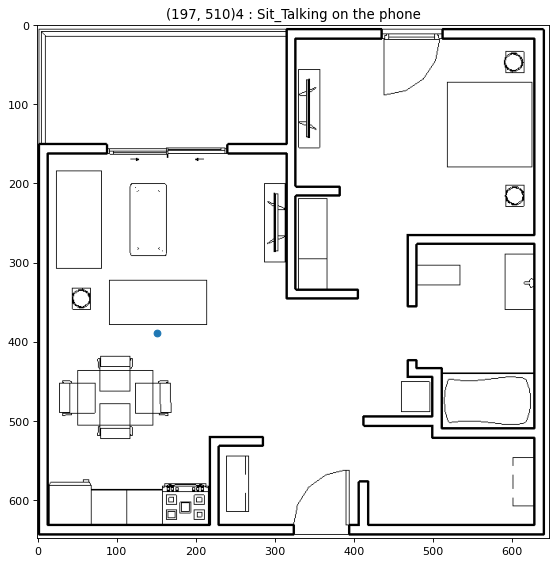

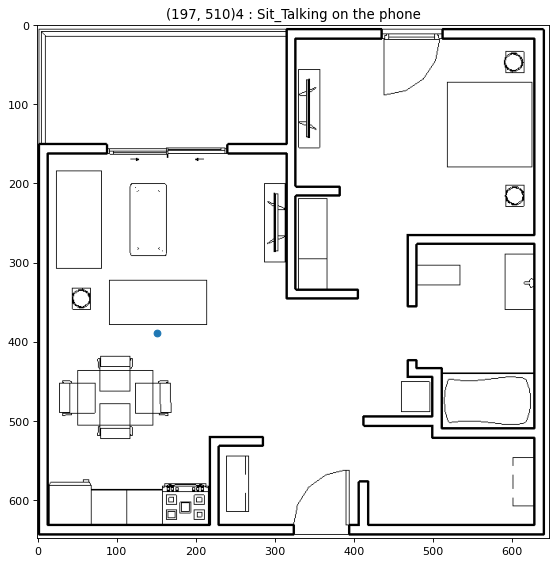

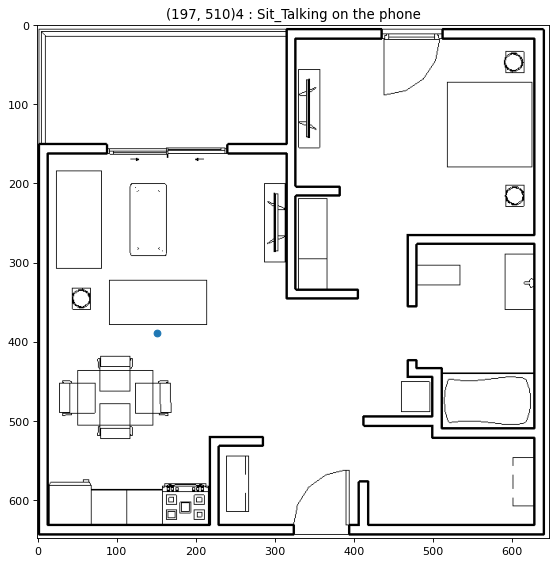

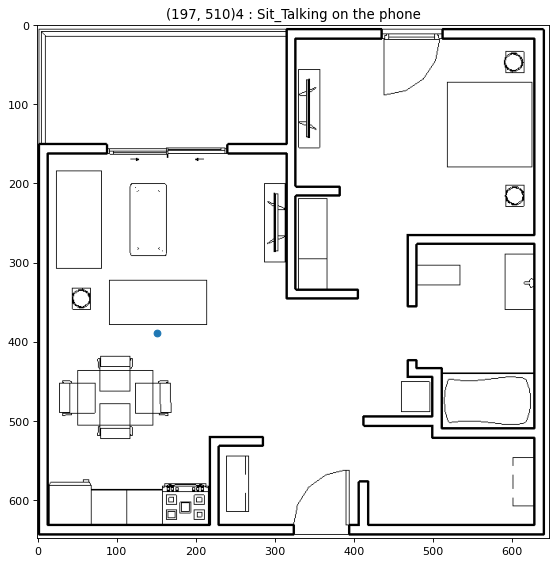

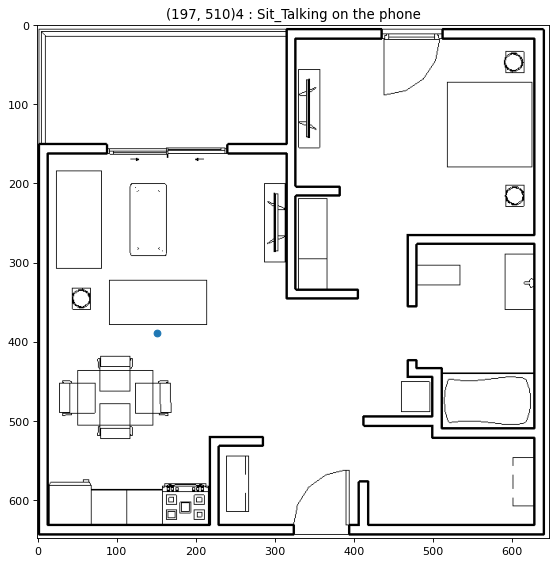

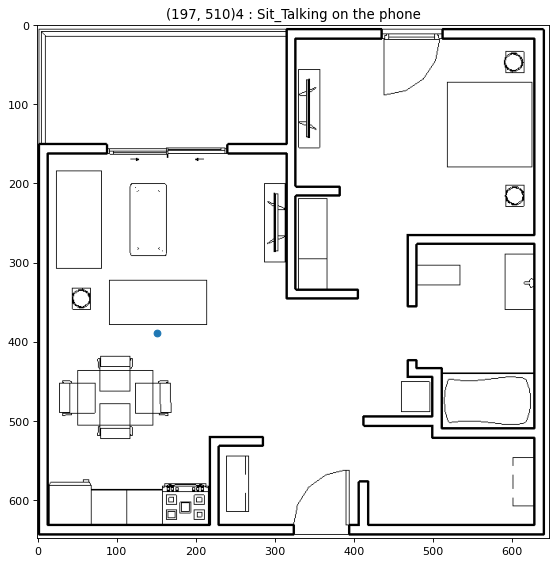

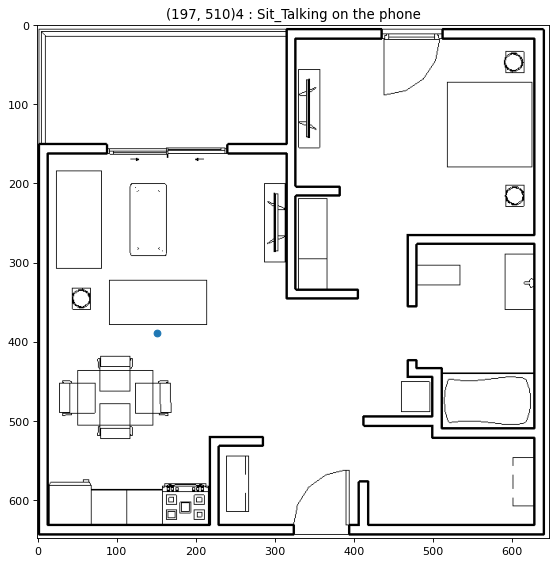

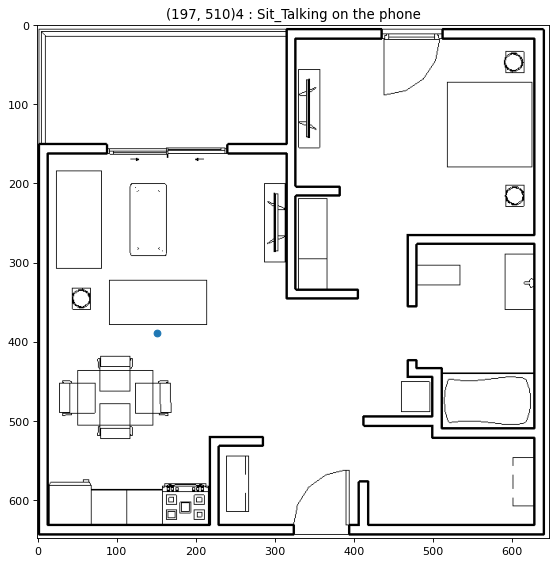

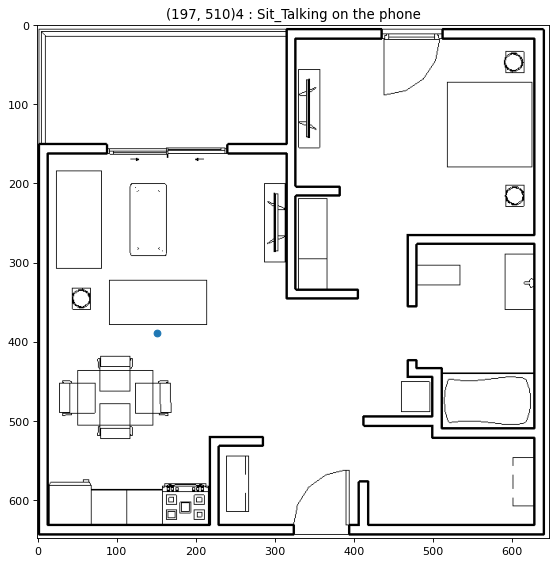

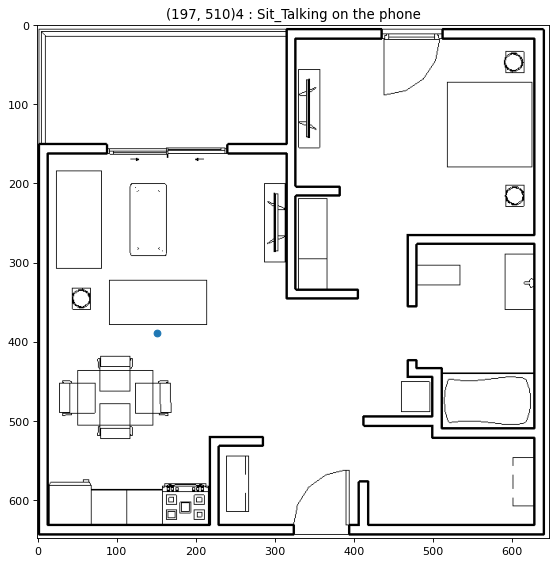

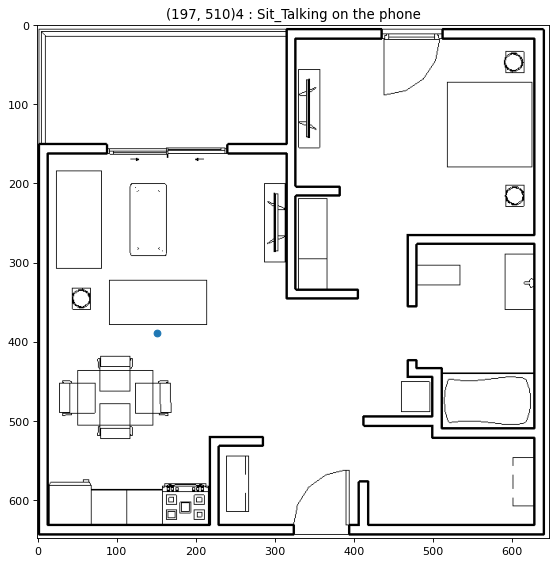

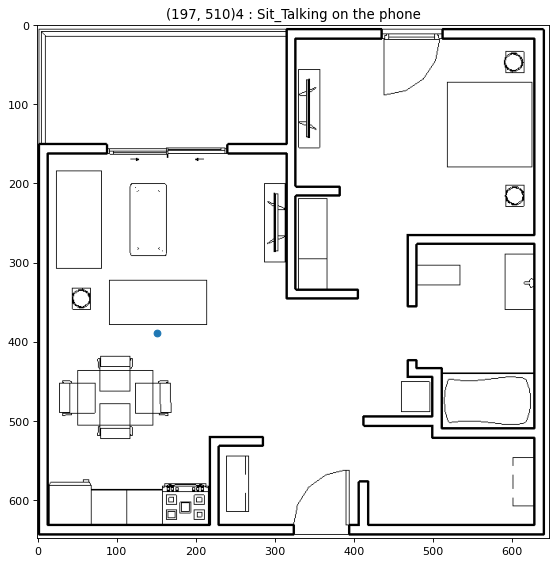

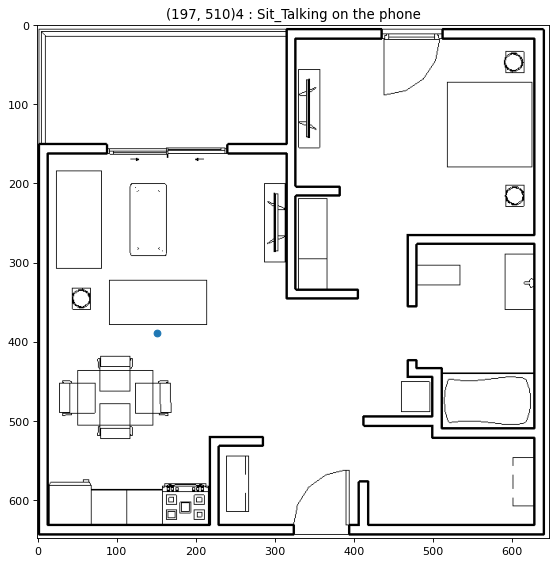

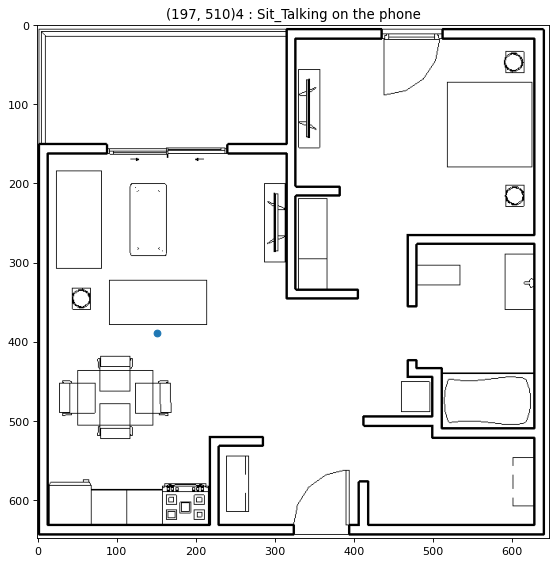

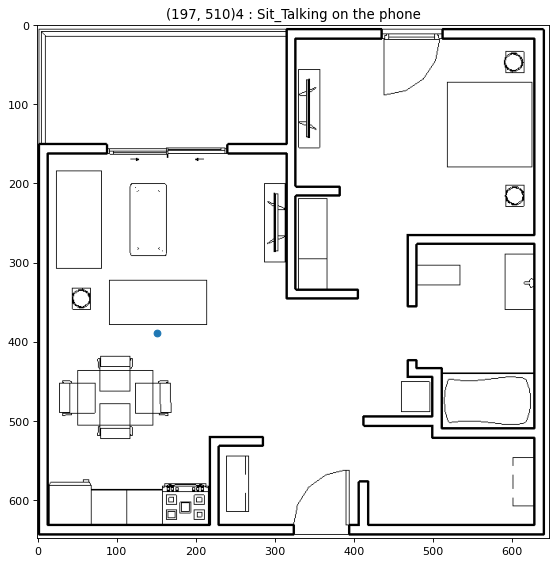

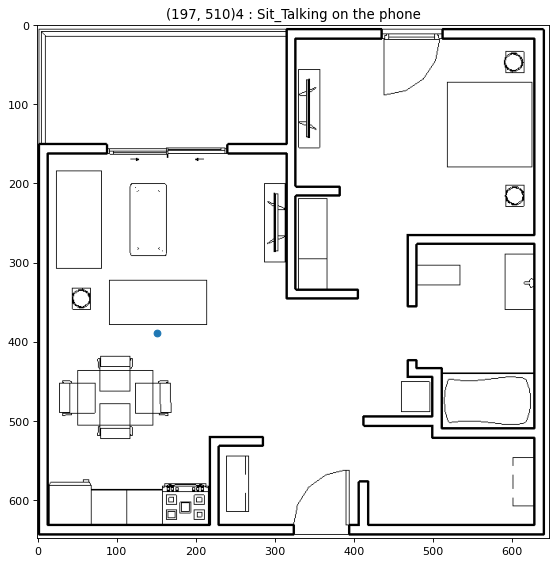

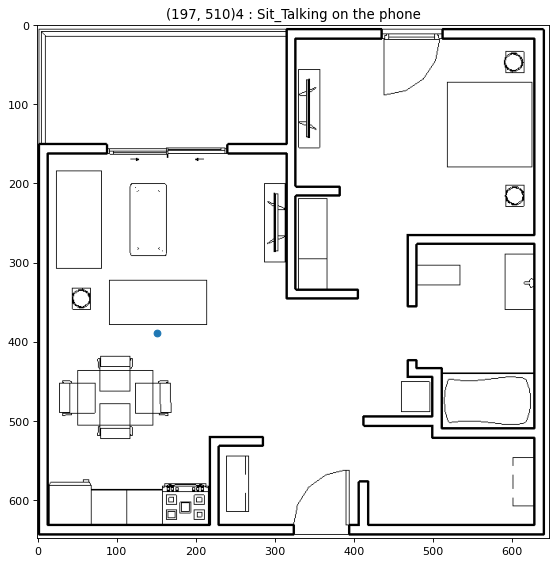

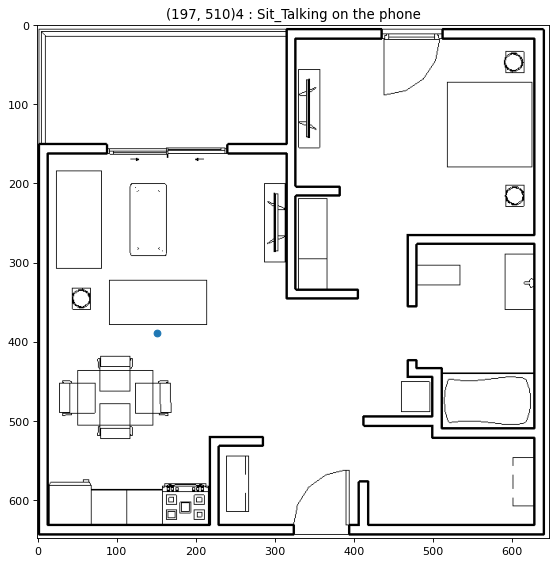

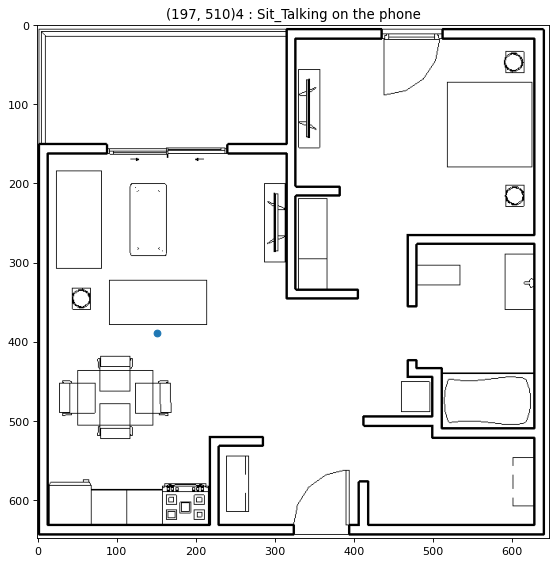

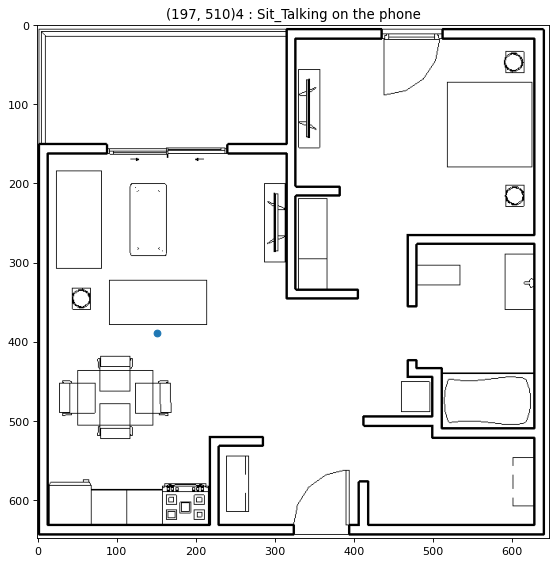

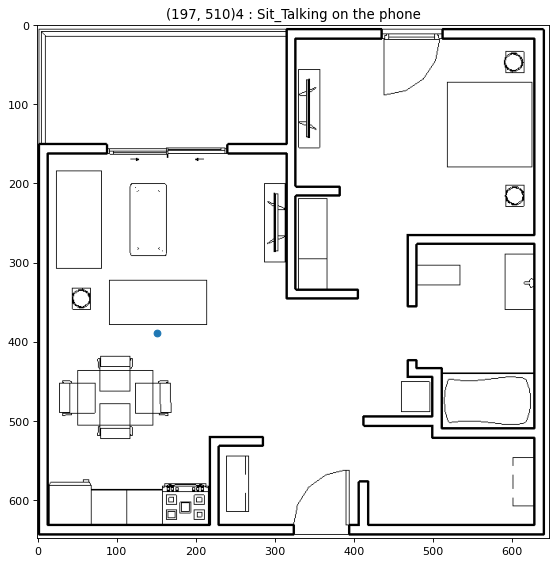

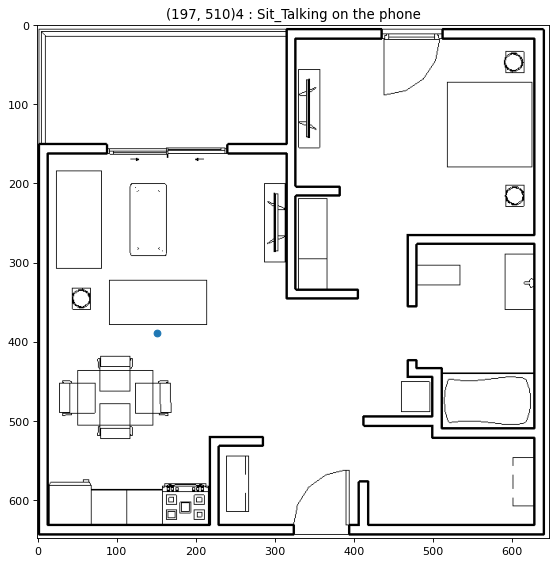

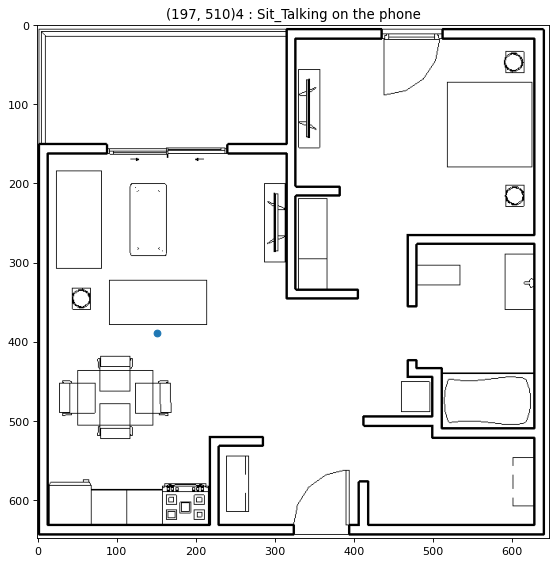

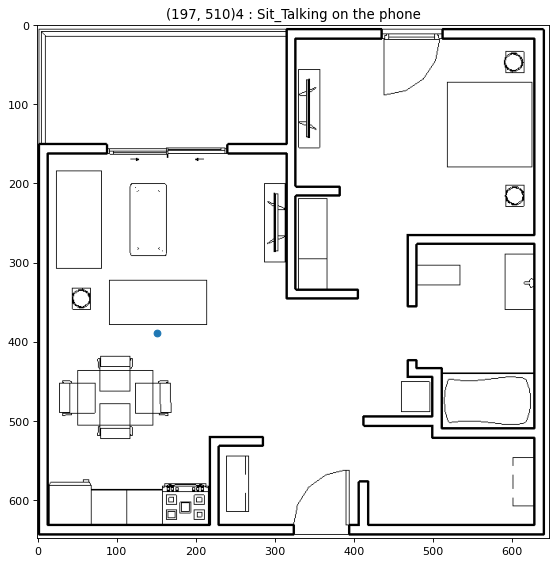

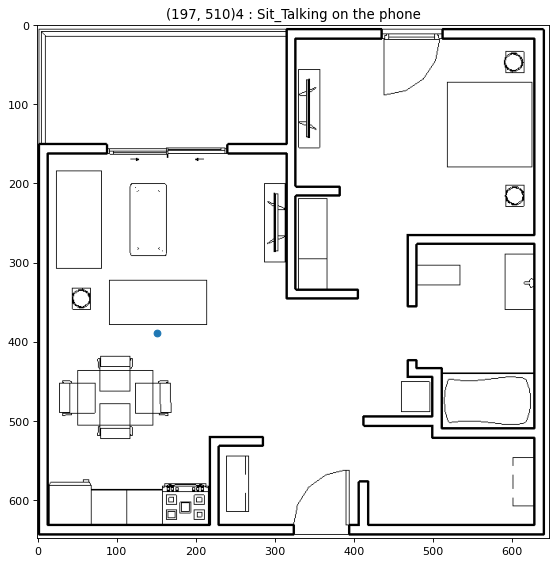

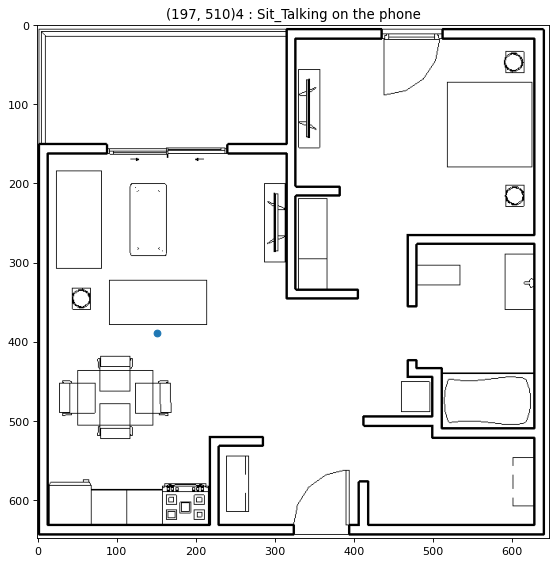

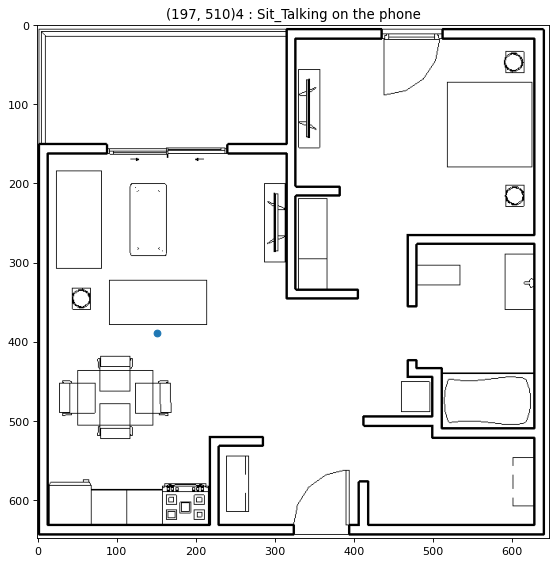

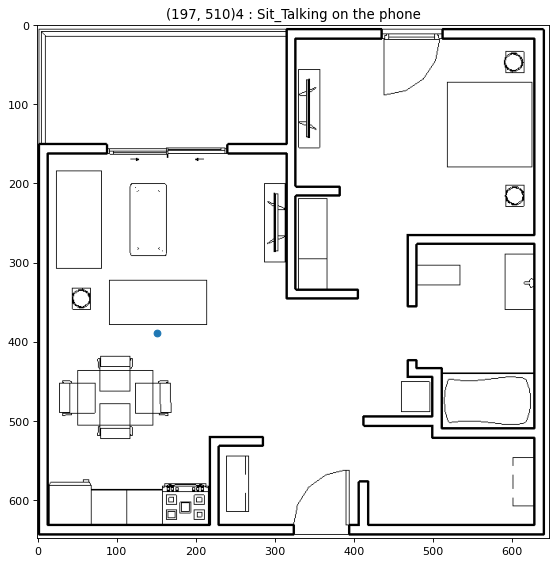

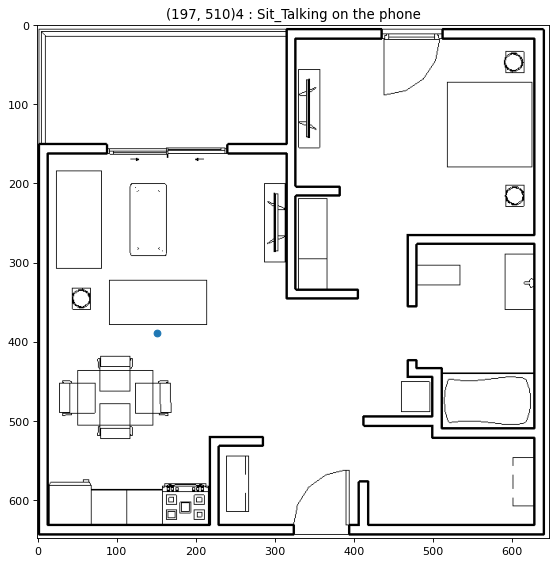

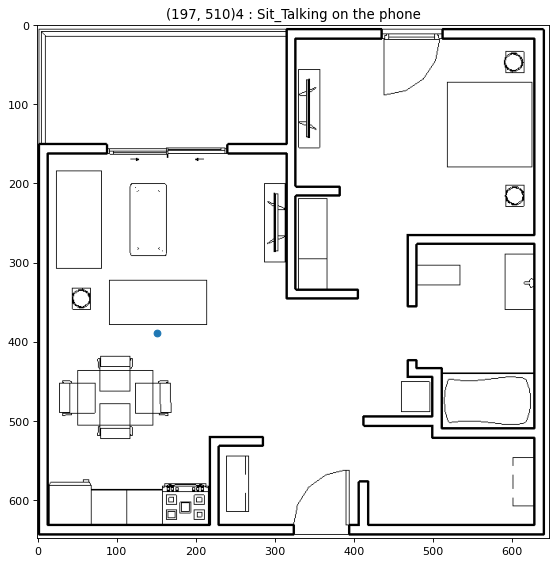

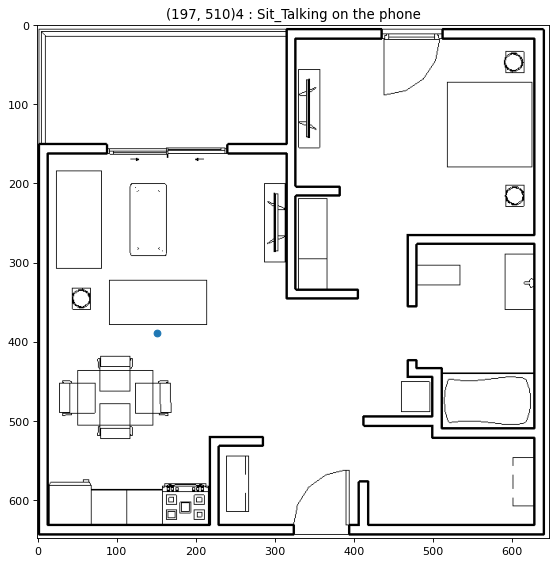

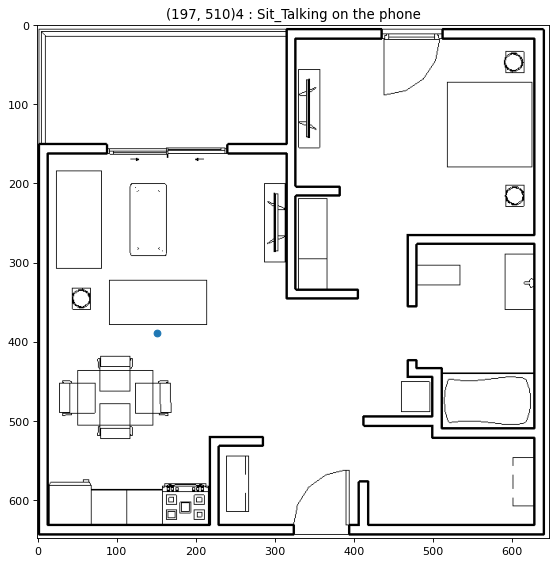

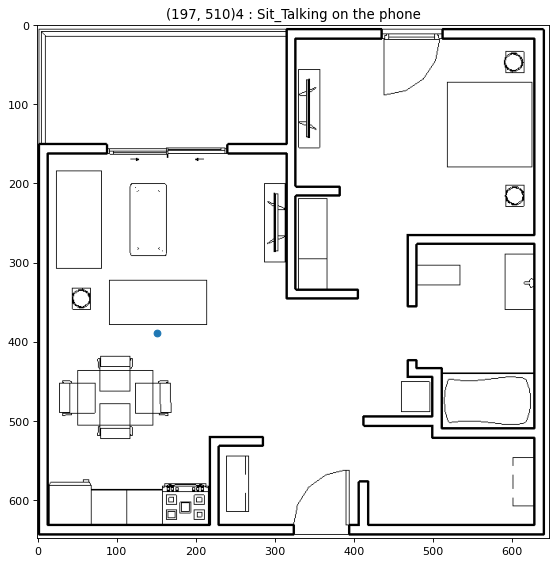

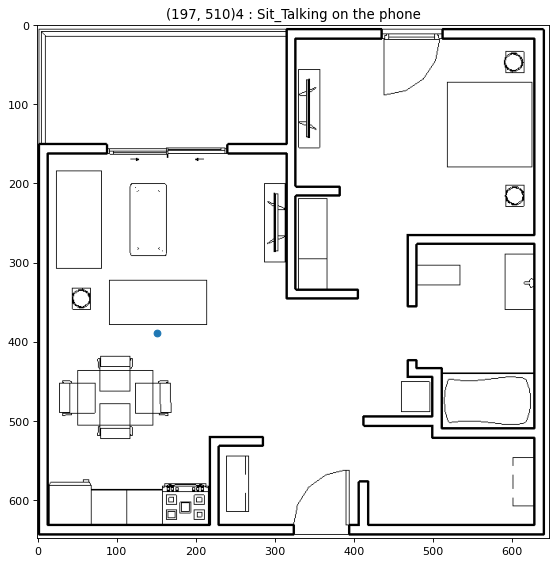

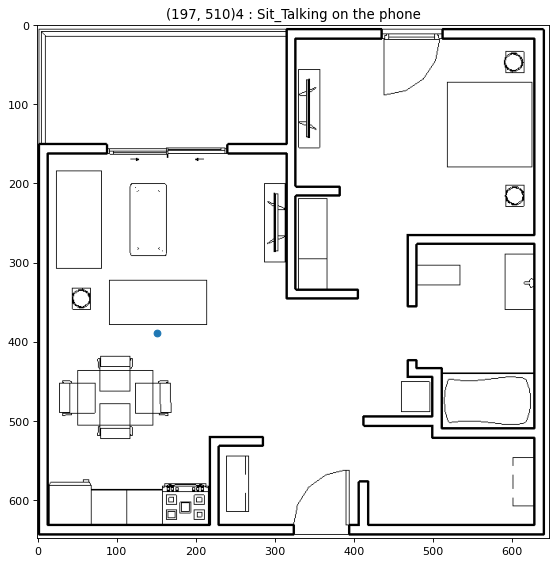

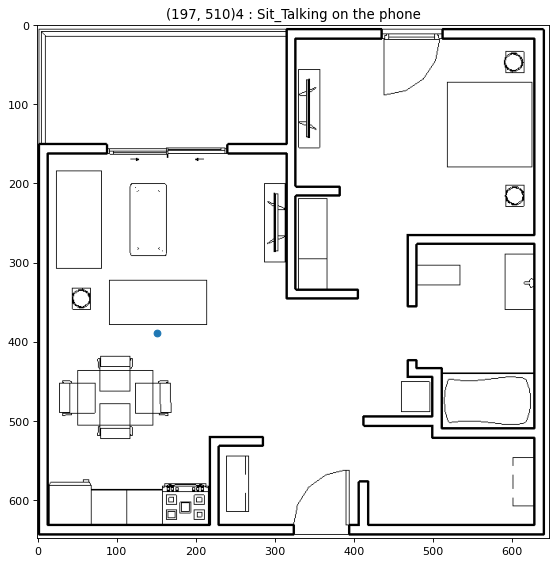

Error in callback <function flush_figures at 0x0000023997030C10> (for post_execute):


KeyboardInterrupt: 

In [4]:
import pandas as pd
import time
%matplotlib inline
import time
import pylab as pl
from IPython import display



for agentTrace in BOV.agentTraces:
    df_ = pd.read_csv(agentTrace,  index_col = False) 
    from matplotlib.pyplot import figure
    import matplotlib.pyplot as plt

    
    for i in range(len(df_.x)):
        
        #img = plt.imread("testcase.jpg")
        fig, ax = plt.subplots(figsize=(8.5, 8.5), dpi=80)
        
        #ax.axis('scaled')
        import numpy as np
        import cv2
        img = cv2.imread('testcase.jpg')
        height, width, channels = img.shape
        #print (height, width, channels)
        ax.imshow(img)
        
        # plt.xlim([0, 8.5])
        # plt.ylim([0, 8.5])
        scatter = plt.scatter((df_.x[i] / 8.5 * width) , (df_.y[i] / 8.5  * height) )
        # ax = scatter.axes
        # ax.invert_yaxis()
        plt.title(str((int(df_.x[i] * 100), int(df_.y[i] * 100))) + str(int((i / len(df_.x) * 100))) + " : " + df_.Action[i])
        display.clear_output(wait=True)
        display.display(pl.gcf())
        # time.sleep(0.1)
        # plt.show()
        
    
    

In [ ]:
print(BOV.agentTraces)